In [1]:
import numpy as np
import pandas as pd
import utils
from pathlib import Path

In [2]:
from ipfx.feature_extractor import (SpikeFeatureExtractor, SpikeTrainFeatureExtractor)
import ipfx.stimulus_protocol_analysis as spa
from ipfx.epochs import get_stim_epoch
from ipfx.dataset.create import create_ephys_data_set
from ipfx.utilities import drop_failed_sweeps
from ipfx.data_set_features import extract_data_set_features
from ipfx.error import FeatureError

import os
import matplotlib.pyplot as plt

In [3]:
def plot_nwb_QC(nwb_path, ontology, stim_start_time, stim_end_time, baseline_interval=0.0001, subthresh_min_amp=-100.0, save_dir = None):
    data_set = create_ephys_data_set(nwb_file=nwb_path, ontology=ontology)  # loads nwb file into ipfx data structure
    cell_features, sweep_features, cell_record, sweep_records, _, _ = extract_data_set_features(data_set)
    long_square_table = data_set.filtered_sweep_table(stimuli=data_set.ontology.long_square_names)
    long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)
    long_square_sweeps = data_set.sweep_set()

    # Select epoch corresponding to the actual recording from the sweeps
    # and align sweeps so that the experiment would start at the same time
    long_square_sweeps.select_epoch("recording")

    # build the extractors
    spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
    sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time, baseline_interval=baseline_interval)

    # run the analysis and print out a few of the features
    long_square_analysis = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=subthresh_min_amp)
    lsa_results = long_square_analysis.analyze(long_square_sweeps) 
        
    rheobase_sweep_index = lsa_results['rheobase_sweep'].name
    hero_sweep_index = lsa_results['hero_sweep'].name
    
    sweeps_to_plot = [0, rheobase_sweep_index, hero_sweep_index]

    
    fig, axes = plt.subplots(3, 1, sharex=False, figsize=(12,8))
    fig.suptitle(f'{nwb_path}', fontsize=12)
    
    yticks = np.arange(min(data_set.sweep_set(0).sweeps[0].i), 
                       max(data_set.sweep_set(hero_sweep_index).sweeps[0].i), 
                       100)
    
    for n, sweep in enumerate(sweeps_to_plot):
        curr_sweep = data_set.sweep_set(sweep).sweeps[0]
        t = curr_sweep.t
        v = curr_sweep.v
        i = curr_sweep.i
        
        if n == 2:
            axes[0].plot(t, v, alpha=0.5)
            axes[1].plot(t, i, alpha=0.5)
        else:
            axes[0].plot(t, v)
            axes[1].plot(t, i)

        axes[0].set_xlim(0, t[-1])
        axes[0].set_ylabel("Membrane voltage (mV)")
        axes[0].set_title(f'Rheo index: {rheobase_sweep_index} \n n_sweeps: {len(long_square_sweeps.sweep_number)}')

        axes[1].sharex(axes[0])
        axes[1].set_yticks(yticks)
        axes[1].set_ylabel("Injected current (pA)")
        axes[1].set_xlabel("Time (s)")        
    
    sweeps_df = lsa_results['sweeps']
    axes[2].plot(sweeps_df['stim_amp'], sweeps_df['avg_rate'], '.-')
    axes[2].set_ylabel("Average firing rate (Hz)")
    axes[2].set_xlabel("Stimulus amplitude (pA)")
    
    plt.tight_layout()
    
    if save_dir:
        file_stem = Path(nwb_path).stem
        plot_path = Path(save_dir) / f'{file_stem}.png'
        fig.savefig(plot_path, facecolor='w')    

In [4]:
def QC_V_baseline(nwb_path, ontology, stim_start_time, stim_end_time, baseline_interval=0.0001, subthresh_min_amp=-100.0):
    data_set = create_ephys_data_set(nwb_file=nwb_path, ontology=ontology)  # loads nwb file into ipfx data structure
    cell_features, sweep_features, cell_record, sweep_records, _, _ = extract_data_set_features(data_set)
    long_square_table = data_set.filtered_sweep_table(stimuli=data_set.ontology.long_square_names)
    long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)
    long_square_sweeps = data_set.sweep_set()

    # Select epoch corresponding to the actual recording from the sweeps
    # and align sweeps so that the experiment would start at the same time
    long_square_sweeps.select_epoch("recording")

    # build the extractors
    spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
    sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time, baseline_interval=baseline_interval)

    # run the analysis and print out a few of the features
    long_square_analysis = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=subthresh_min_amp)
    lsa_results = long_square_analysis.analyze(long_square_sweeps)
    
    initial_v_baseline = lsa_results['sweeps']['v_baseline'].iloc[0]
    last_v_baseline = lsa_results['sweeps']['v_baseline'].iloc[-1]
    first_last_baseline_diff = (initial_v_baseline - last_v_baseline)
    baseline_differences = abs(lsa_results['sweeps']['v_baseline'] - initial_v_baseline)
    max_drift_Vm = baseline_differences.max()
    max_diff_v_baseline = lsa_results['sweeps']['v_baseline'][baseline_differences.idxmax()]
    percent_diff_from_baseline = abs(max_drift_Vm / initial_v_baseline) * 100
    
    return initial_v_baseline, last_v_baseline, first_last_baseline_diff, max_drift_Vm, max_diff_v_baseline, percent_diff_from_baseline


In [5]:
col_names= ['file_id', 'initial_v_baseline', 'last_v_baseline', 'first_last_baseline_diff', 'max_drift_Vm', 'max_diff_v_baseline', 'percent_diff_from_baseline']

In [6]:
ontology_path = "./data/stim_ontology_new_Homeira.json"

natcom_path = Path('./data/processed/recordings/human/natcom/')
h19_path = Path('./data/processed/recordings/human/h2019/')
h18_path = Path('./data/processed/recordings/human/h2018/')
m19_path = Path('./data/processed/recordings/mouse/m2019/')
m18_path = Path('./data/processed/recordings/mouse/m2018/')

h19 = utils.summary_df(path=h19_path, suffix='.nwb')
h18 = utils.summary_df(path=h18_path, suffix='.nwb')
m19 = utils.summary_df(path=m19_path, suffix='.nwb')
m18 = utils.summary_df(path=m18_path, suffix='.nwb')
natcom = utils.summary_df(path=natcom_path, suffix='.nwb')

h19['file_id'] = h19.file_name.str.rstrip('.nwb')
h18['file_id'] = h18.file_name.str.rstrip('.nwb')
m19['file_id'] = m19.file_name.str.rstrip('.nwb')
m18['file_id'] = m18.file_name.str.rstrip('.nwb')
natcom['file_id'] = natcom.file_name.str.rstrip('.nwb')

In [7]:
meta_h19 = pd.read_csv('./data/processed/meta/h2019_meta.csv', index_col=0).drop('path', axis=1)
meta_h18 = pd.read_csv('./data/processed/meta/h2018_meta.csv', index_col=0).drop('path', axis=1)
meta_m19 = pd.read_csv('./data/processed/meta/m2019_meta.csv', index_col=0).drop('path', axis=1)
meta_m18 = pd.read_csv('./data/processed/meta/m2018_meta.csv', index_col=0).drop('path', axis=1)

nat_com_meta_url = 'https://raw.githubusercontent.com/stripathy/valiante_lab_abf_process/master/output_files/cell_final_raw_meta_df.csv'
meta_natcom = pd.read_csv(nat_com_meta_url, index_col=0)
meta_natcom['file_id'] = meta_natcom.cell_id.apply(lambda x: x.rstrip('.abf'))

In [8]:
h19 = h19.merge(meta_h19.drop('file_name', axis=1), on='file_id')
h18 = h18.merge(meta_h18.drop('file_name', axis=1), on='file_id')
m19 = m19.merge(meta_m19.drop('file_name', axis=1), on='file_id')
m18 = m18.merge(meta_m18.drop('file_name', axis=1), on='file_id')
natcom = natcom.merge(meta_natcom, on='file_id')

In [9]:
h19_figs = Path('./data/processed/qc_figs/h19')
h19_figs.mkdir(exist_ok=True, parents=True)
h18_figs = Path('./data/processed/qc_figs/h18')
h18_figs.mkdir(exist_ok=True, parents=True)
m19_figs = Path('./data/processed/qc_figs/m19')
m19_figs.mkdir(exist_ok=True, parents=True)
m18_figs = Path('./data/processed/qc_figs/m18')
m18_figs.mkdir(exist_ok=True, parents=True)
natcom_figs = Path('./data/processed/qc_figs/natcom')
natcom_figs.mkdir(exist_ok=True, parents=True)

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning

INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/dere

INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalcul

INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (

INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair

INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)


Error: The number of func parameters=3 must not exceed the number of data points=2 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximu

INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair 

INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus

INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:---------------------------------------------

INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (

INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
<ipython-input-3-a425c81a8ce1>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(3, 1, sharex=False, figsize=(12,8))
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/

INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:-------------------------------------------------------

INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find s

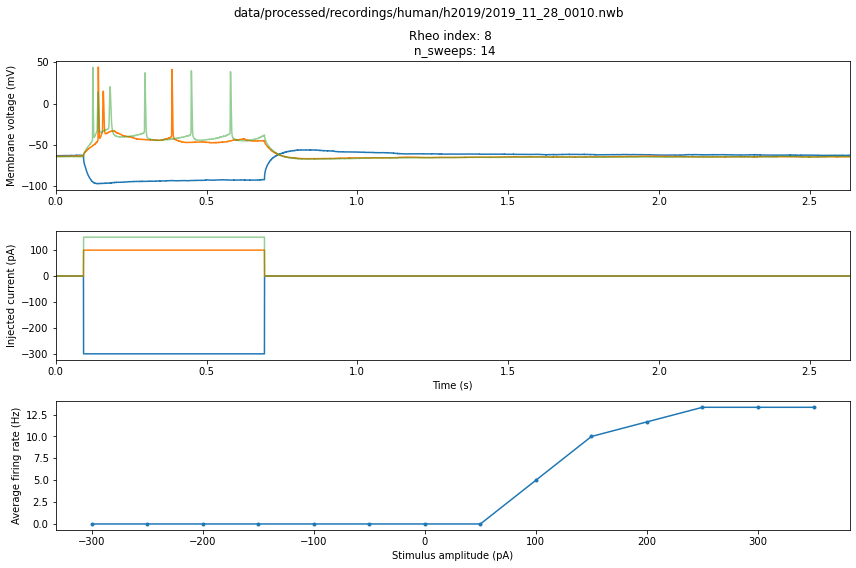

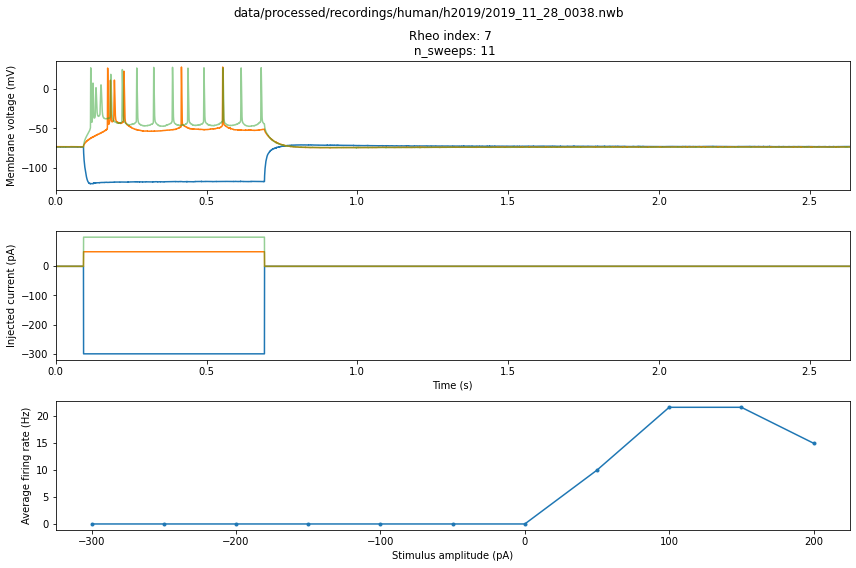

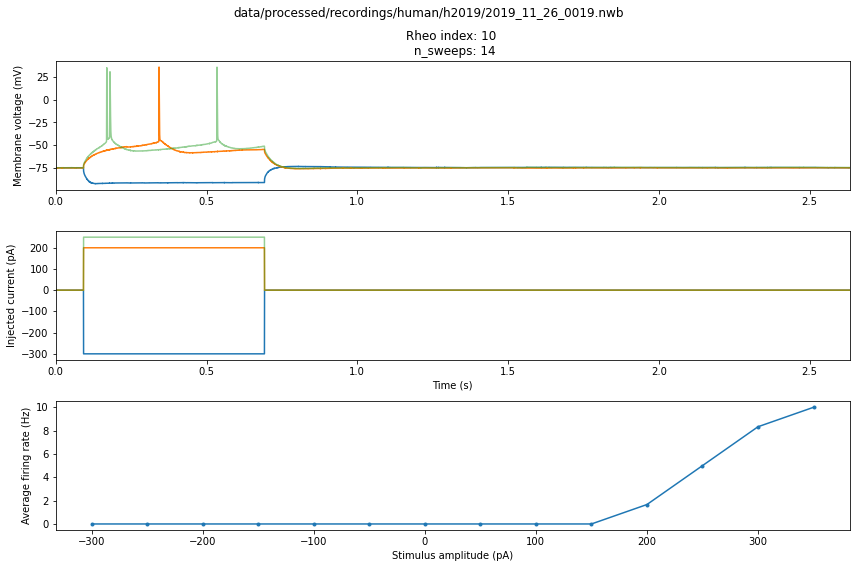

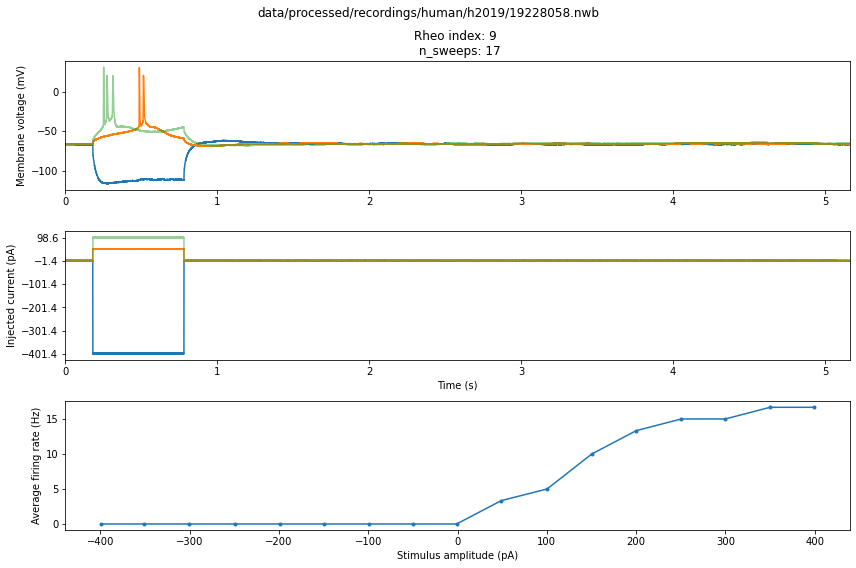

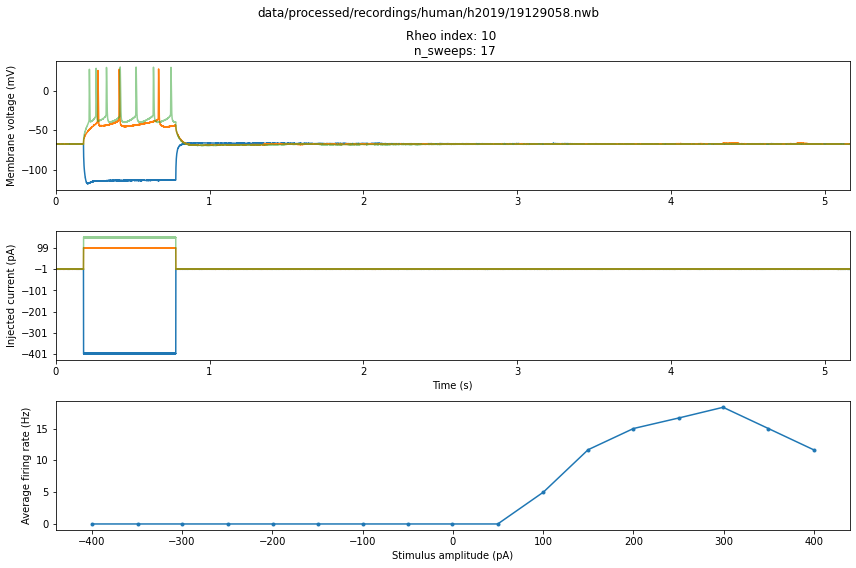

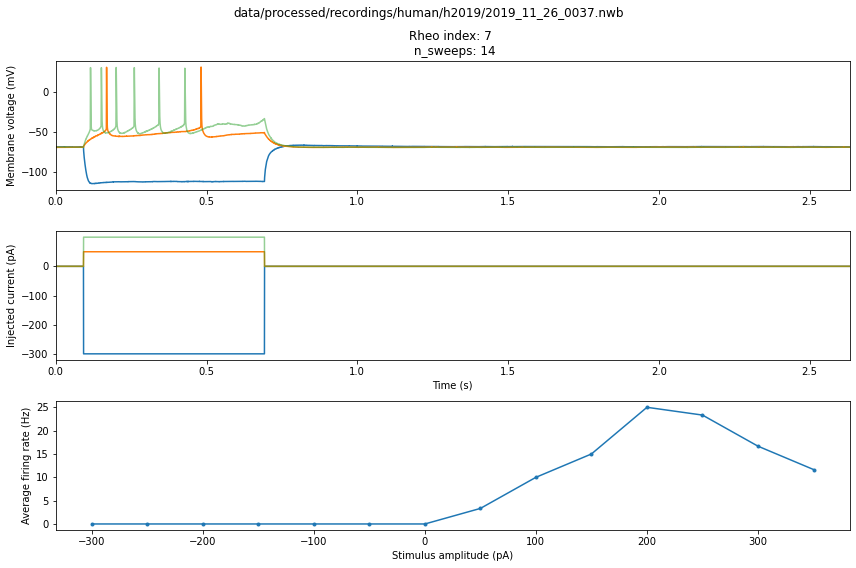

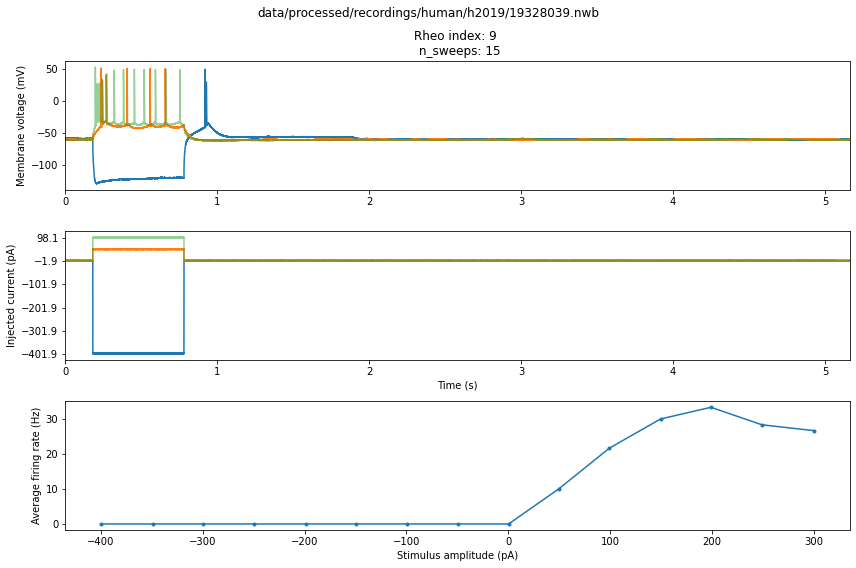

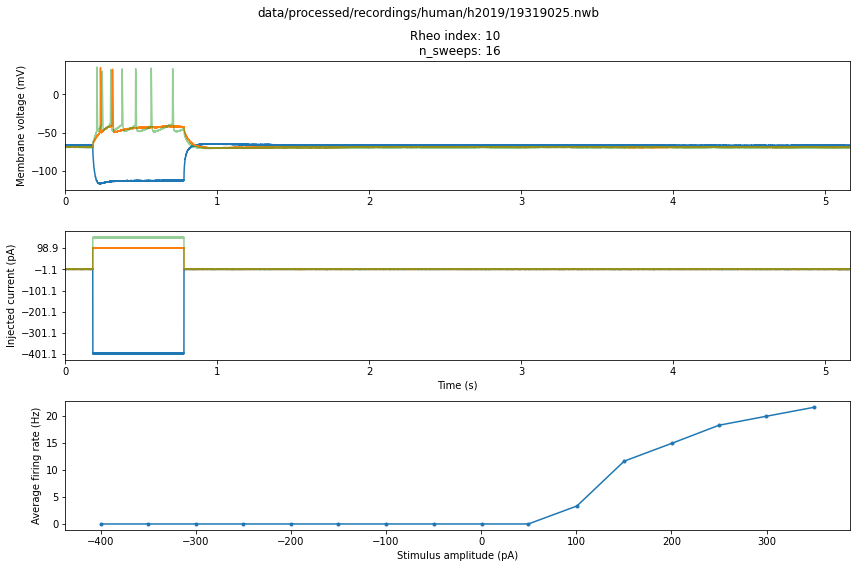

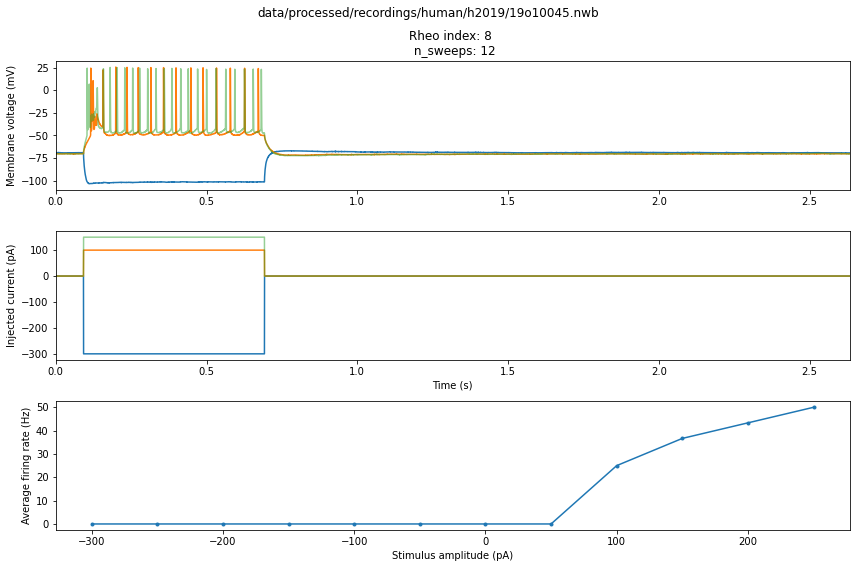

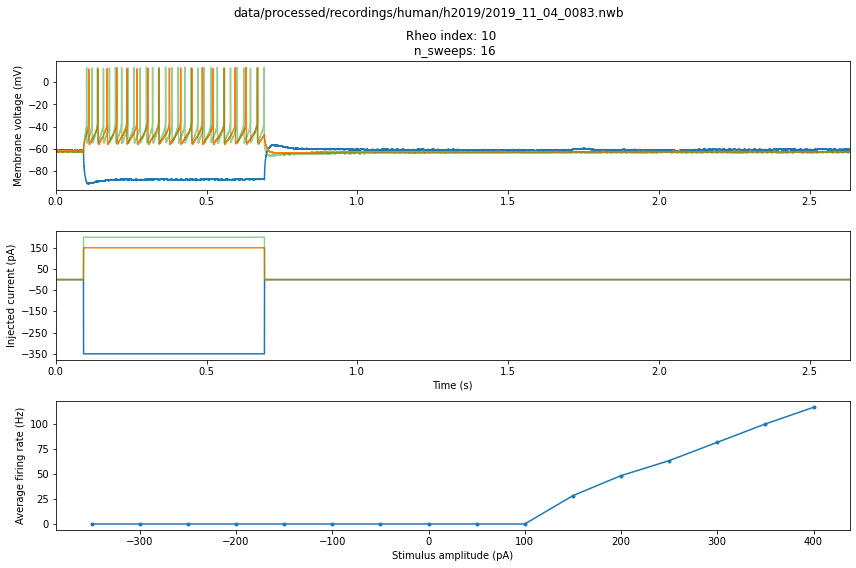

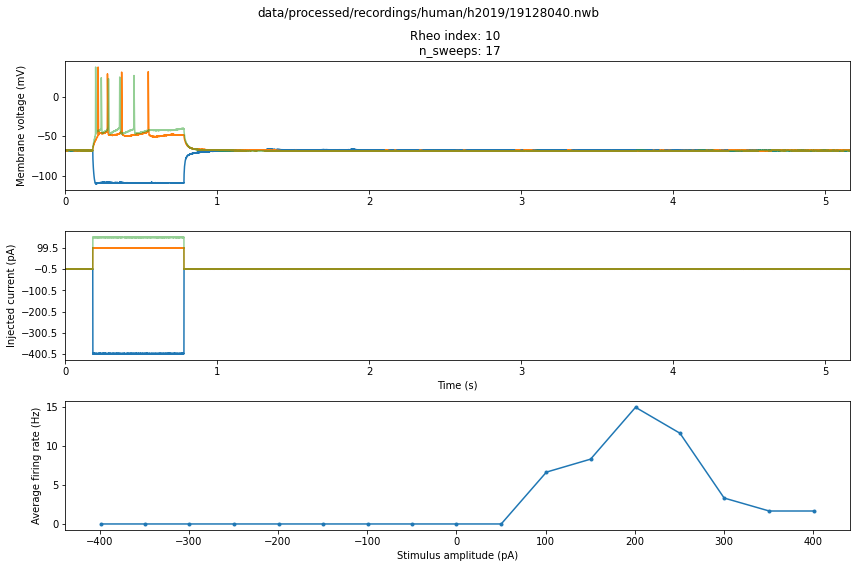

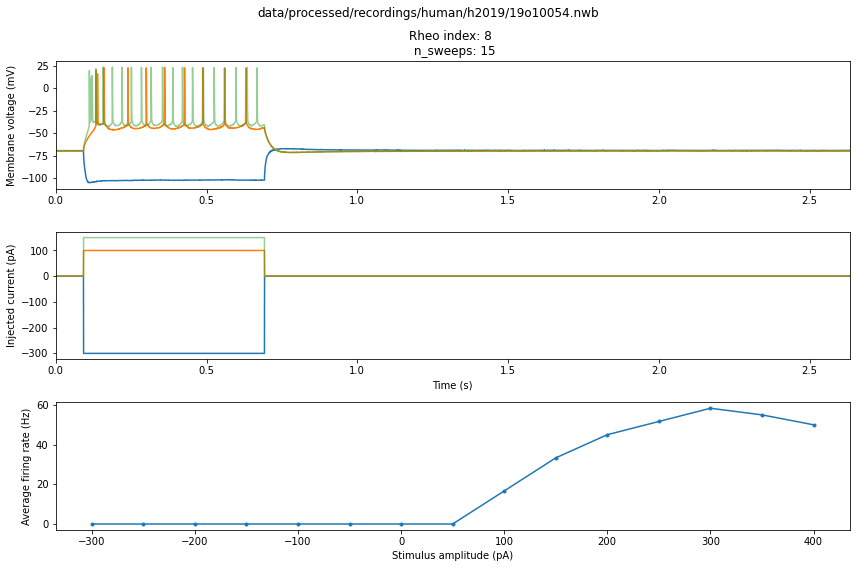

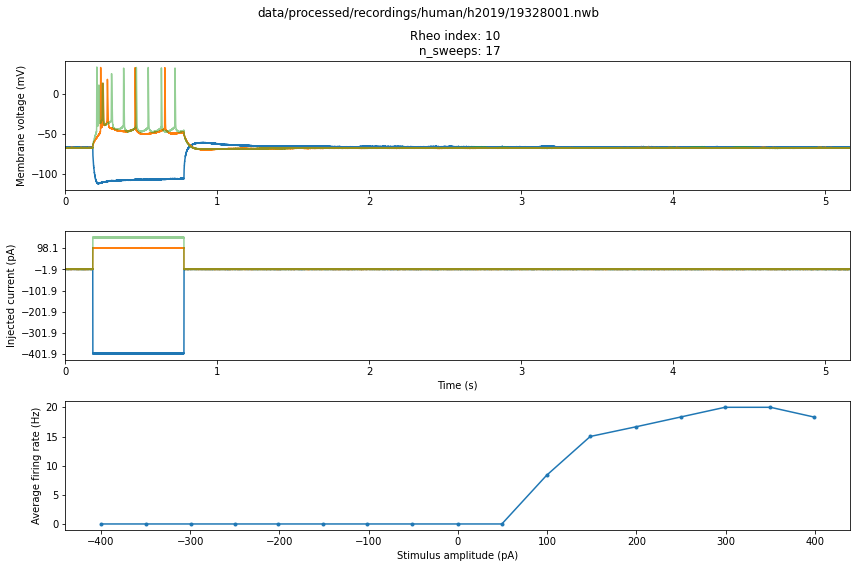

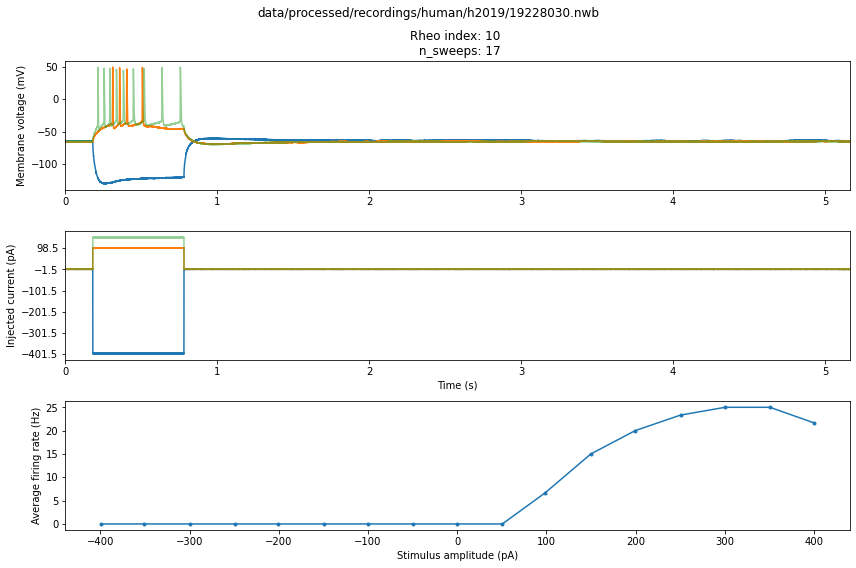

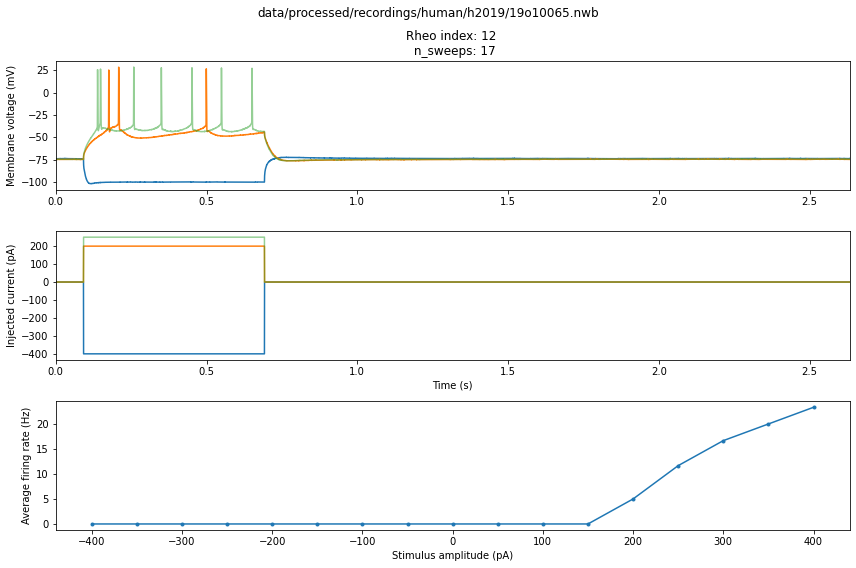

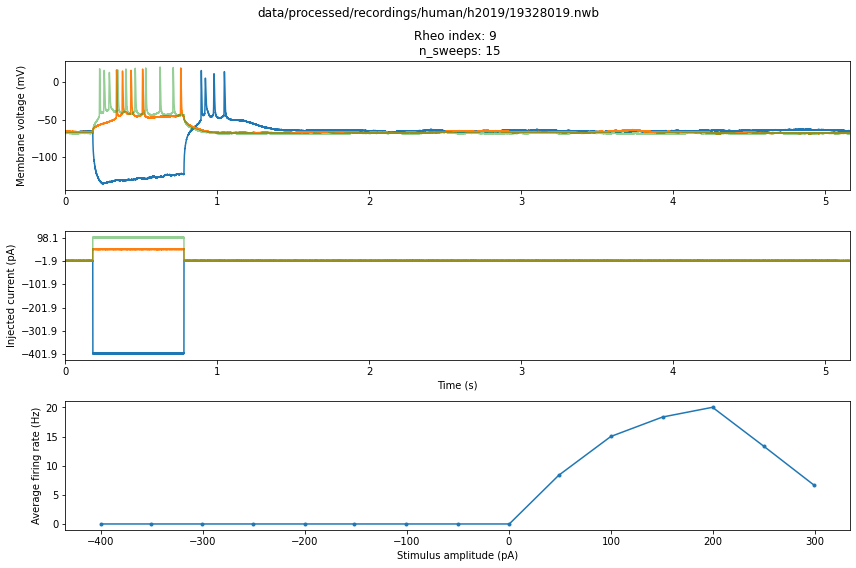

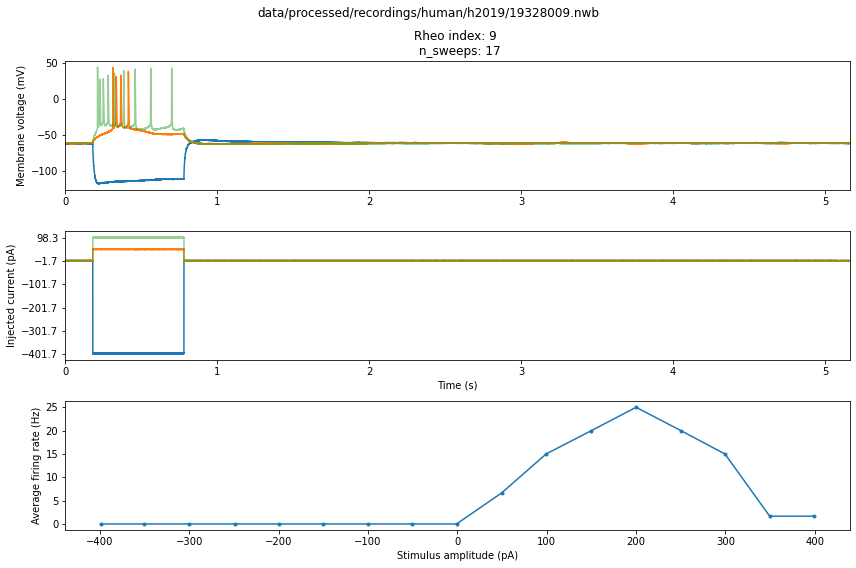

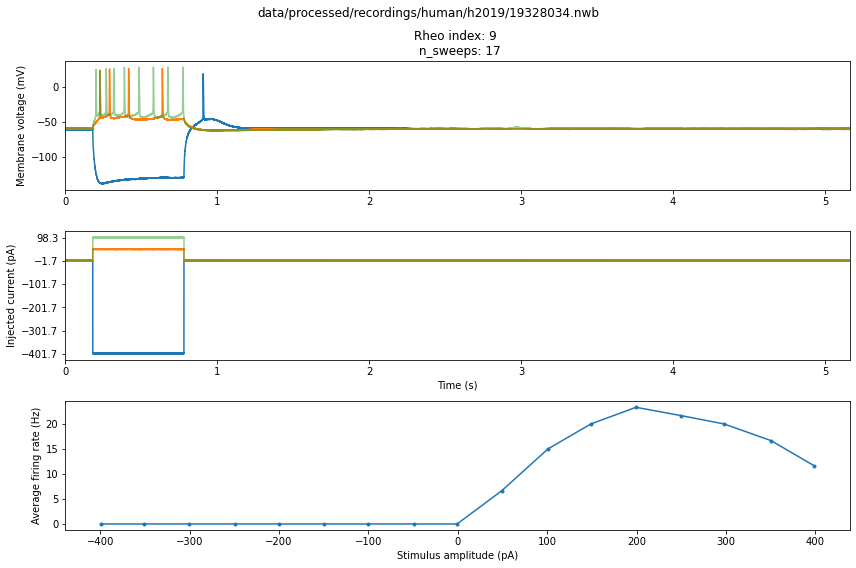

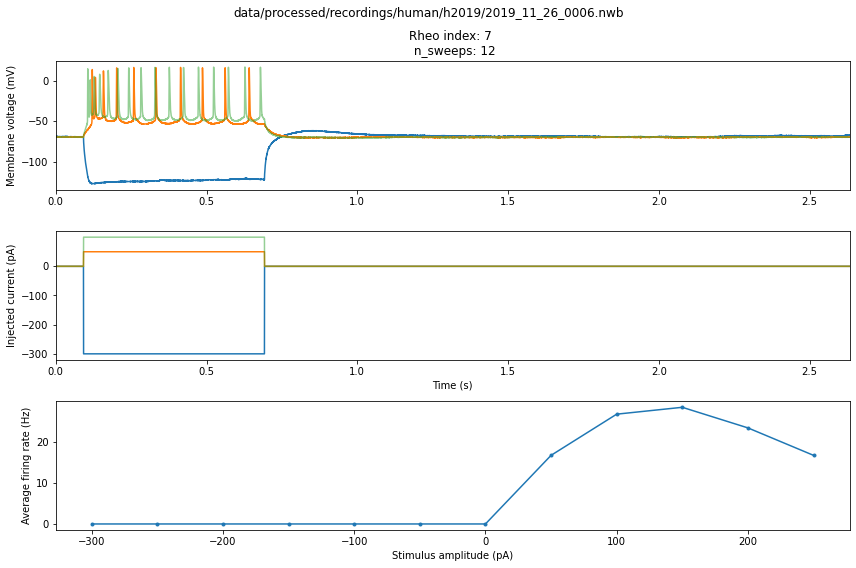

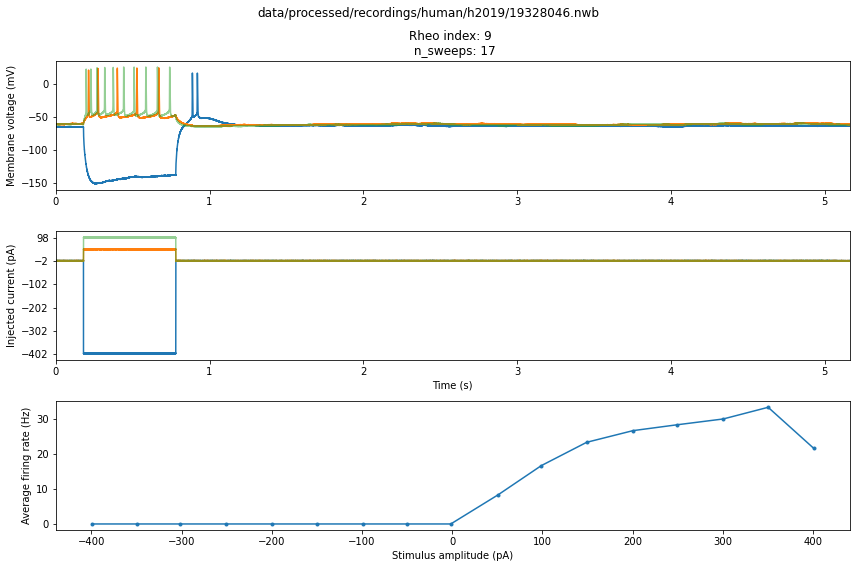

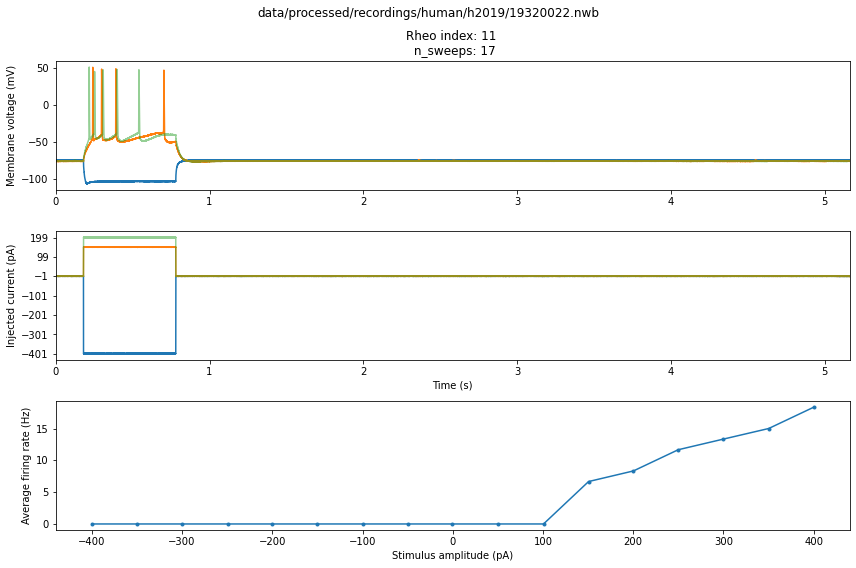

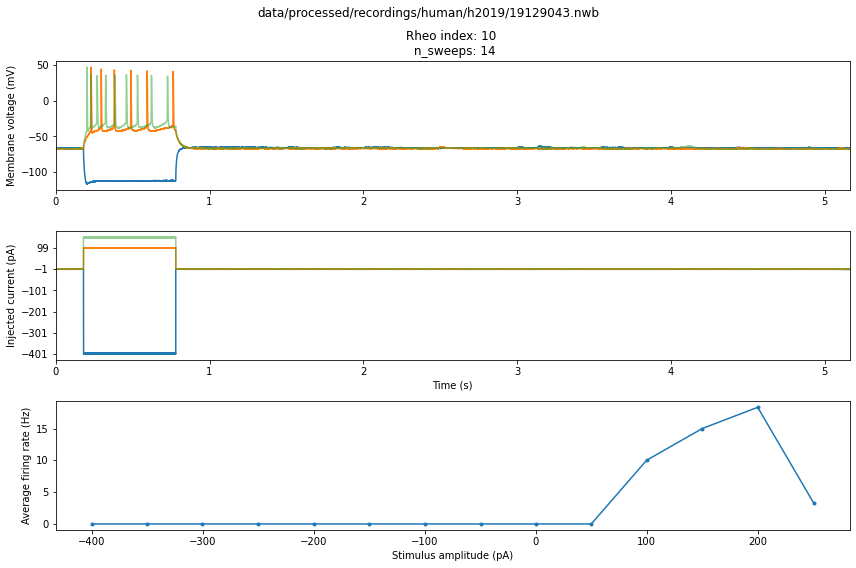

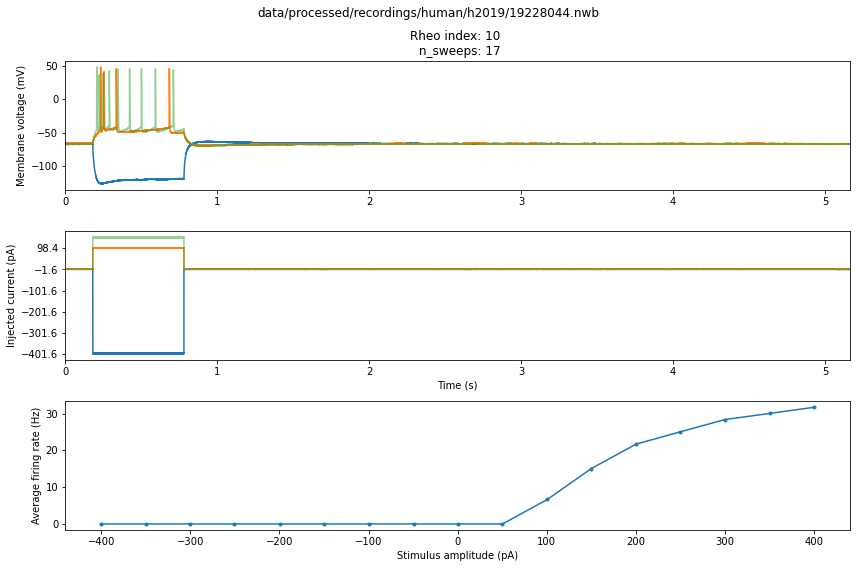

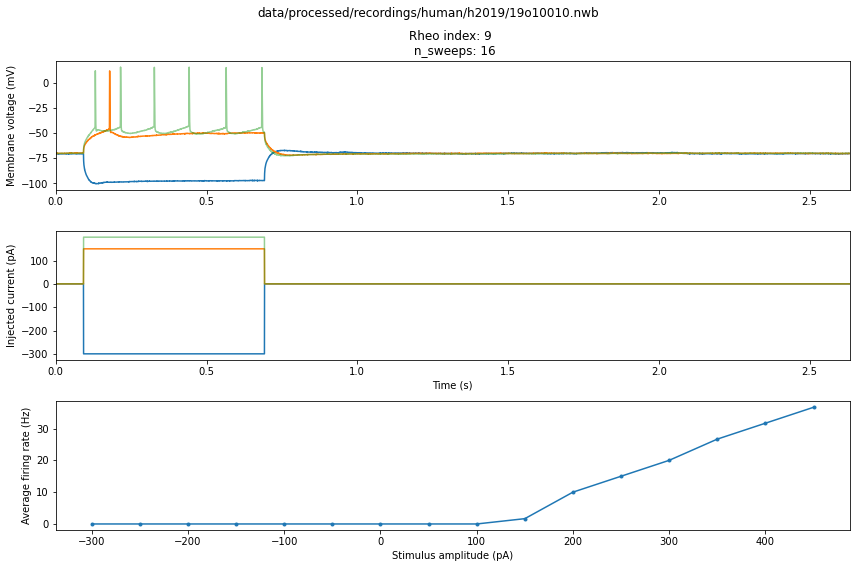

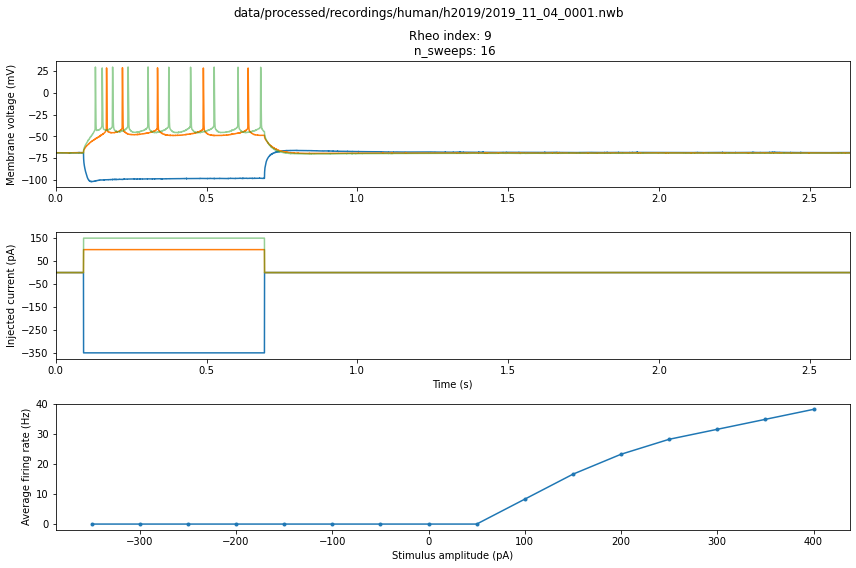

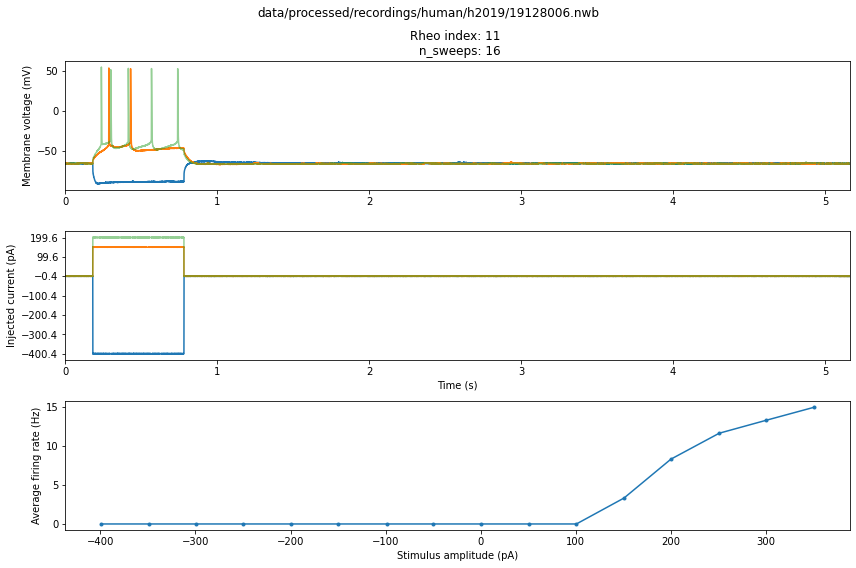

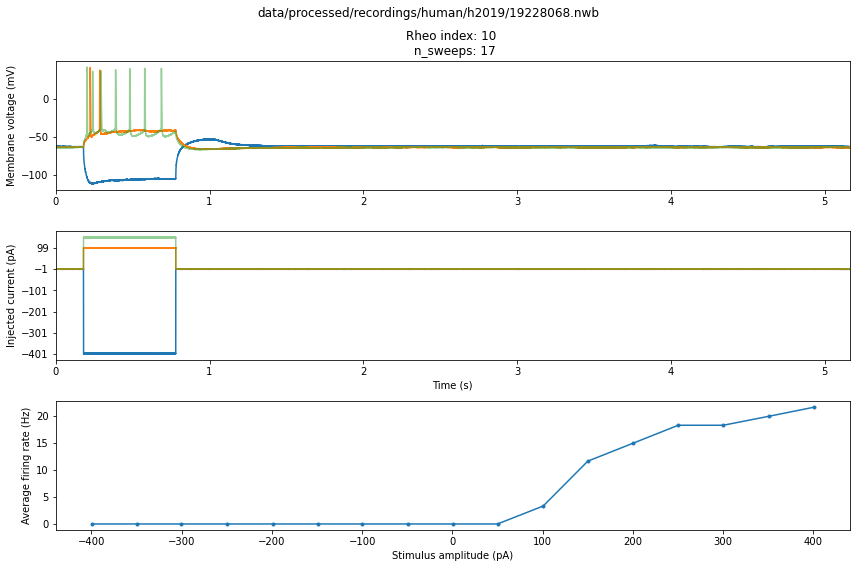

In [10]:
qc_results = []
errors = []
# there are some duplicates in h19 from the natcom paper, skip them here
for i, row in h19[~h19.file_name.isin(natcom.file_name)].iterrows():
    try:
        plot_nwb_QC(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time, save_dir=h19_figs)
        qc_info = QC_V_baseline(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time)
        qc_results.append((row.file_id, *qc_info))
    except (AssertionError, AttributeError, TypeError, FeatureError, ValueError) as e:
        print(f'Error: {e} \n')
        
h19_qc_results = pd.DataFrame(qc_results, columns=col_names).sort_values('max_diff_v_baseline', ascending=False)

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum all

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-pea

INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.

INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:

INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** *

INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:-------------------------

INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)

INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redete

INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: 

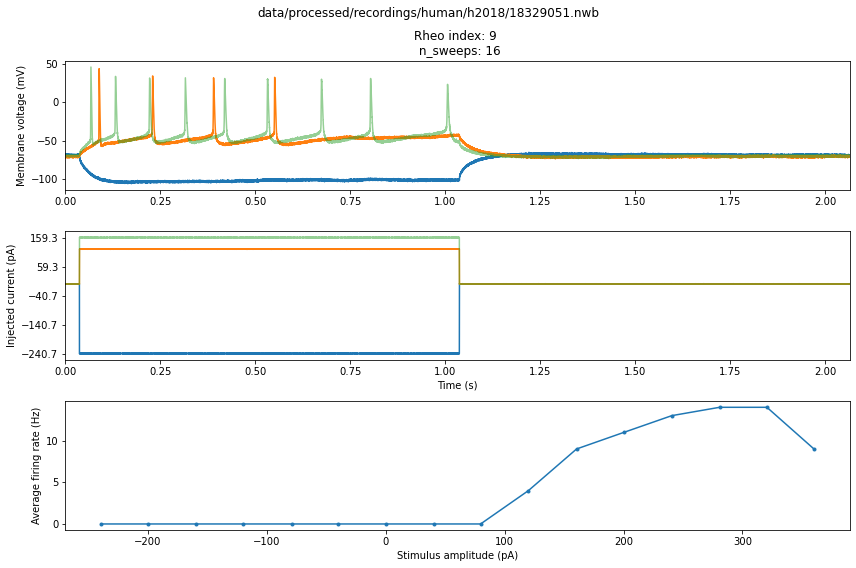

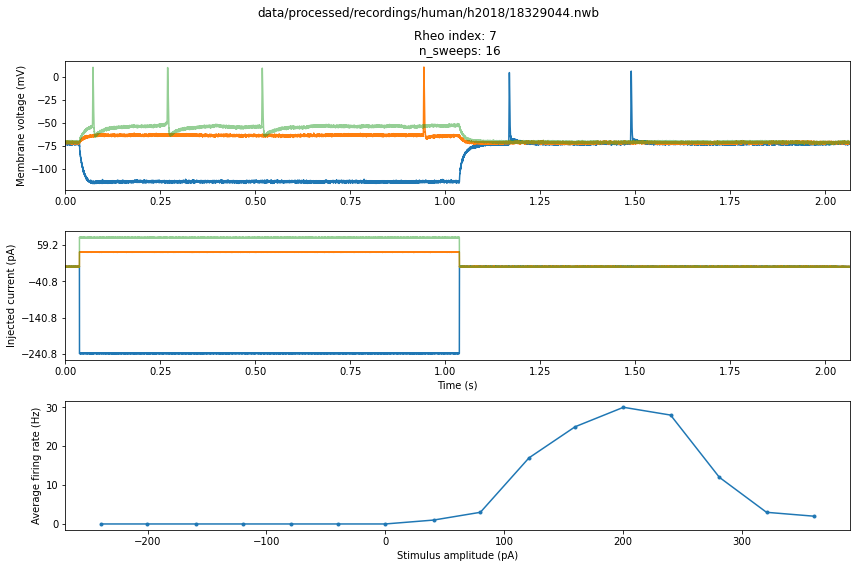

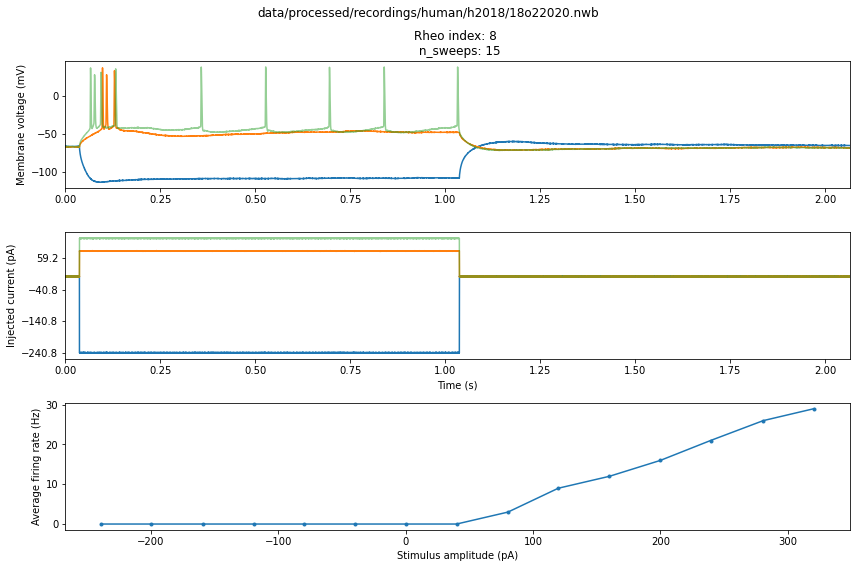

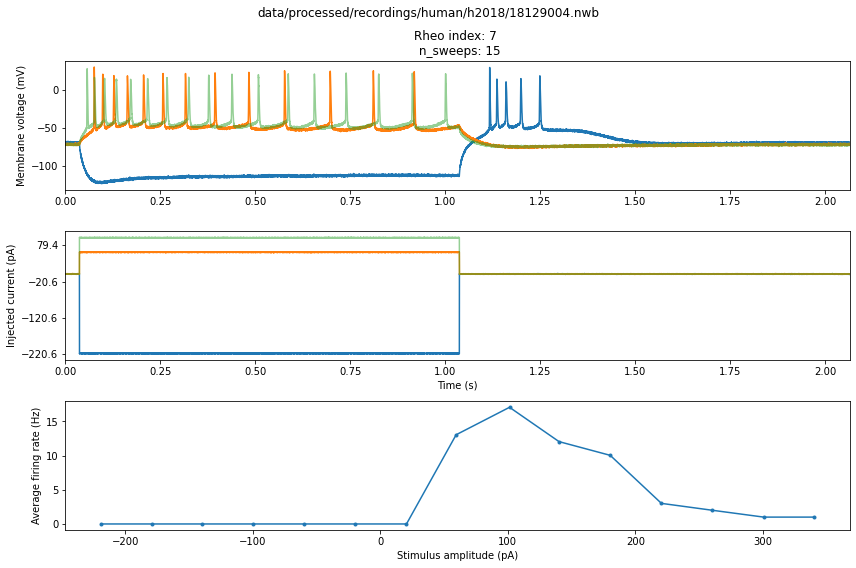

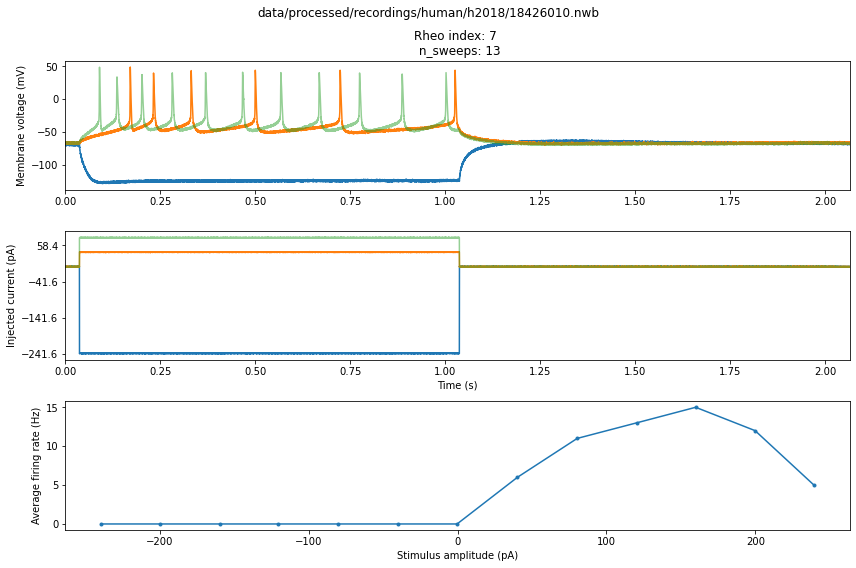

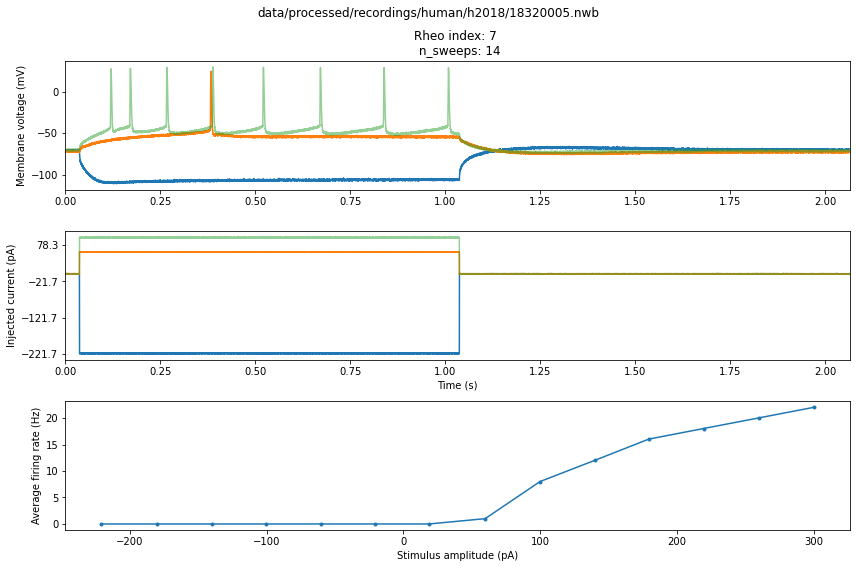

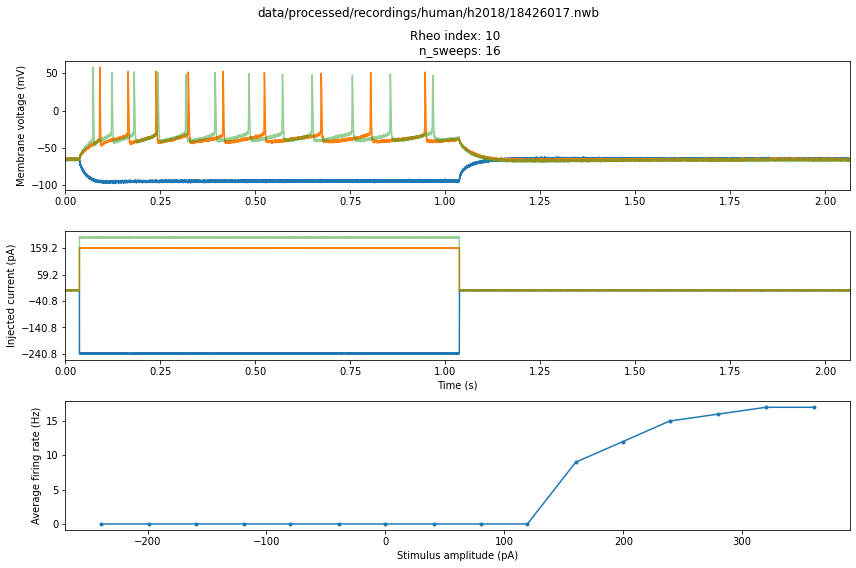

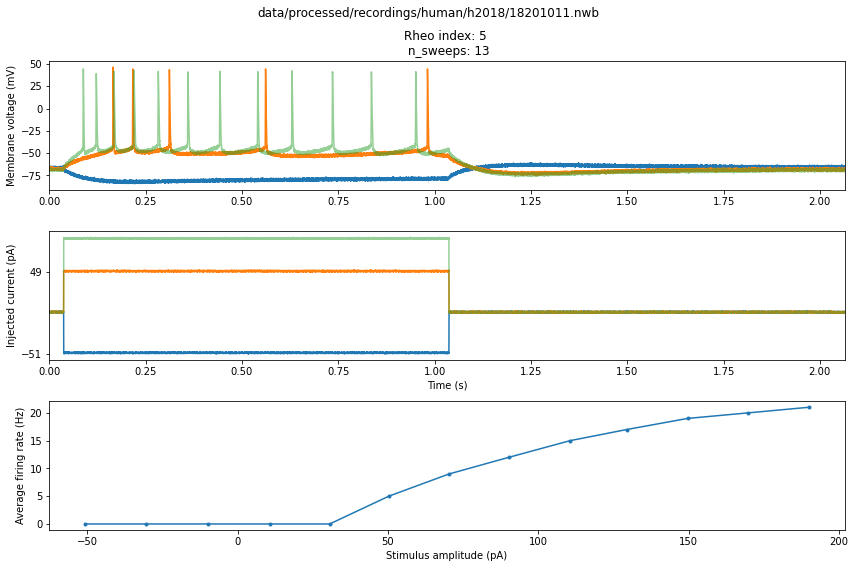

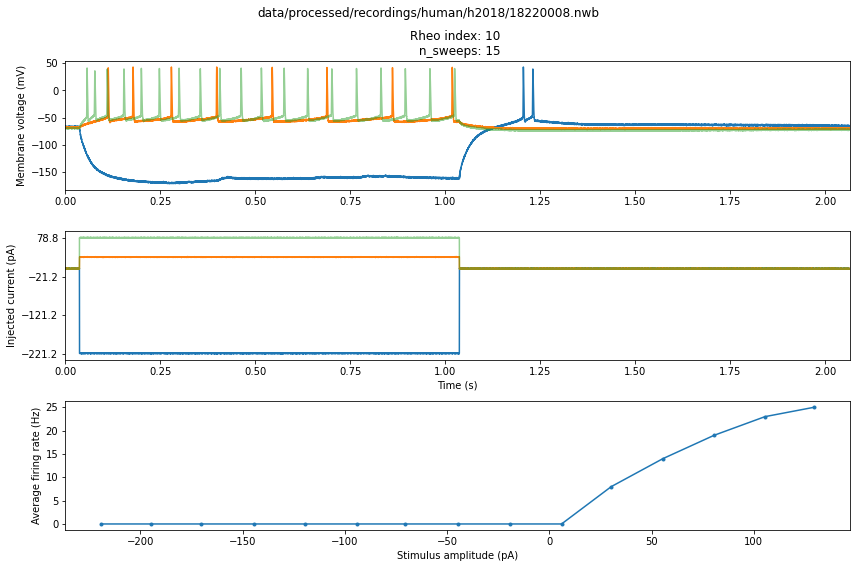

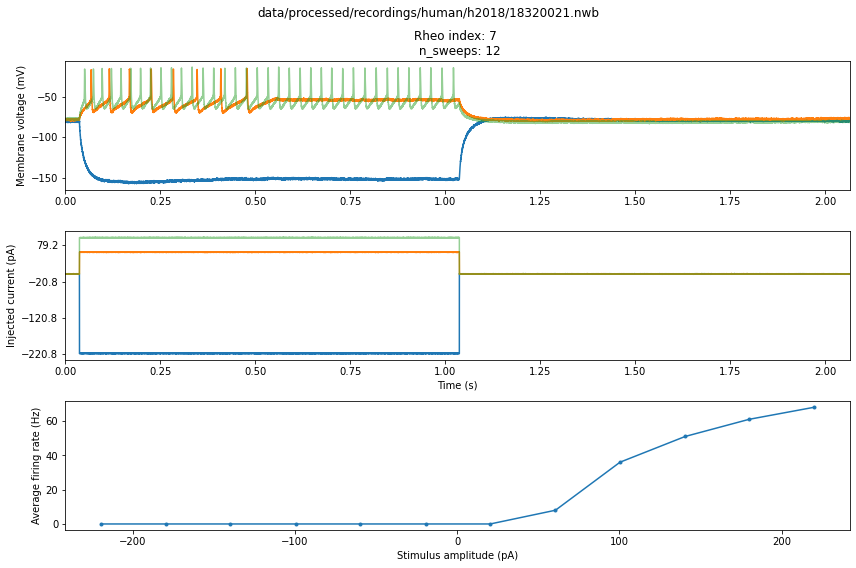

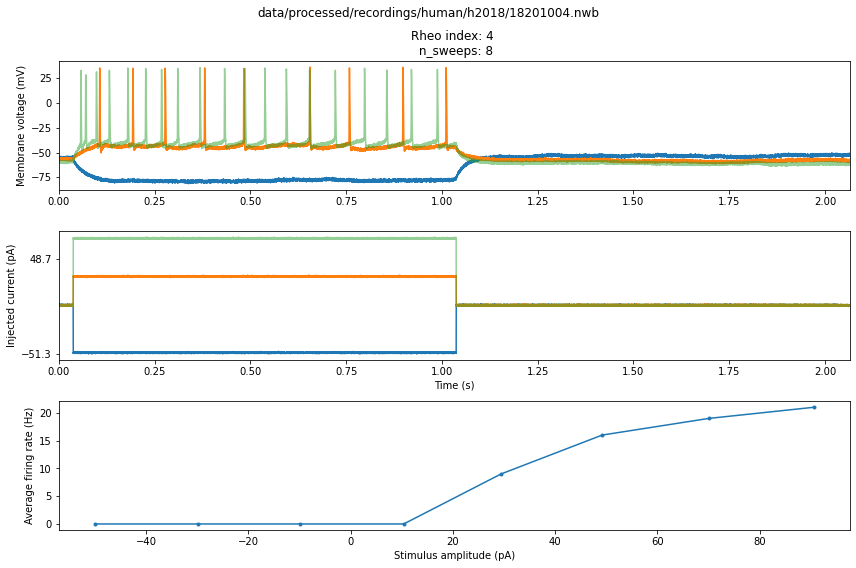

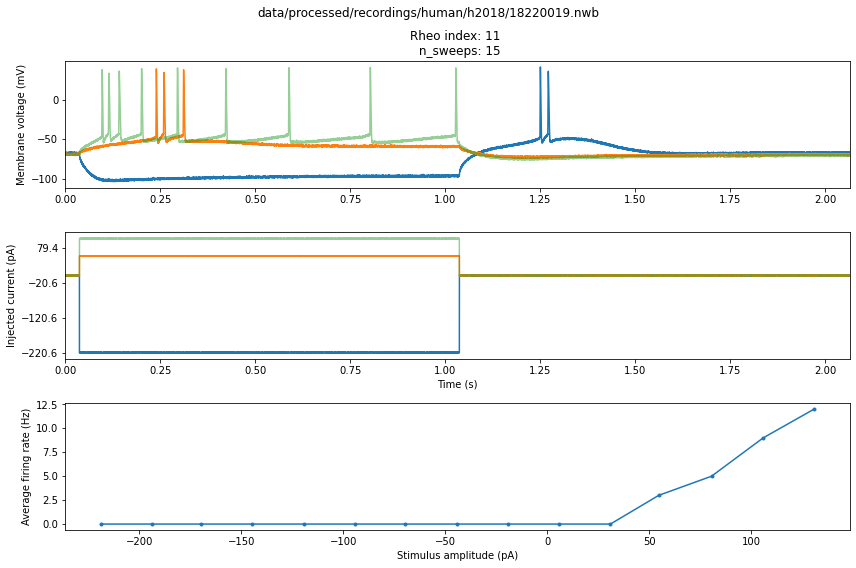

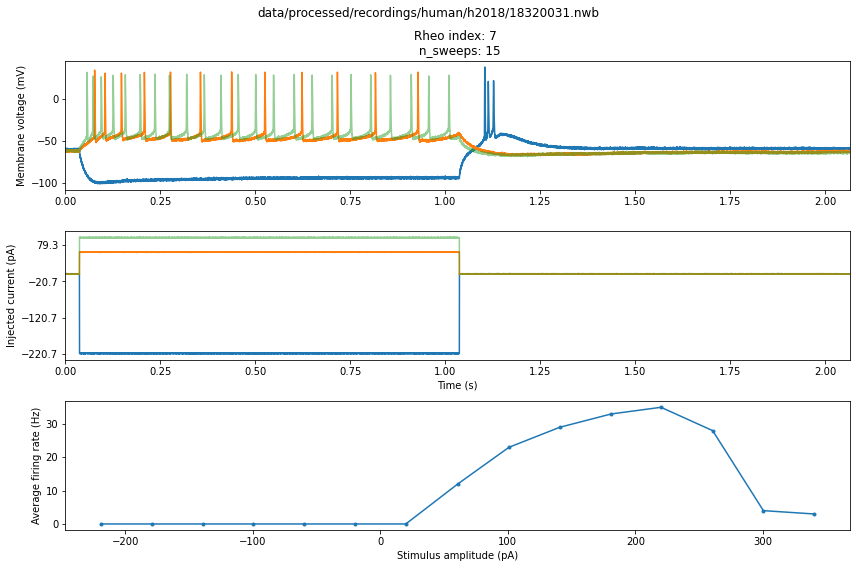

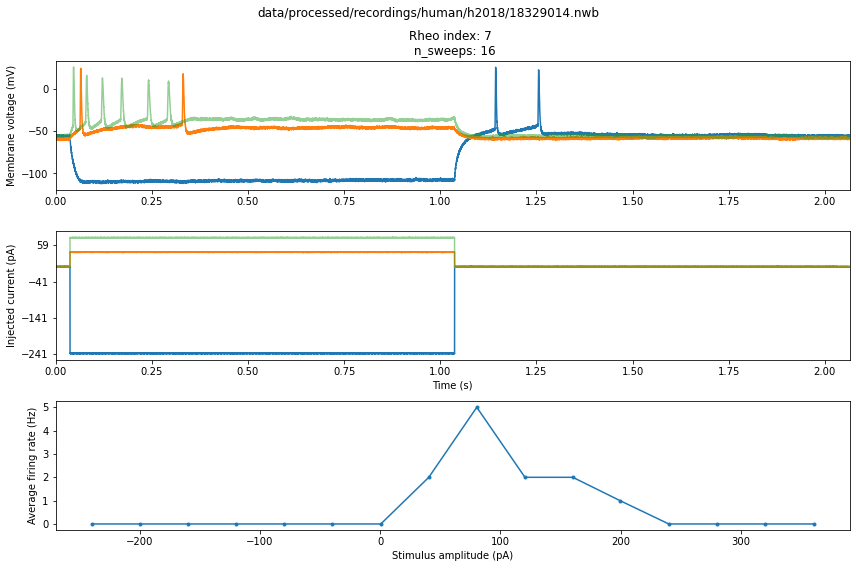

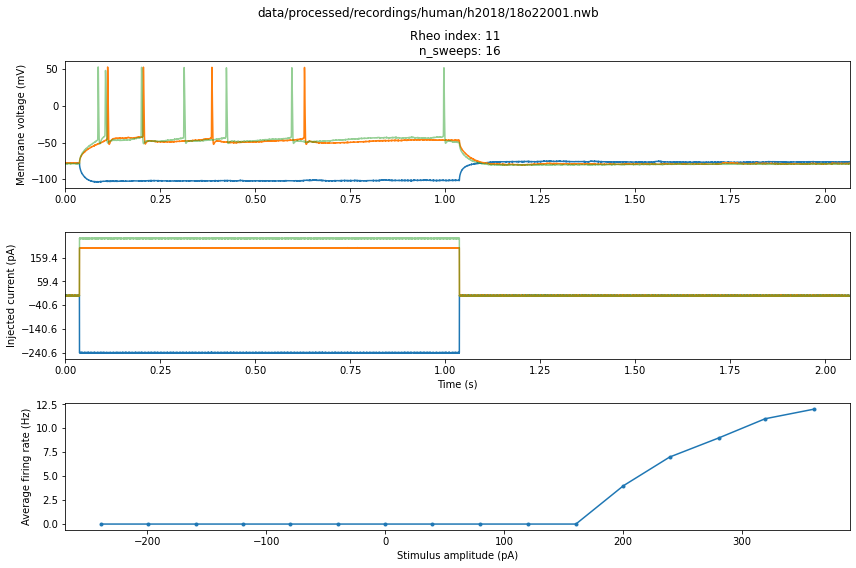

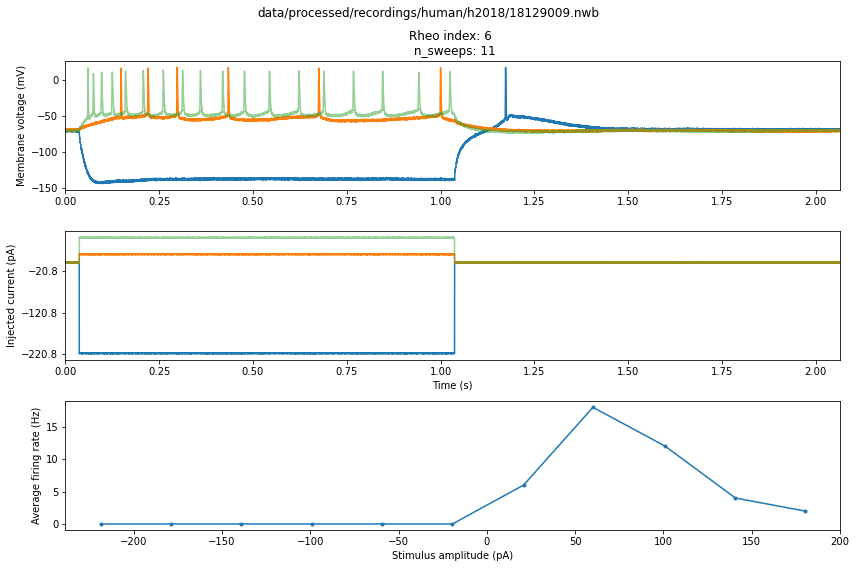

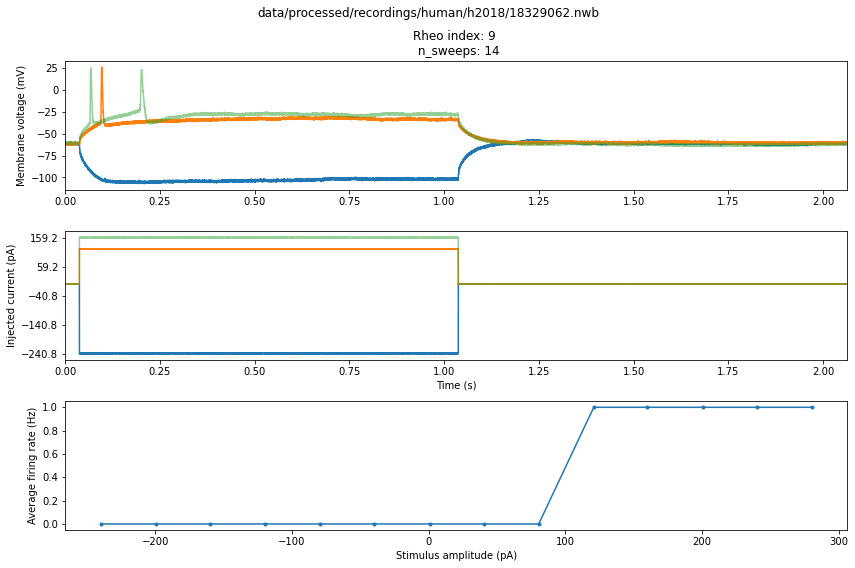

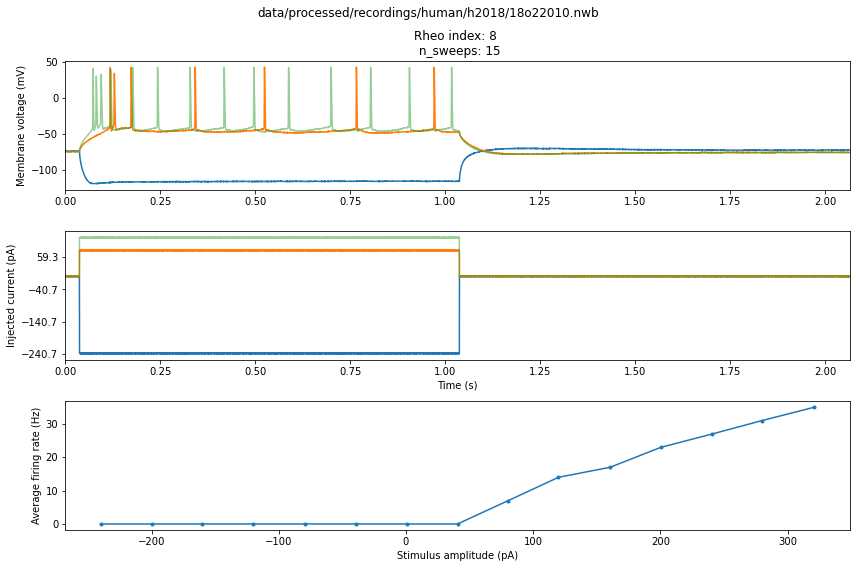

In [11]:
qc_results = []
for i, row in h18.iterrows():
    try:
        plot_nwb_QC(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time, save_dir=h18_figs)
        qc_info = QC_V_baseline(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time)
        qc_results.append((row.file_id, *qc_info))
    except (AssertionError, AttributeError, TypeError, FeatureError, ValueError) as e:
        print(f'Error: {e} \n')
        
h18_qc_results = pd.DataFrame(qc_results, columns=col_names).sort_values('max_diff_v_baseline', ascending=False)

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[w

INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:----------------------------------------

INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ra

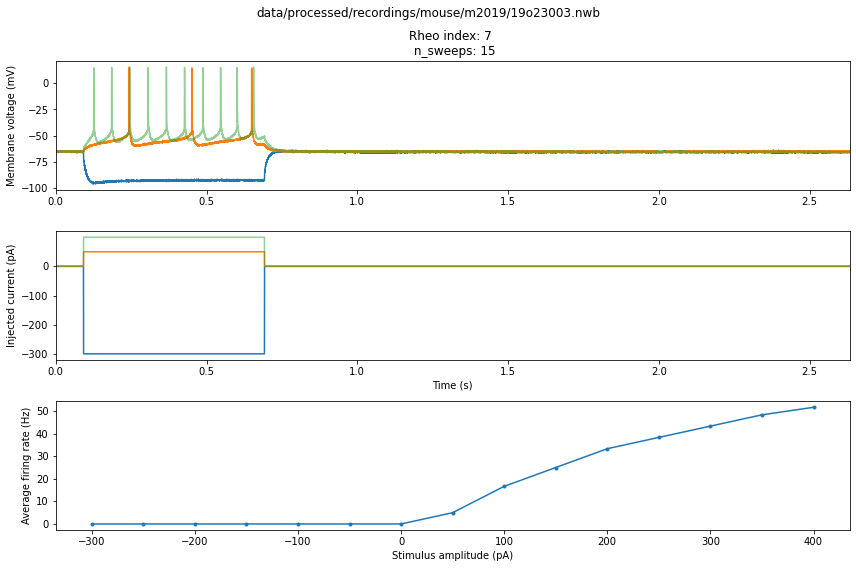

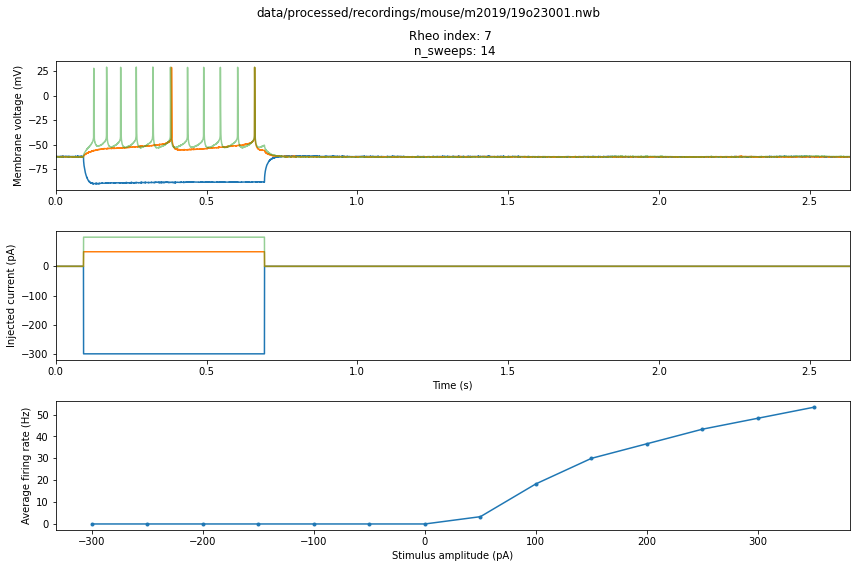

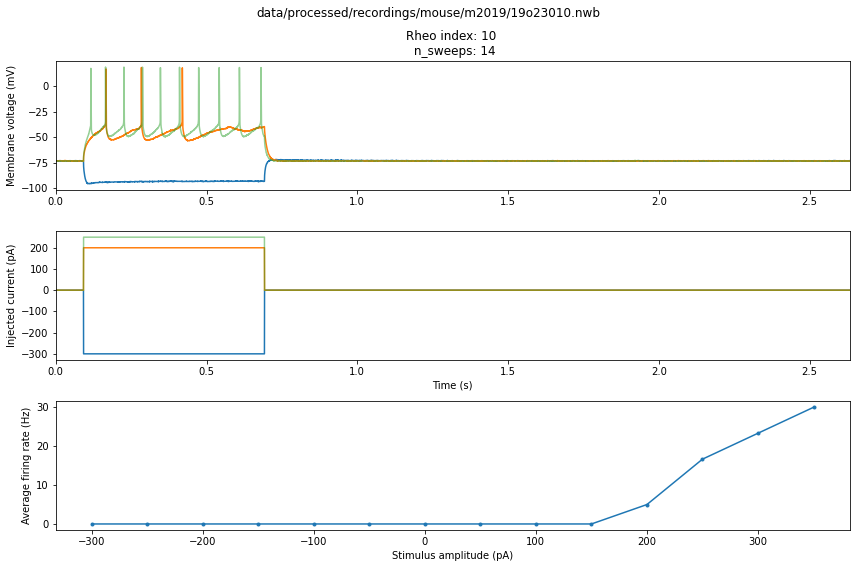

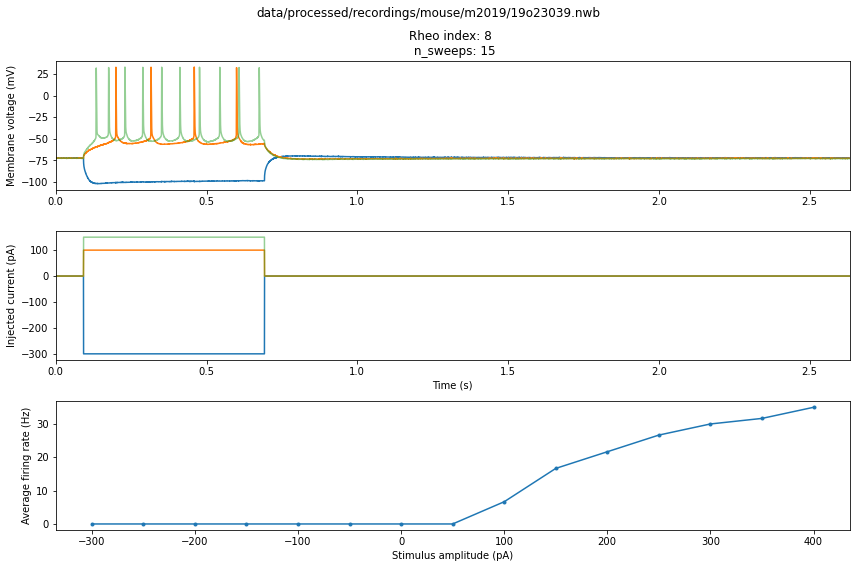

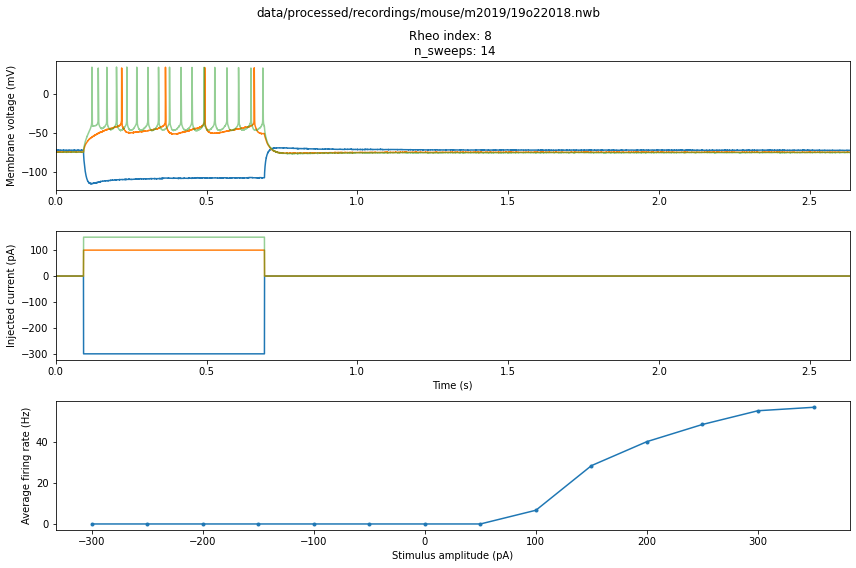

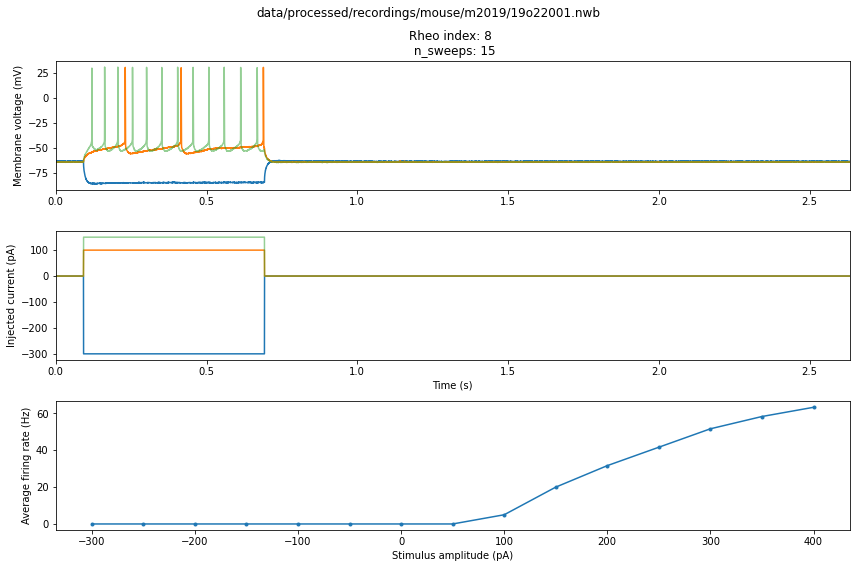

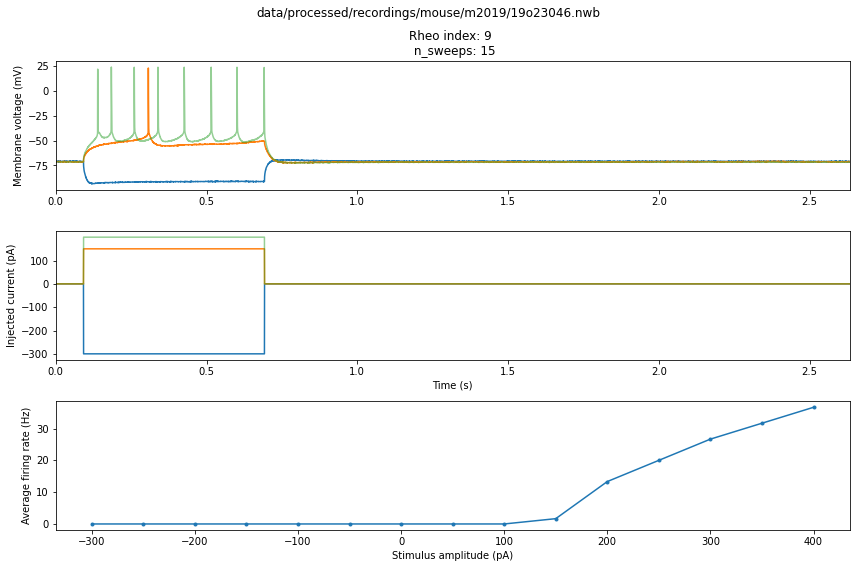

In [12]:
qc_results = []
for i, row in m19.iterrows():
    try:
        plot_nwb_QC(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time, save_dir=m19_figs)
        qc_info = QC_V_baseline(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time)
        qc_results.append((row.file_id, *qc_info))
    except (AssertionError, AttributeError, TypeError, FeatureError, ValueError) as e:
        print(f'Error: {e} \n')
        
m19_qc_results = pd.DataFrame(qc_results, columns=col_names).sort_values('max_diff_v_baseline', ascending=False)

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-pea

INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.

INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.

INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus_protocol_analysis.py:219: RuntimeWarning: Mean of empty slice
  features["tau"] = np.nanmean(calc_subthresh_features['tau'])
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warning

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus_protocol_analysis.py:219: RuntimeWarning: Mean of empty slice
  features["tau"] = np.nanmean(calc_subthresh_features['tau'])


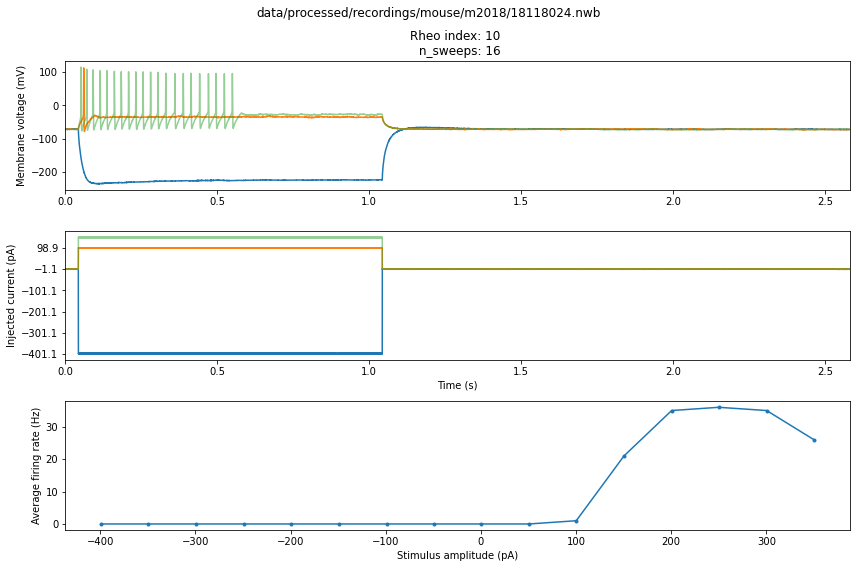

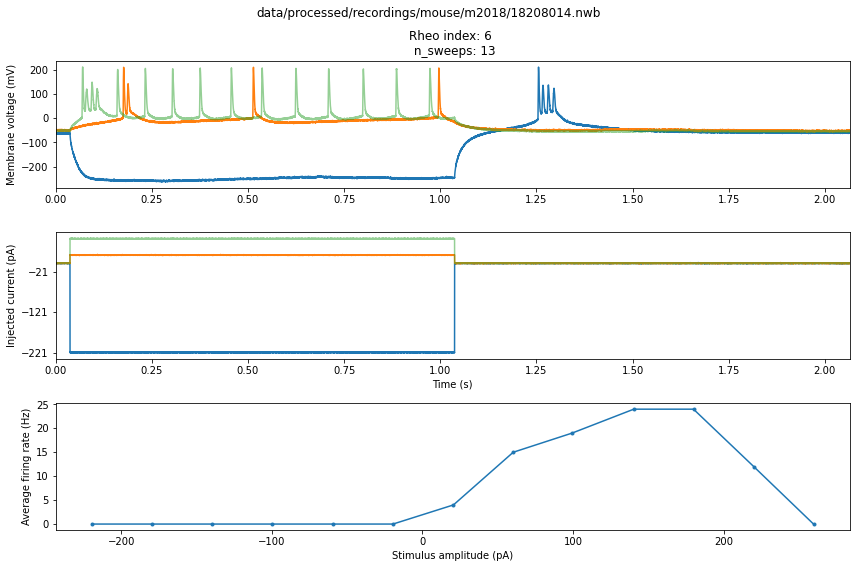

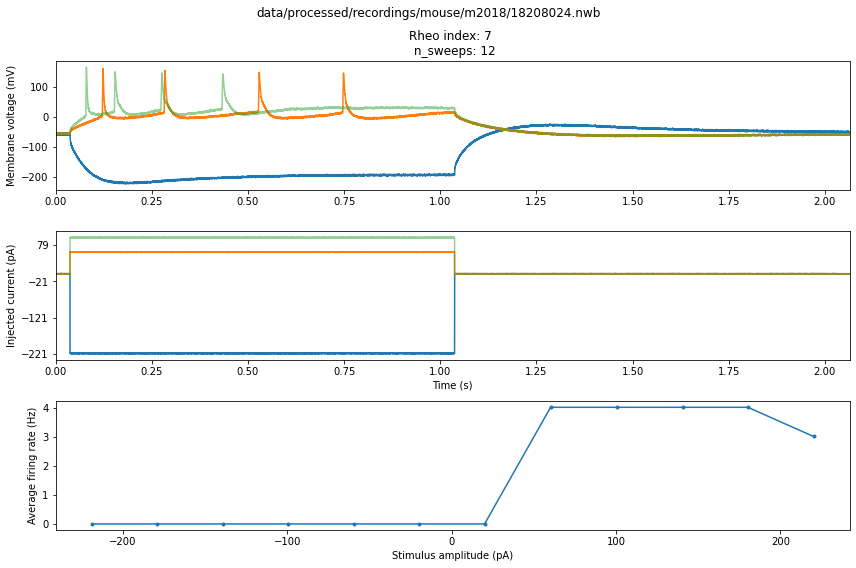

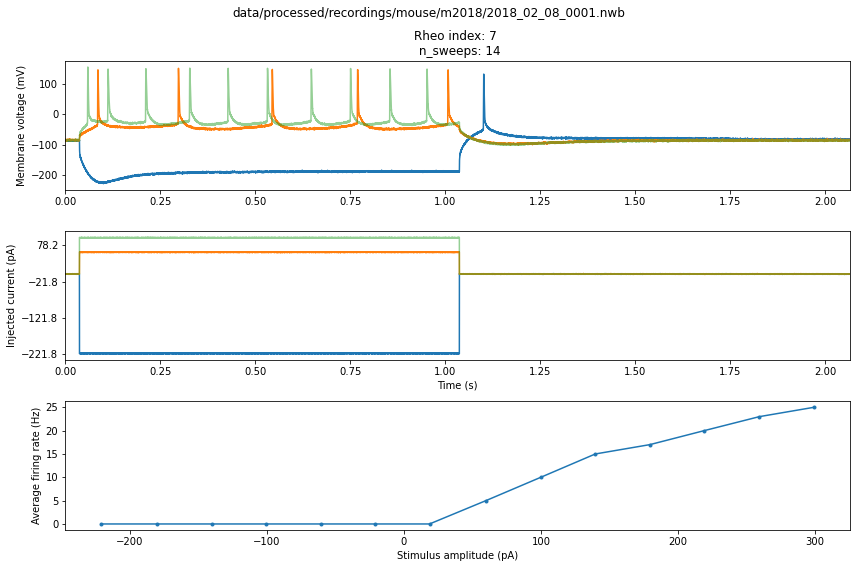

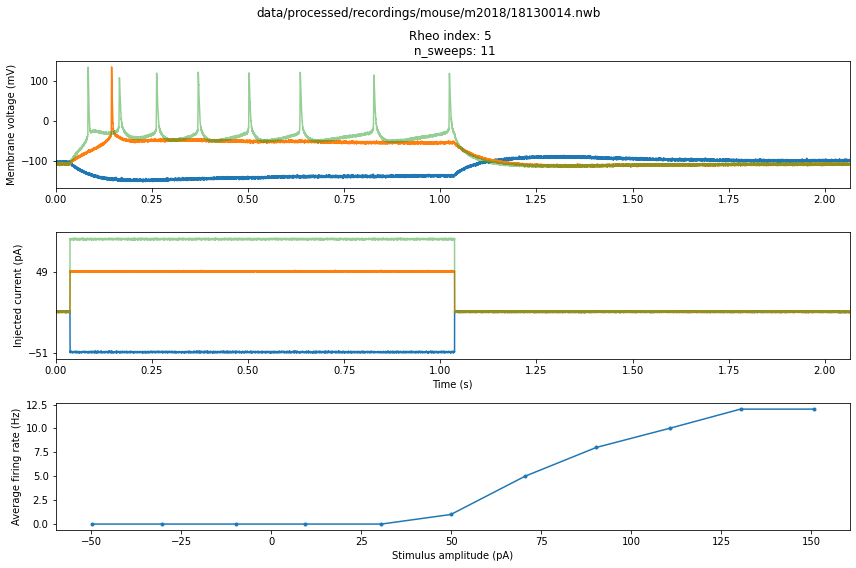

In [13]:
qc_results = []
for i, row in m18.iterrows():
    try:
        plot_nwb_QC(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time, baseline_interval=0.0001, save_dir=m18_figs)
        qc_info = QC_V_baseline(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time)
        qc_results.append((row.file_id, *qc_info))
    except (AssertionError, AttributeError, TypeError, FeatureError, ValueError) as e:
        print(f'Error: {e} \n')
        
m18_qc_results = pd.DataFrame(qc_results, columns=col_names).sort_values('max_diff_v_baseline', ascending=False)

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ****

INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3

INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[w

INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/subthresh_features.py:147: RuntimeWarning: invalid value encountered in float_scalars
  sag = (v_peak_avg - v_steady) / (v_peak_avg - v_baseline)


Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-pea

INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:----------------------

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalcu

INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/subthresh_features.py:147: RuntimeWarning: invalid value encountered in float_scalars
  sag = (v_peak_avg - v_steady) / (v_peak_avg - v_baseline)


Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[w

INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/

INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ra

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/subthresh_features.py:147: RuntimeWarning: in

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

Error: Cannot fit f-I curve slope with less than two sweeps 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[w

INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:----------------------------------------------------

INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/subthresh_features.py:147: RuntimeWarning: invalid value encountered in float_scalars
  sag = (v_peak_avg - v_steady) / (v_peak_avg - v_baseline)


Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-pea

Error: <class 'tuple'> is not a stimulus or response PatchClampSeries 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-pea

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ****

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find 

INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:----------------------------------------

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:roo

INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users

INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
IN

INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** L

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
IN

INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:----------------------------------------

INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A

INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need t

Error: <class 'tuple'> is not a stimulus or response PatchClampSeries 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-pea

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
IN

INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipf

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[w

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squar

Error: No spiking long square sweeps, cannot compute cell features. 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

Error: <class 'tuple'> is not a stimulus or response PatchClampSeries 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephy

INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------

Error: <class 'tuple'> is not a stimulus or response PatchClampSeries 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Curve fit for membrane time const

INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/

INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could no

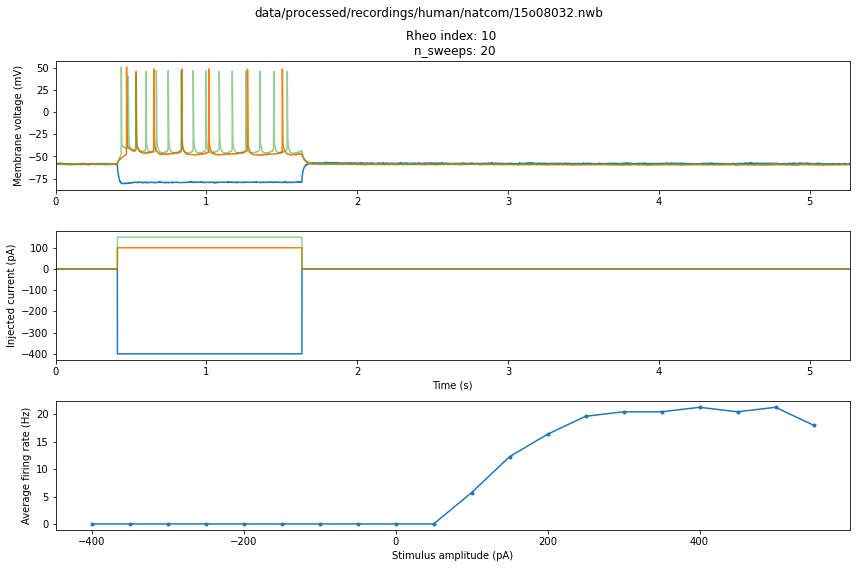

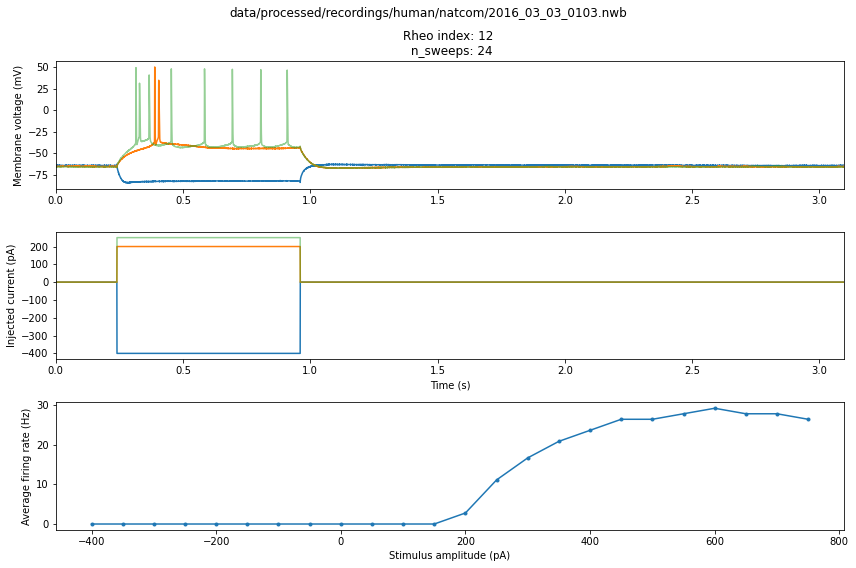

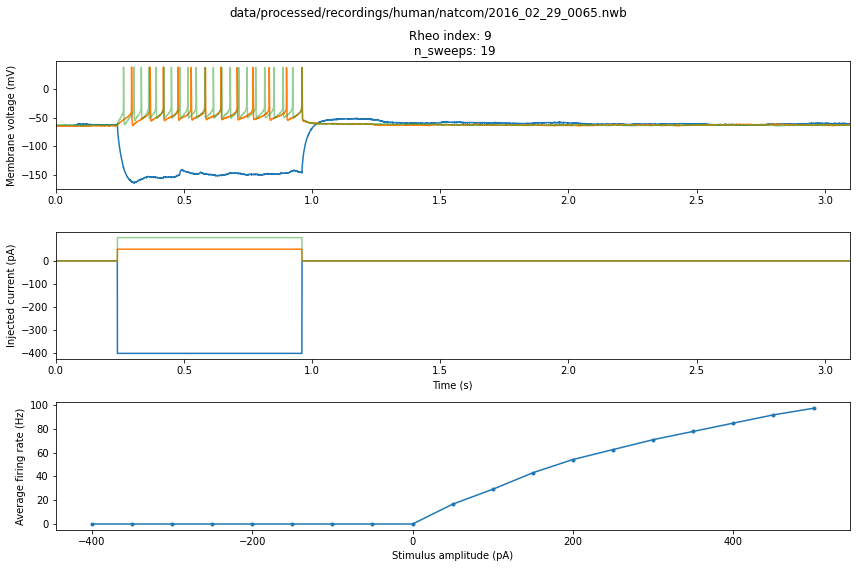

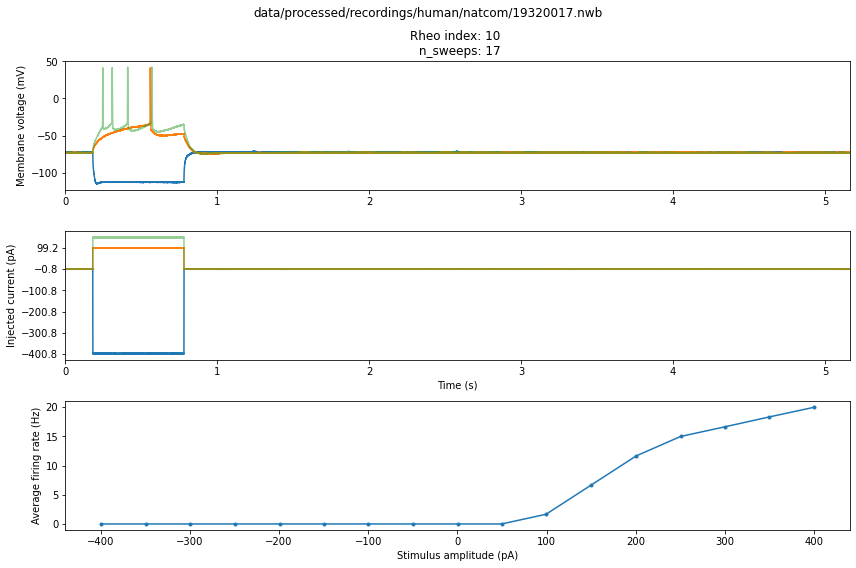

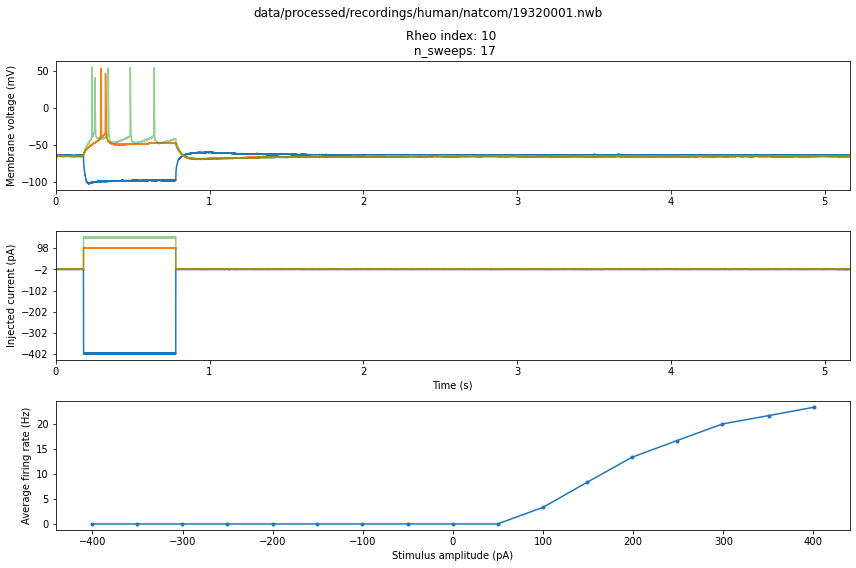

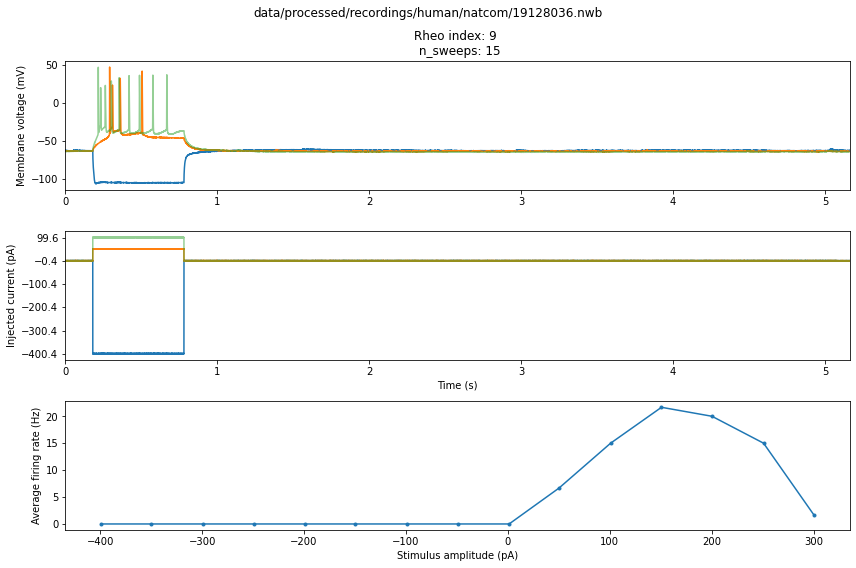

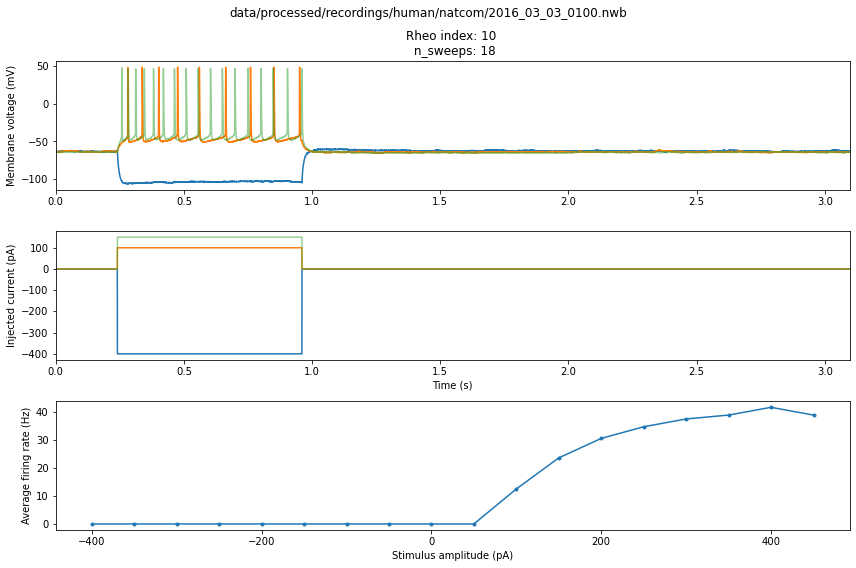

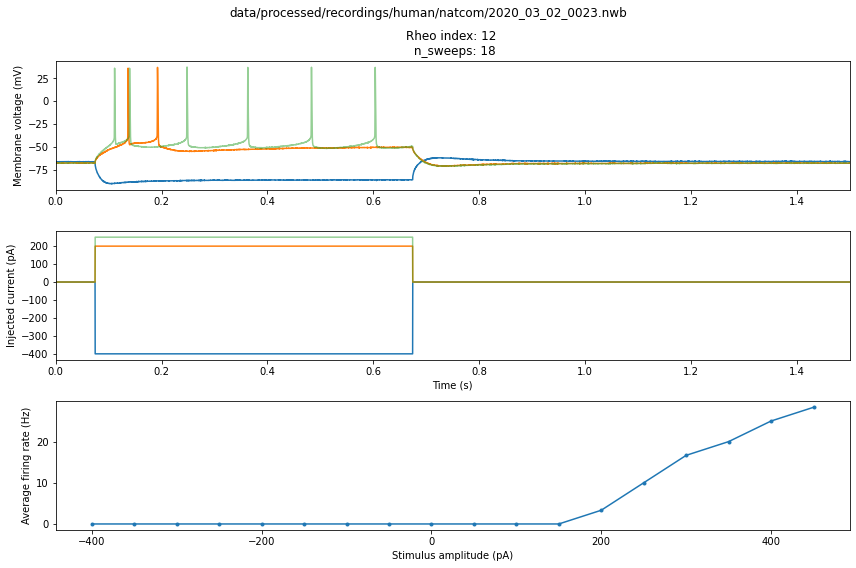

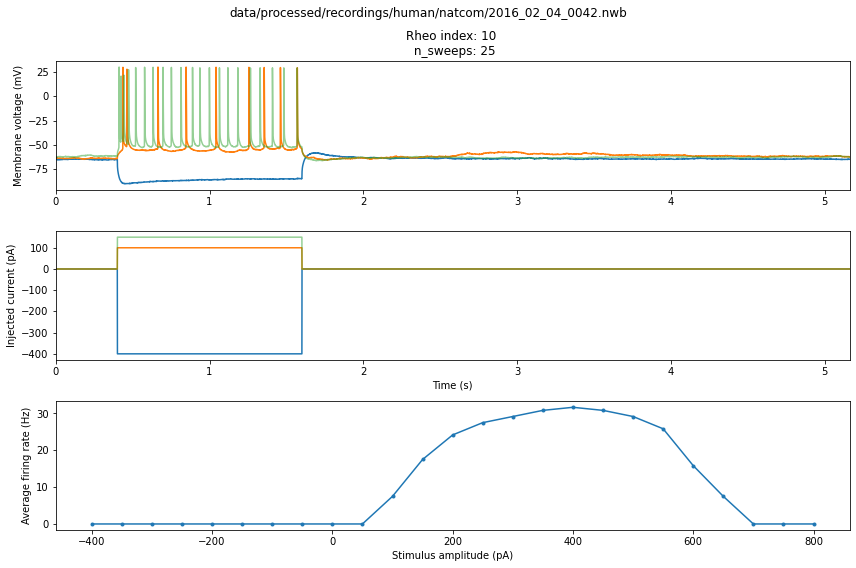

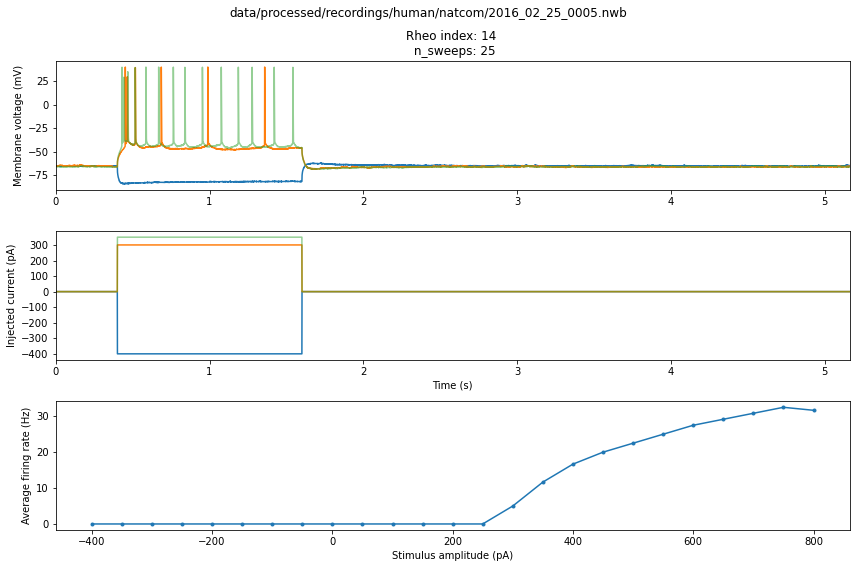

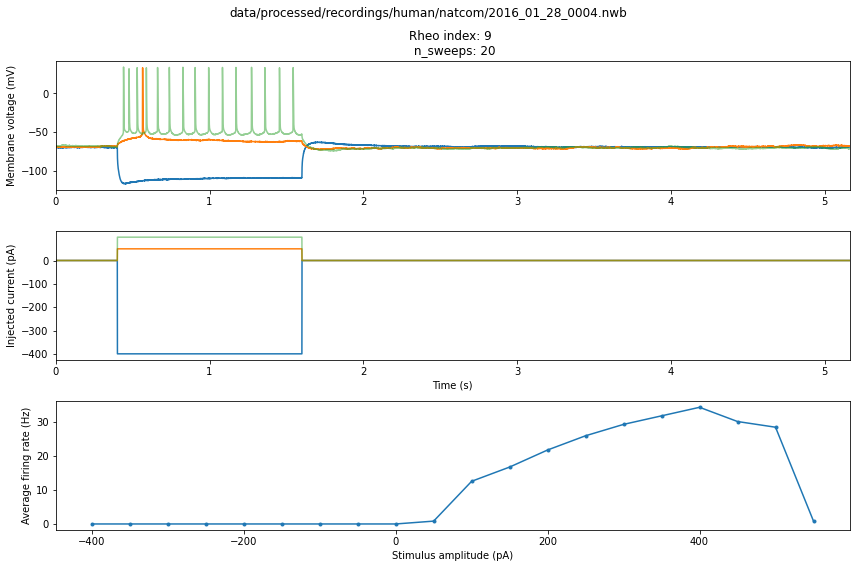

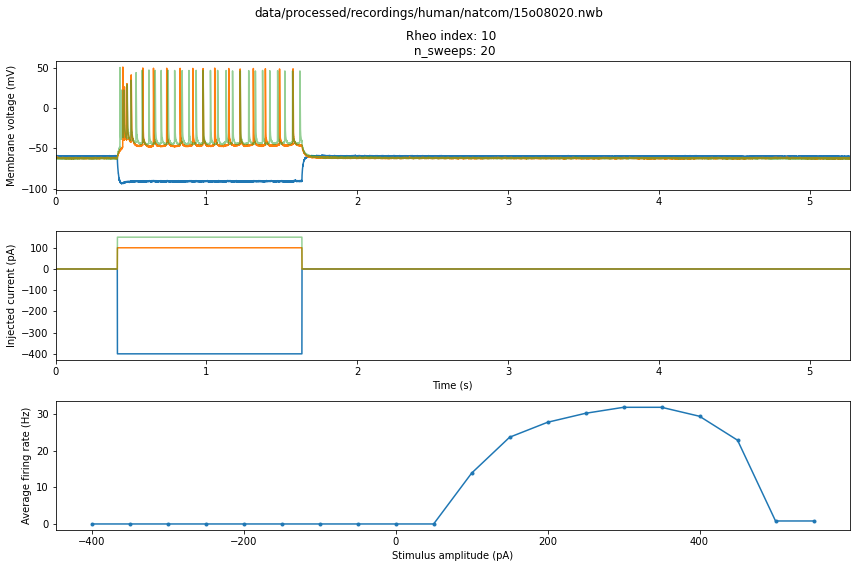

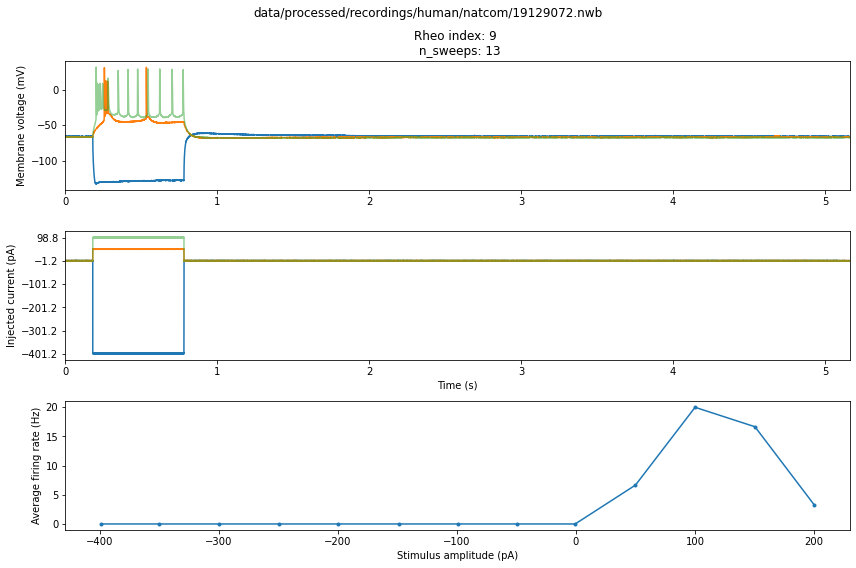

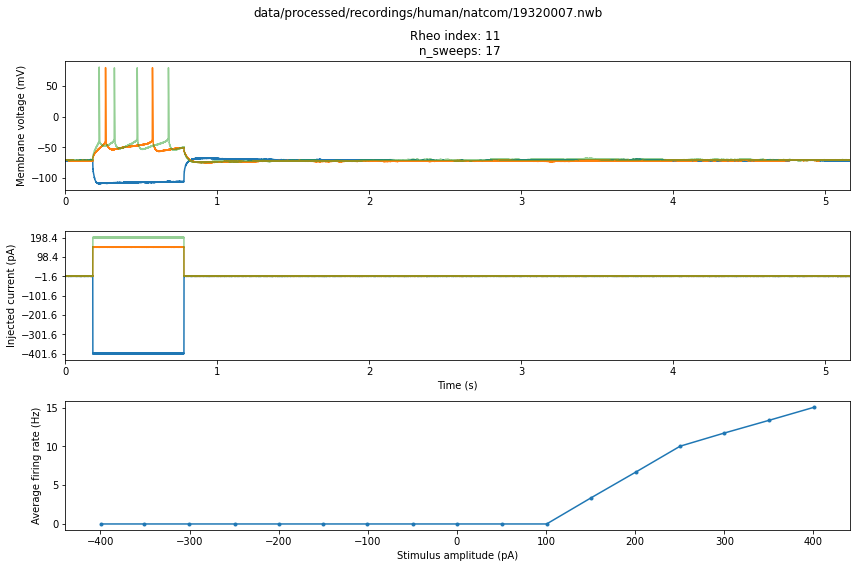

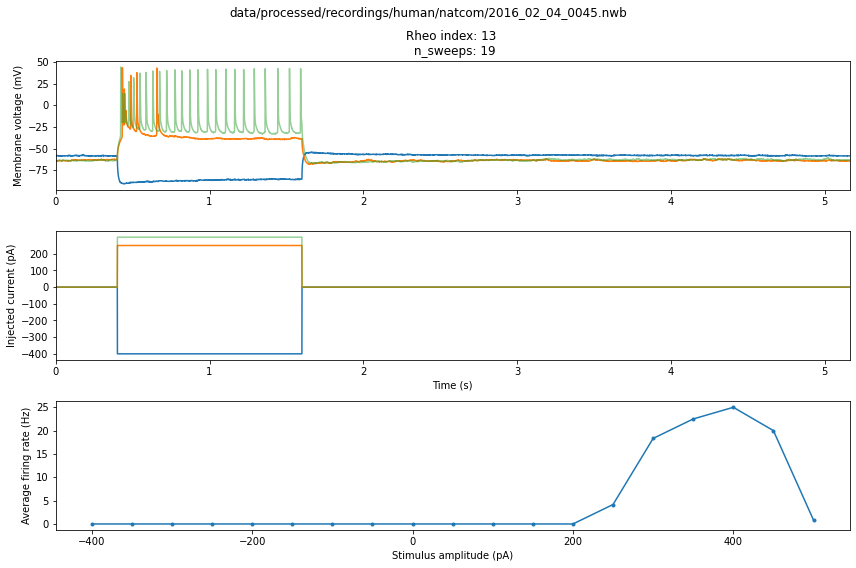

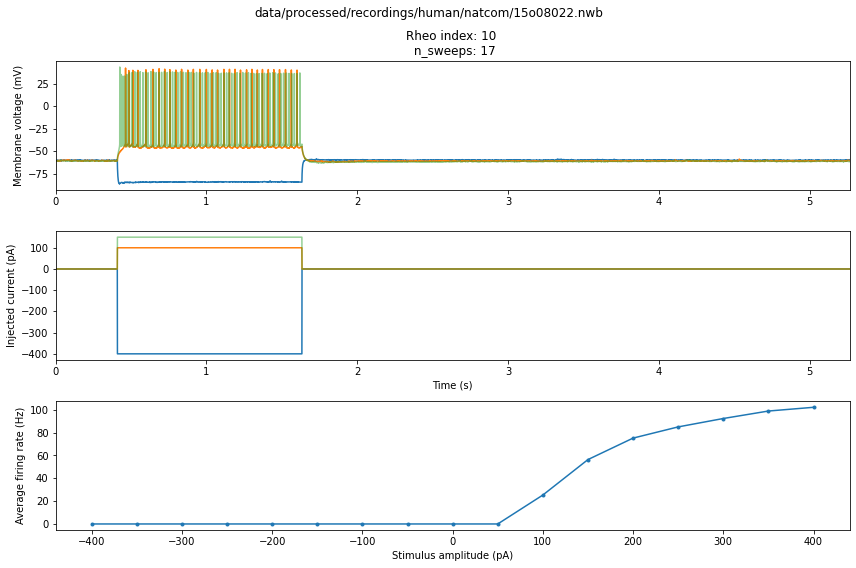

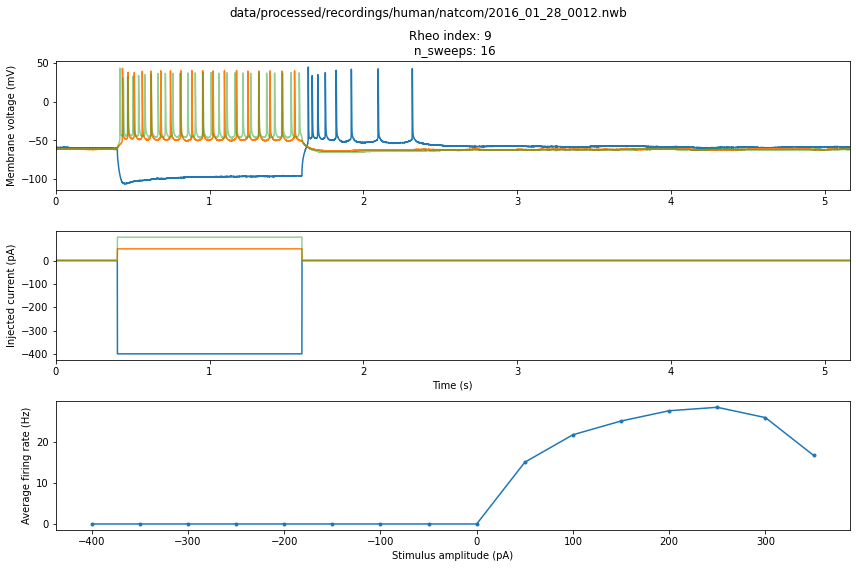

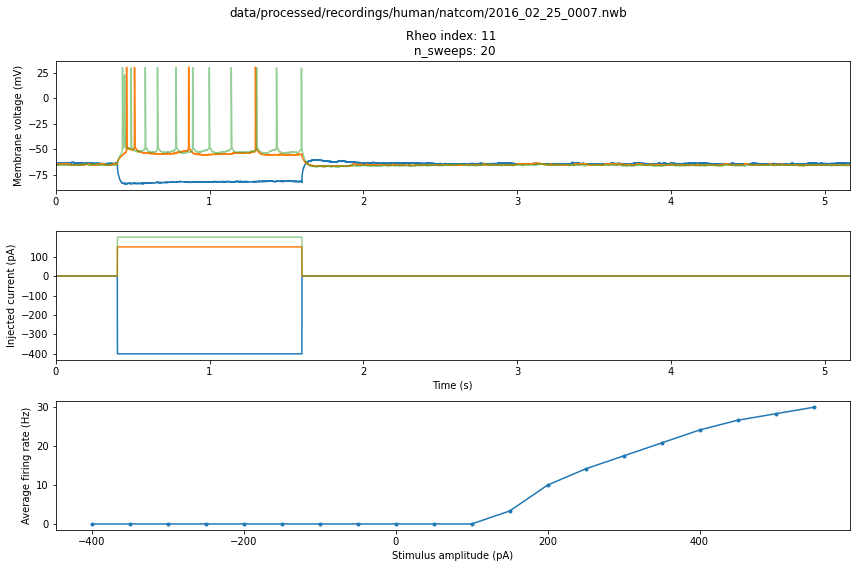

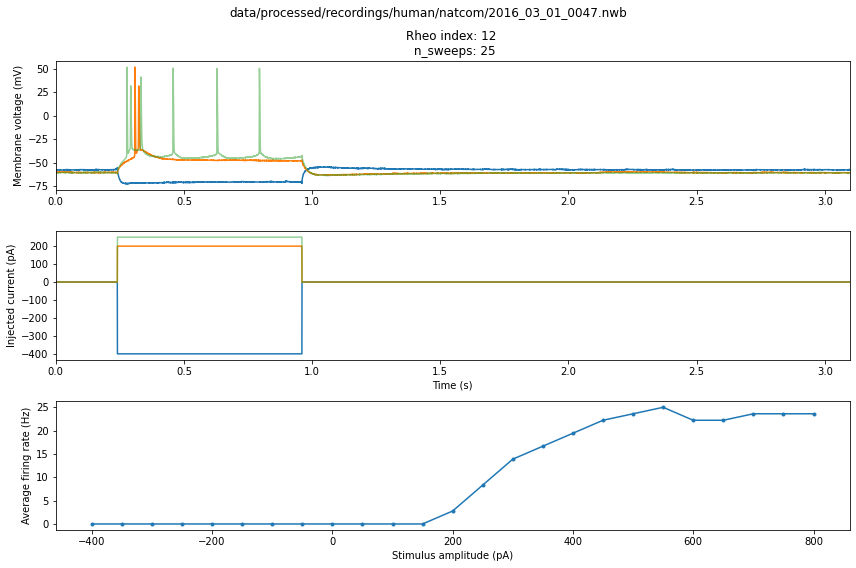

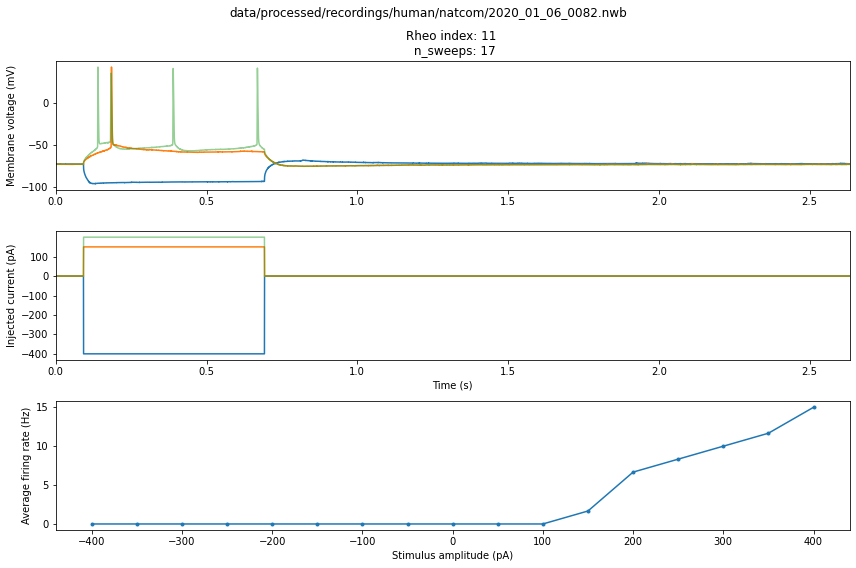

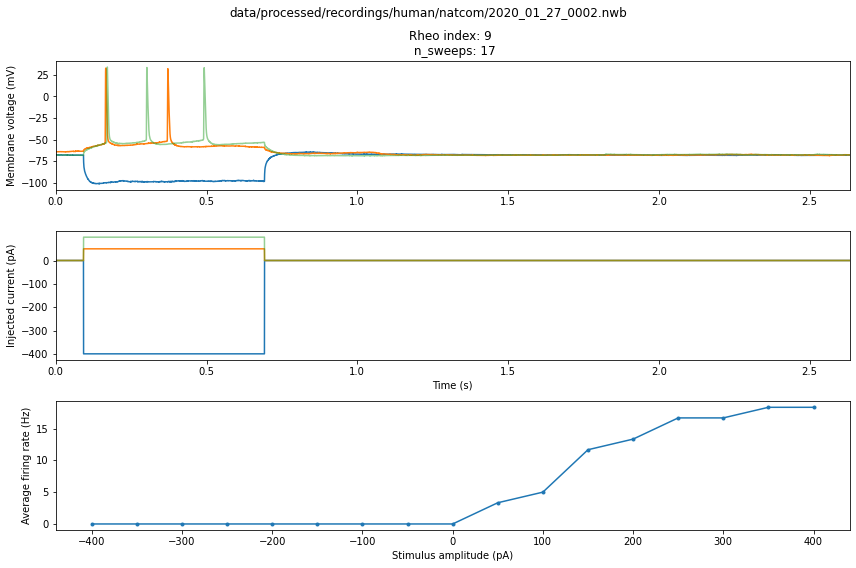

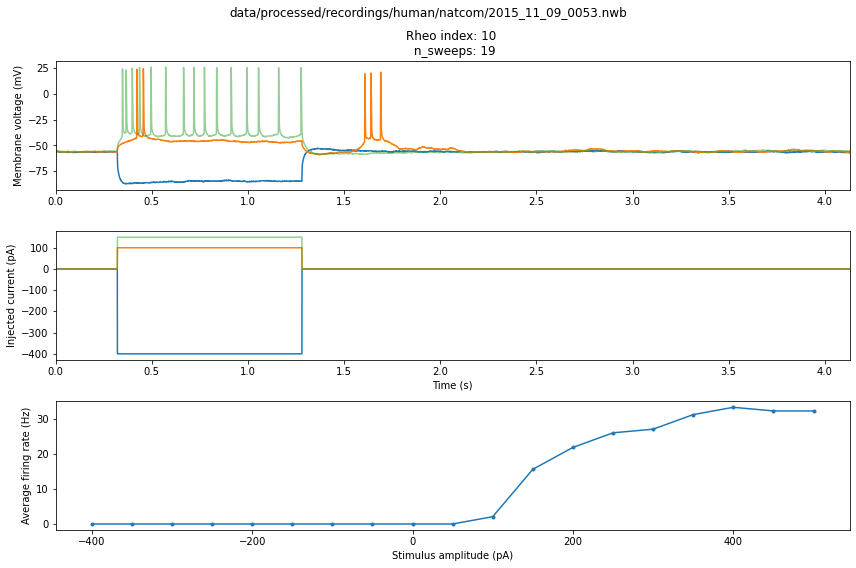

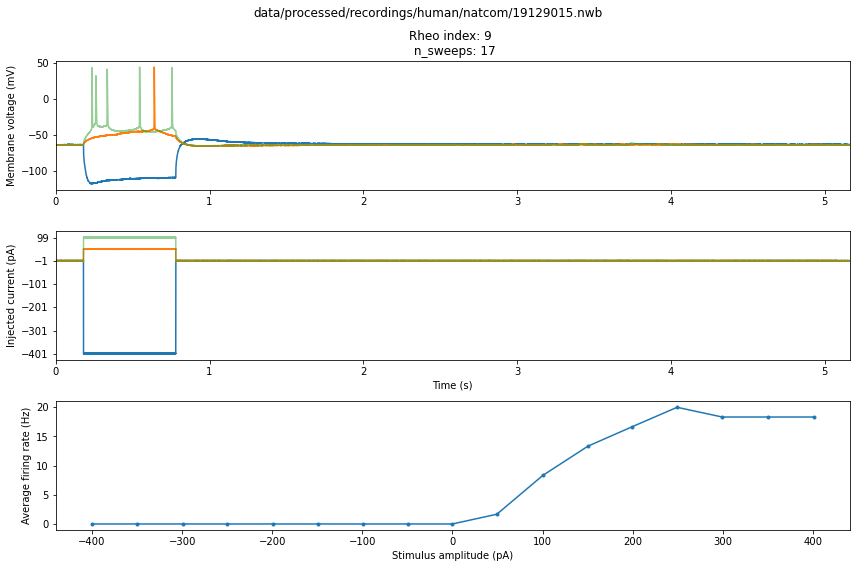

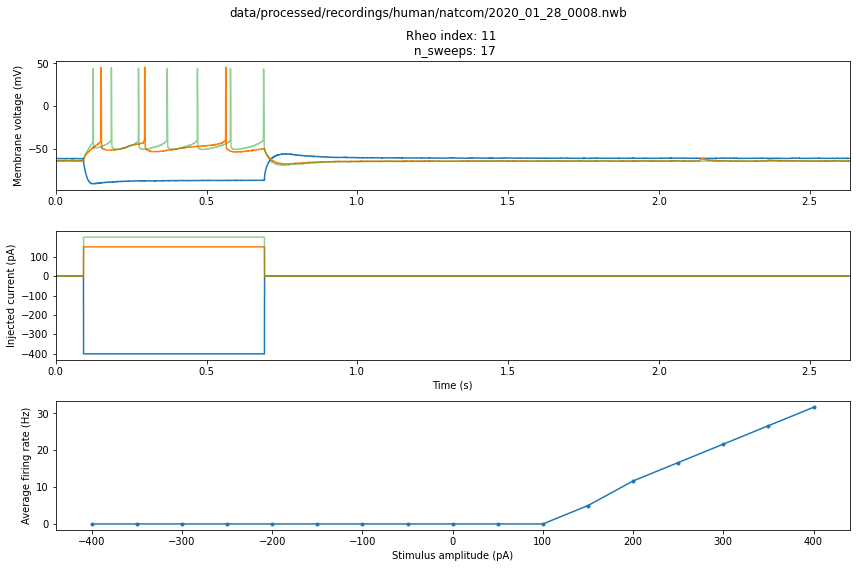

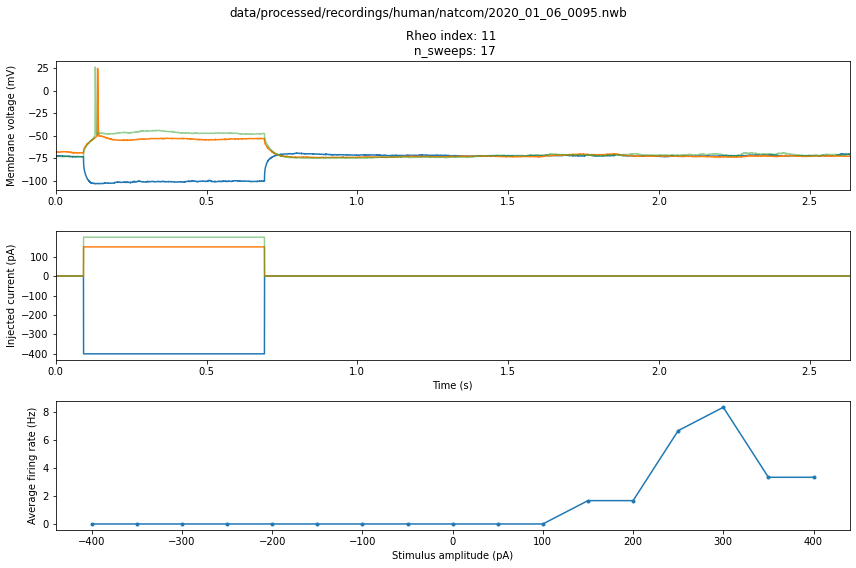

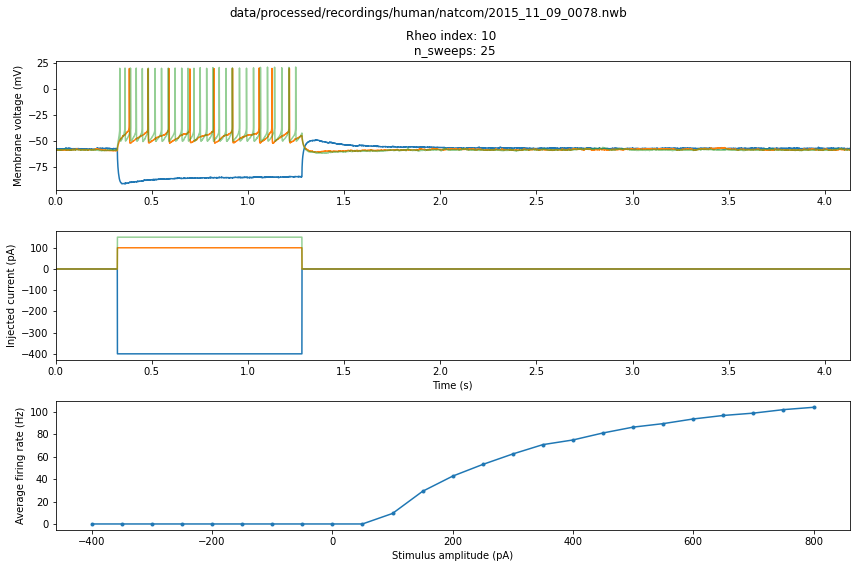

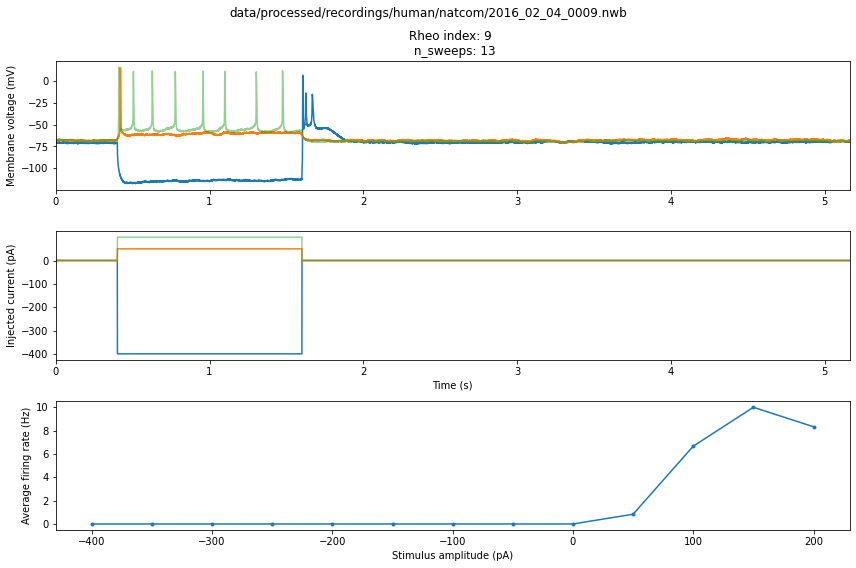

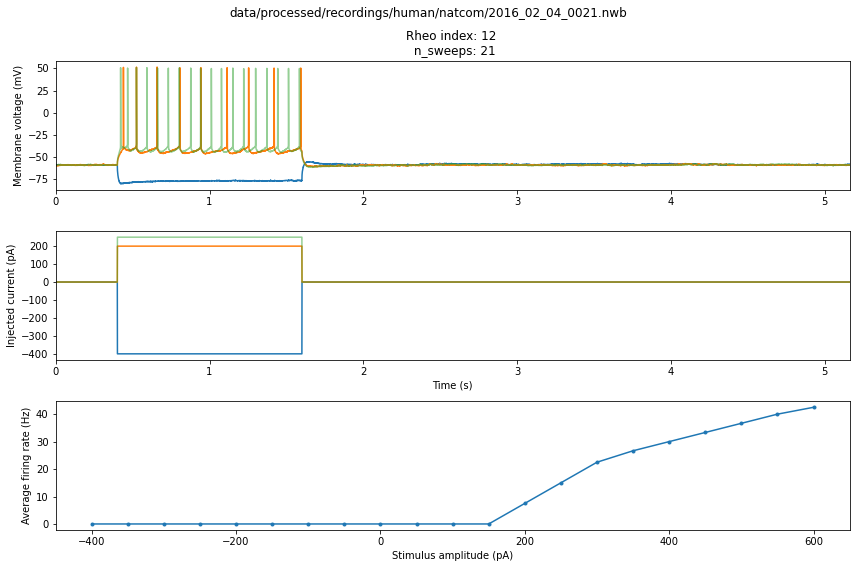

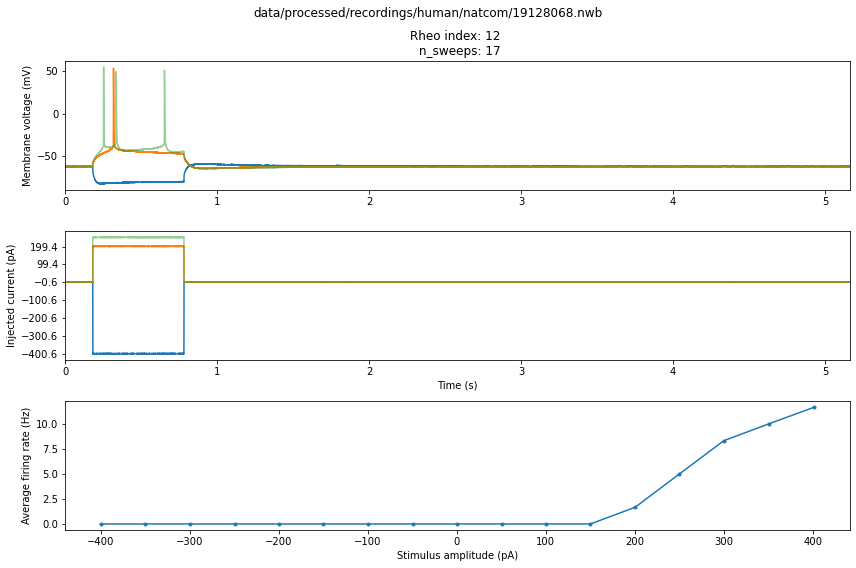

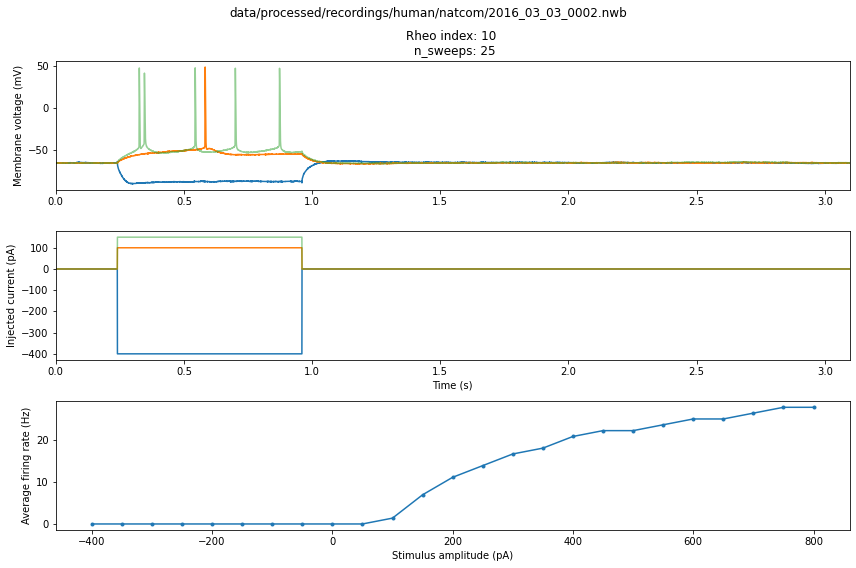

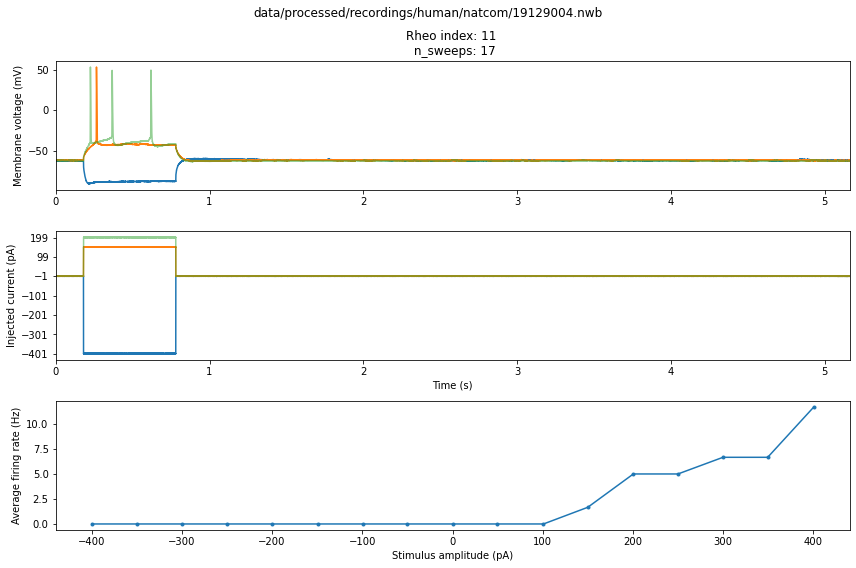

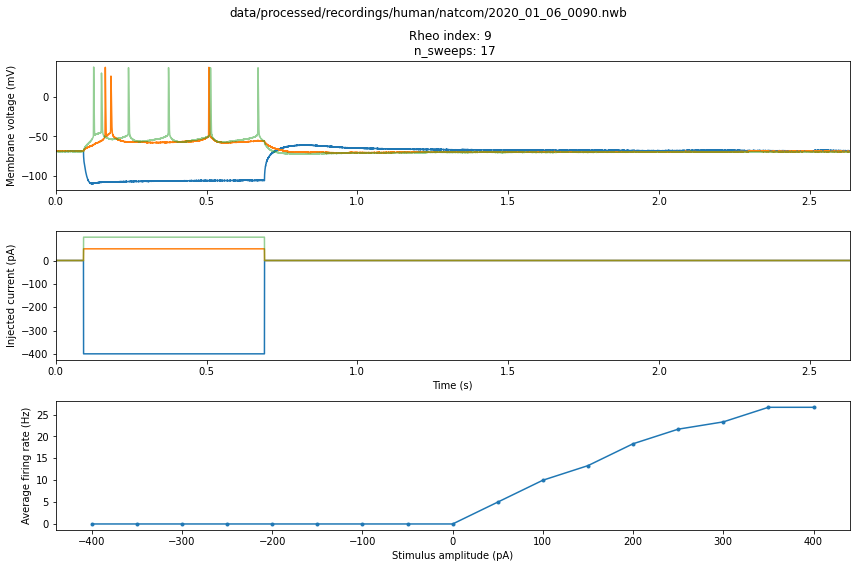

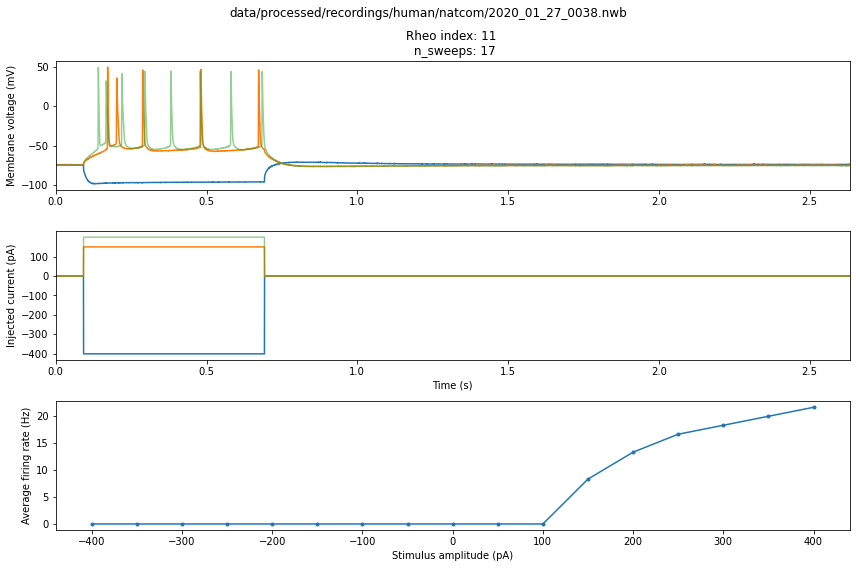

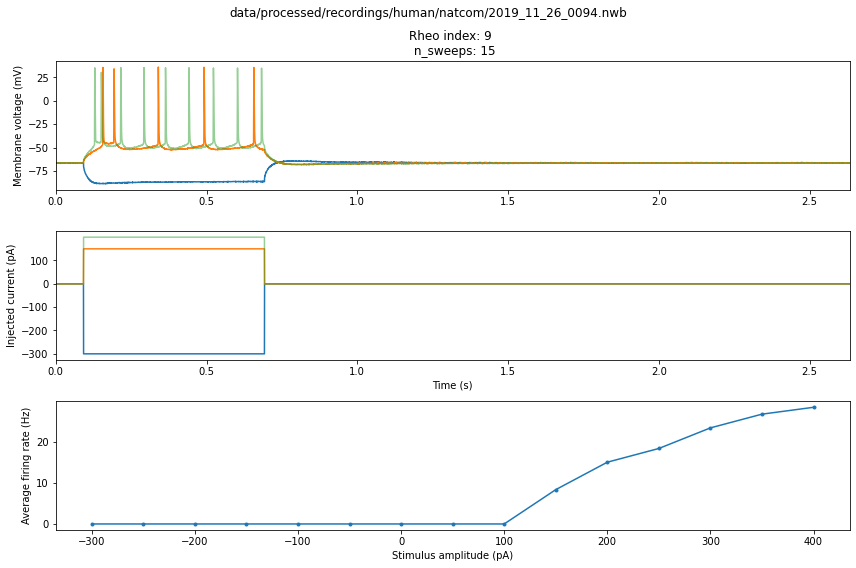

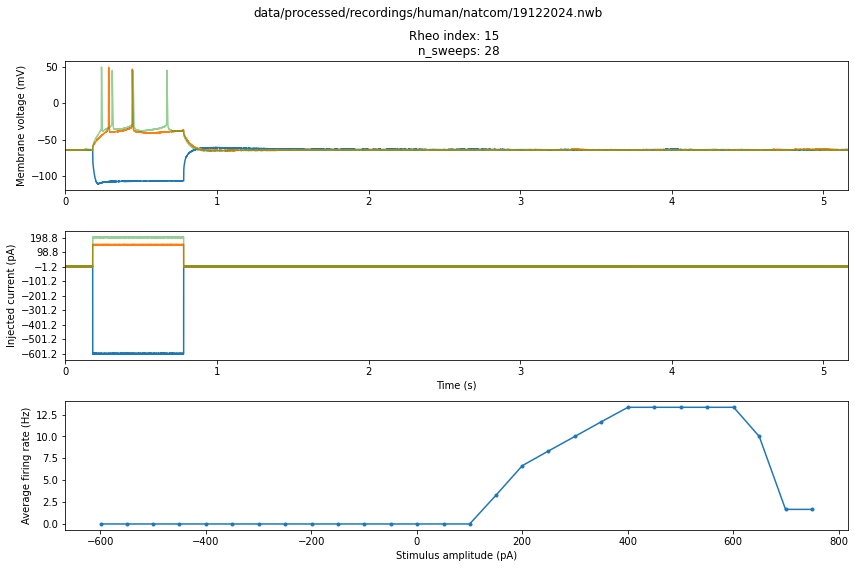

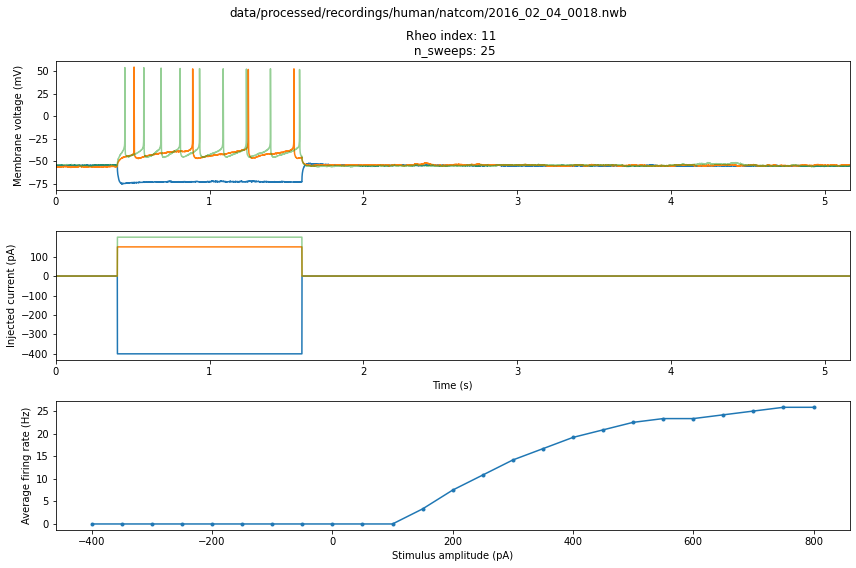

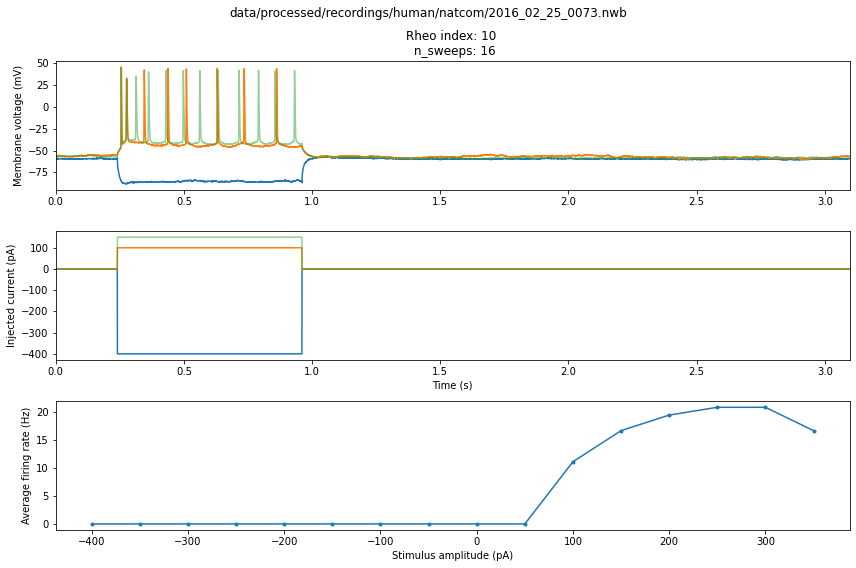

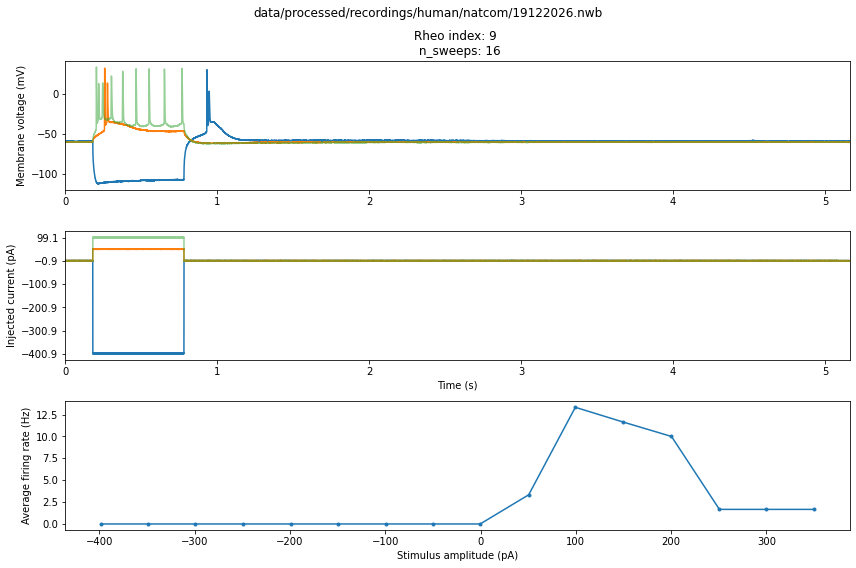

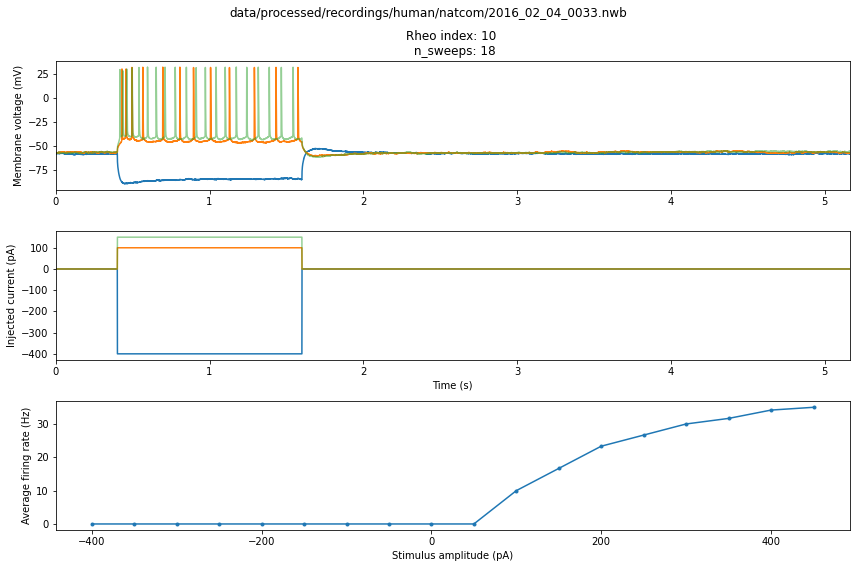

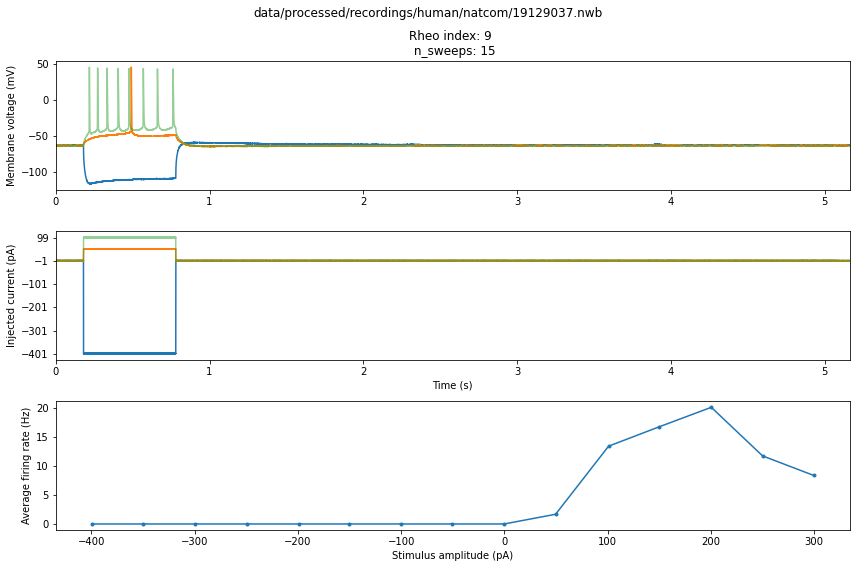

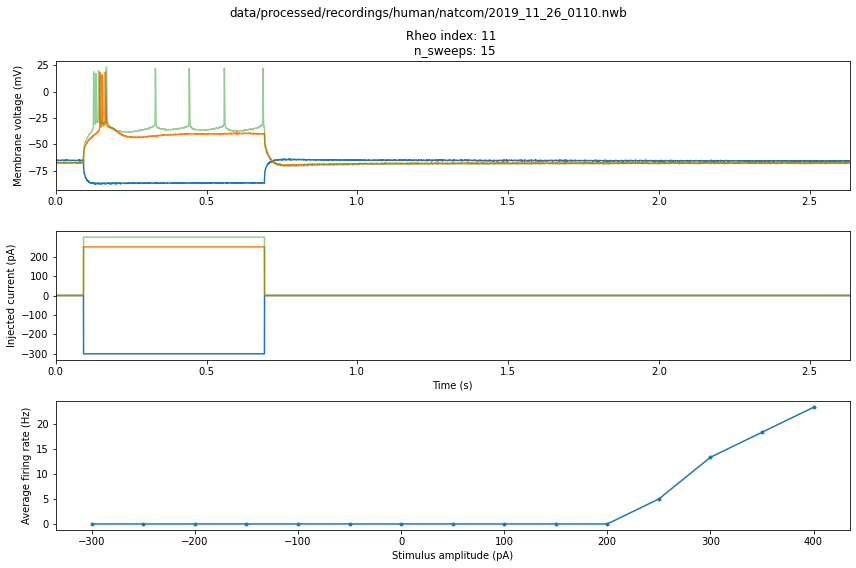

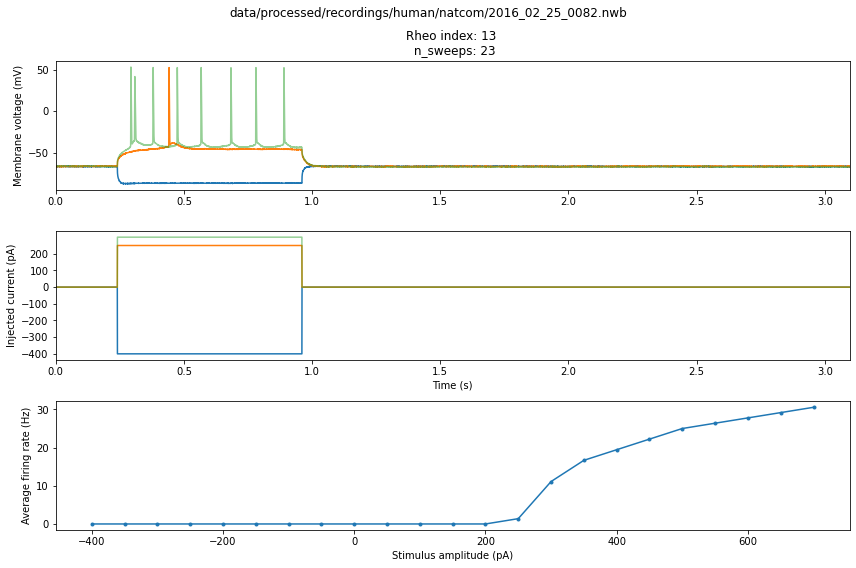

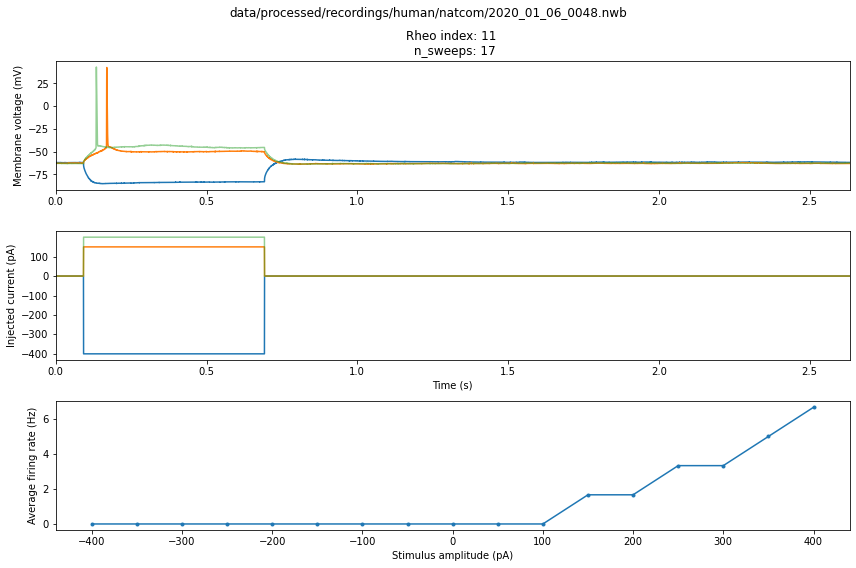

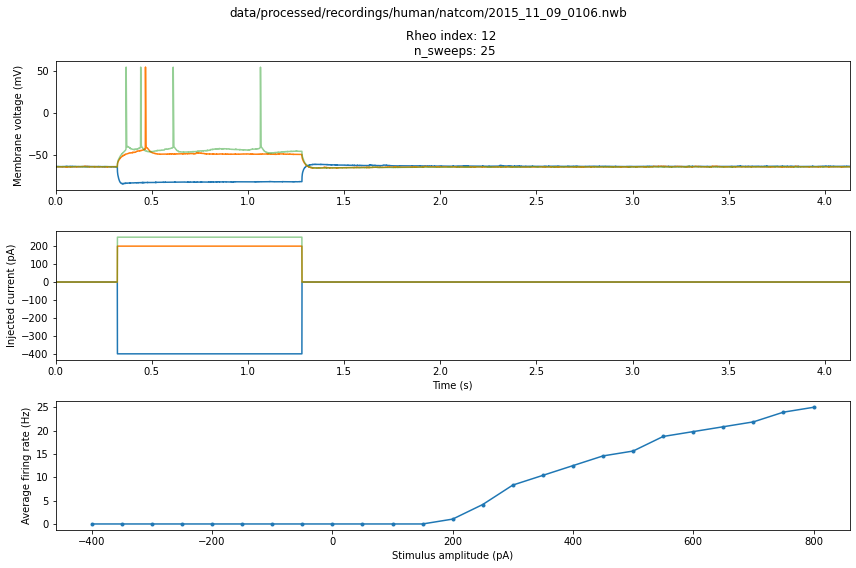

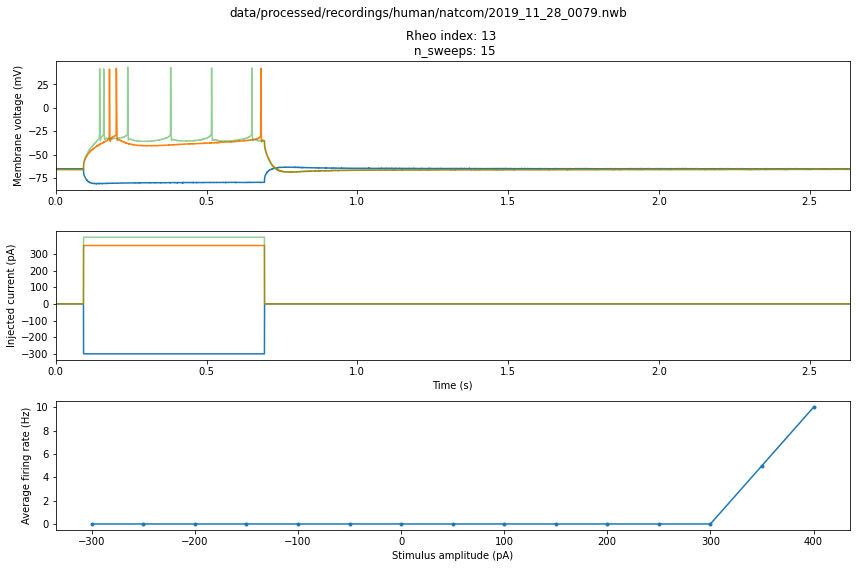

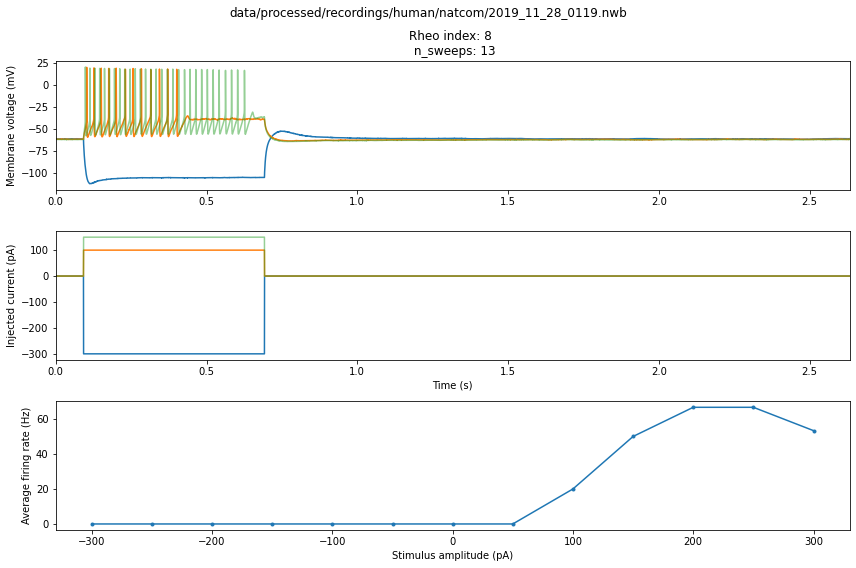

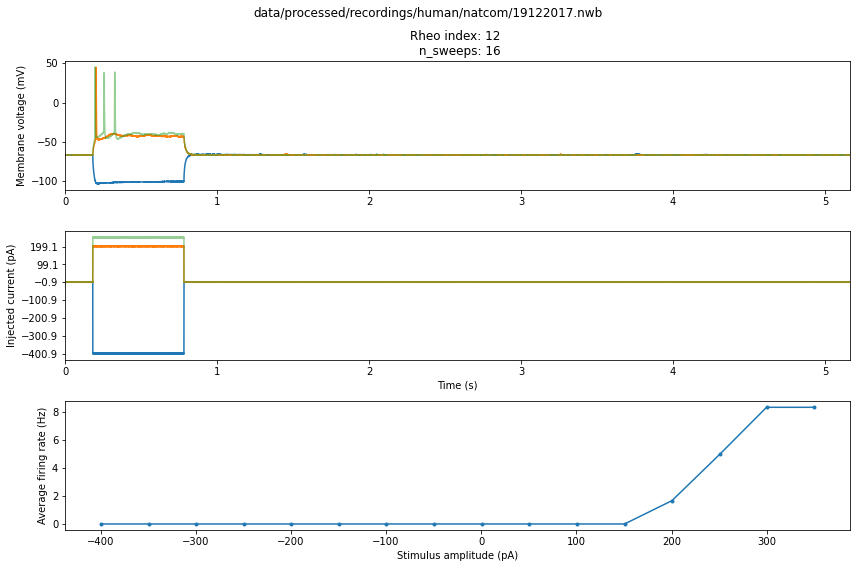

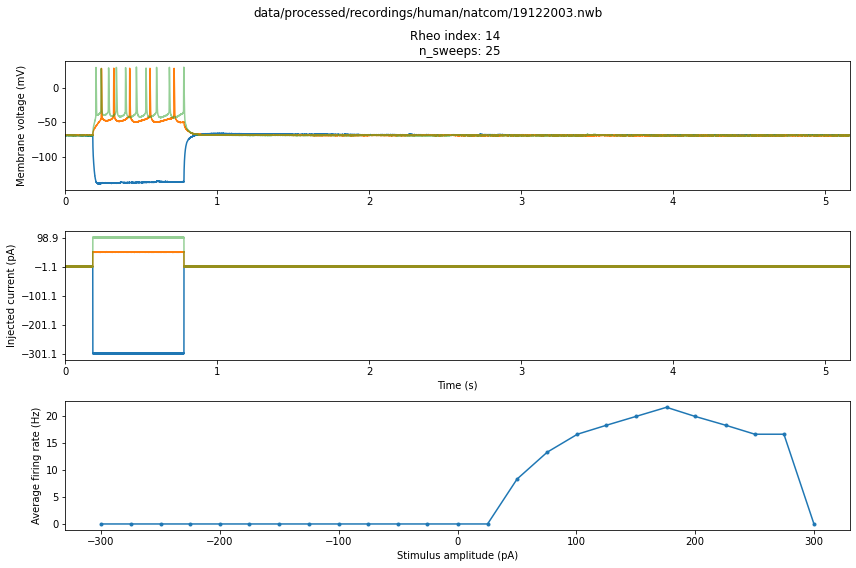

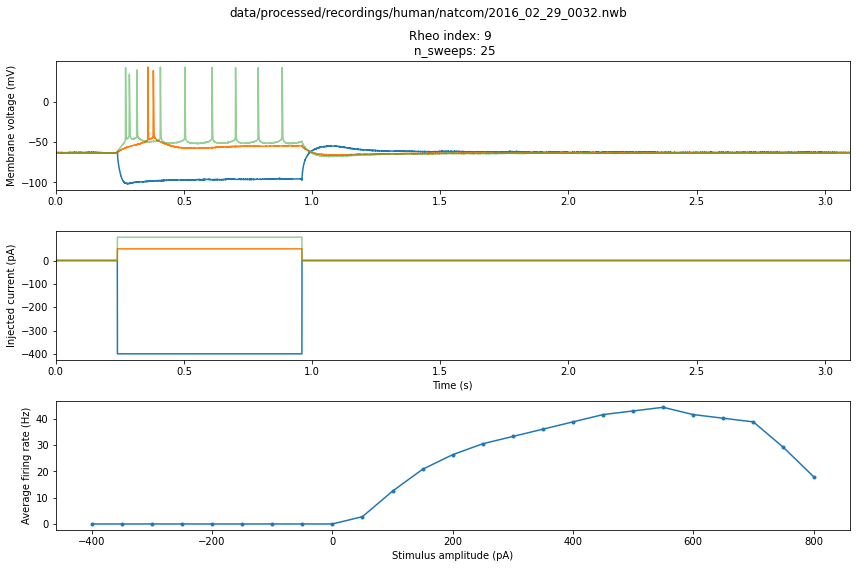

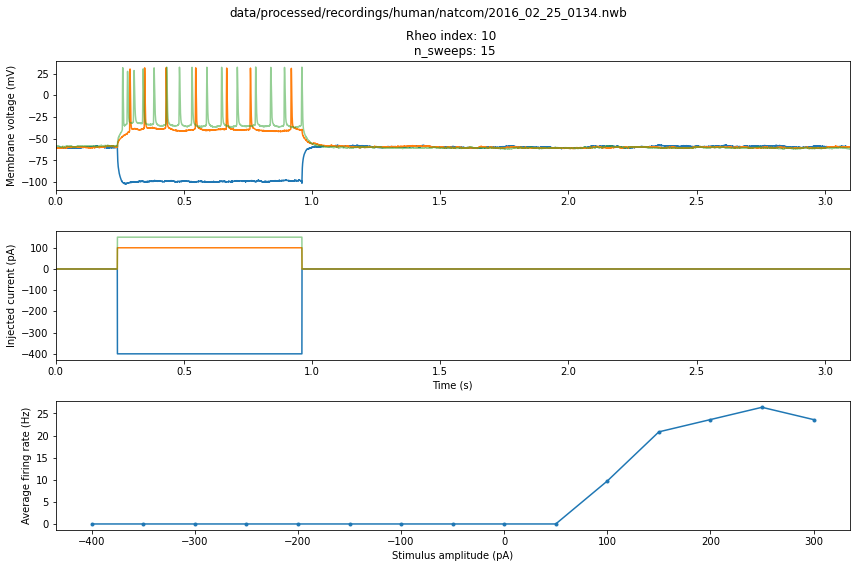

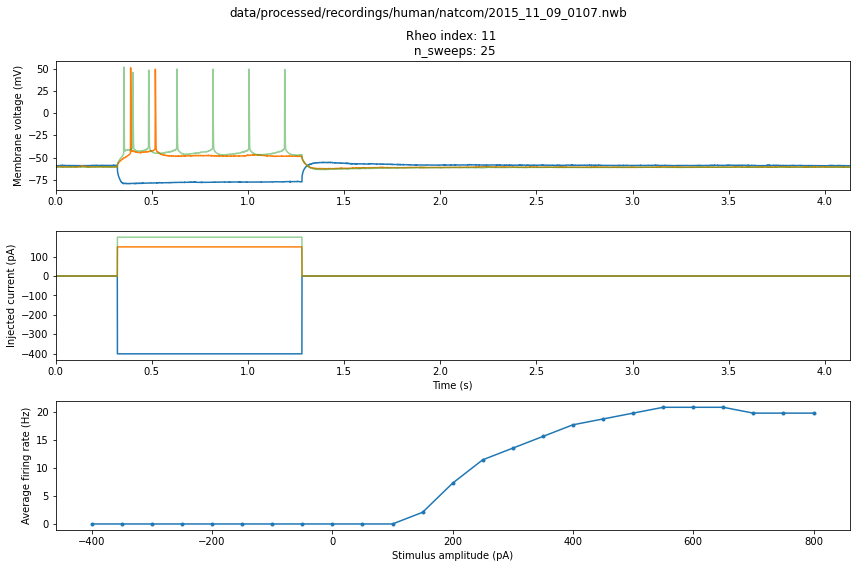

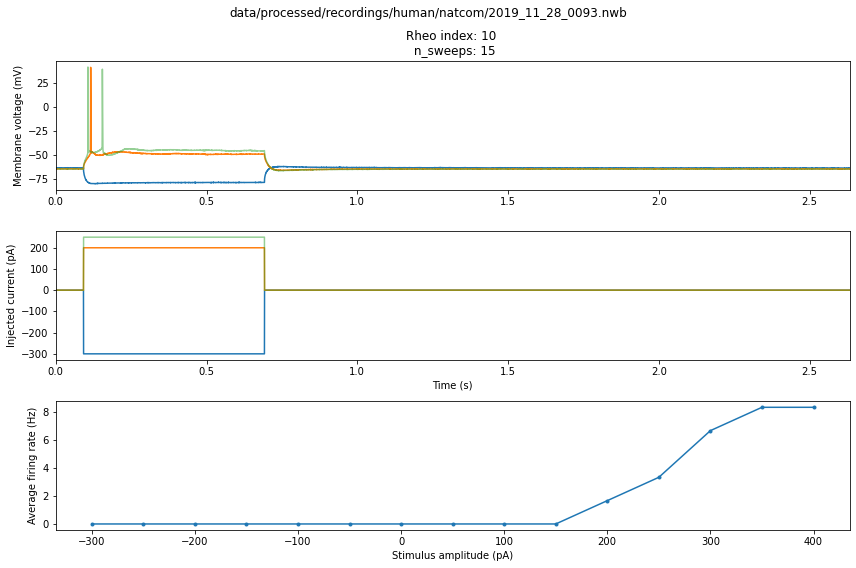

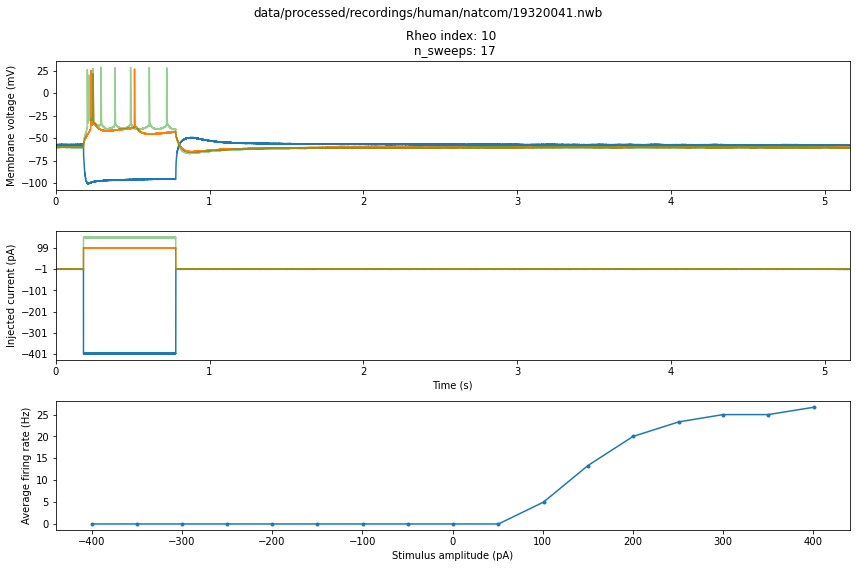

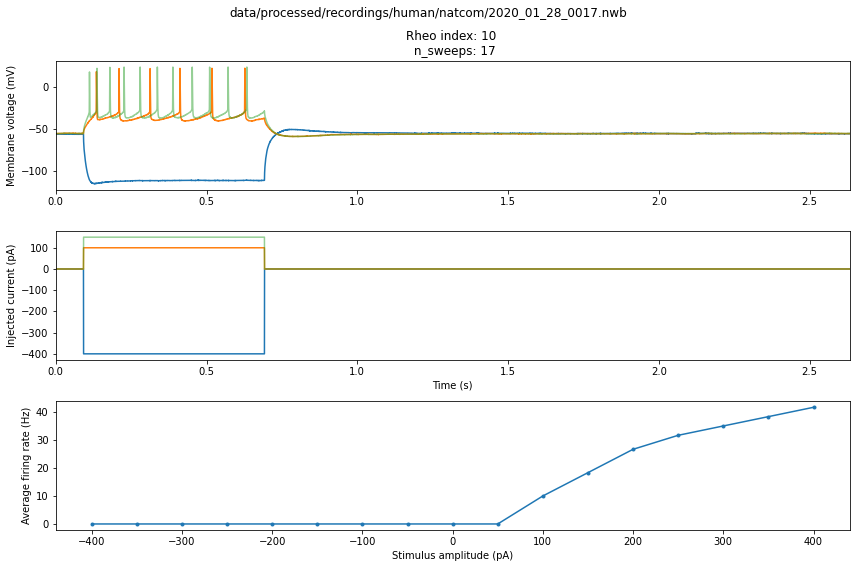

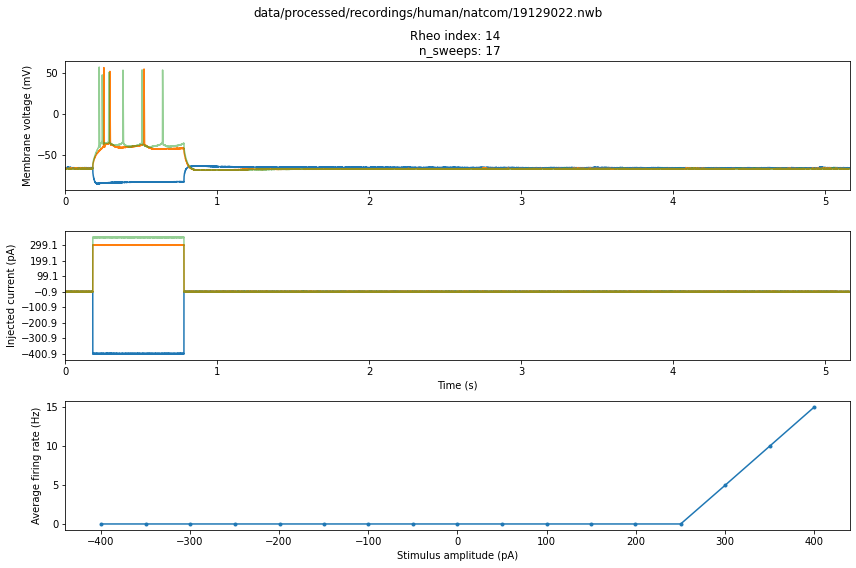

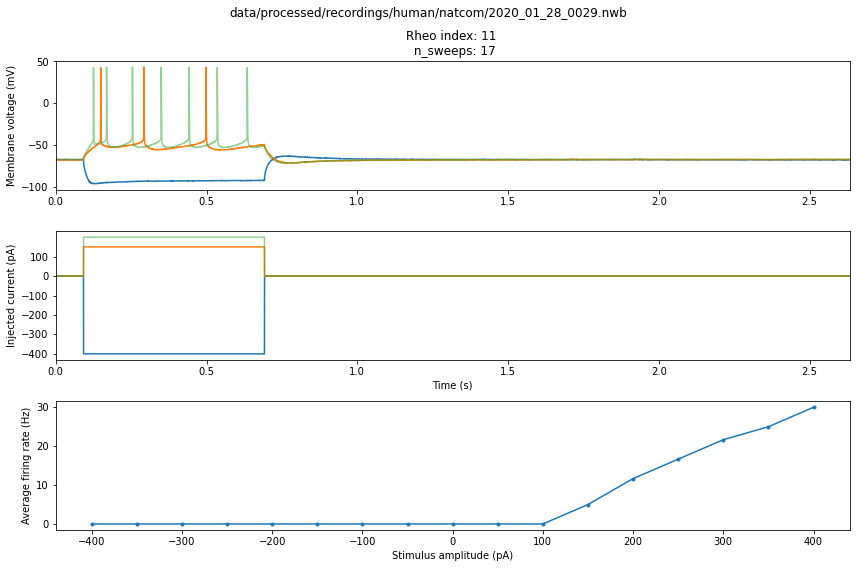

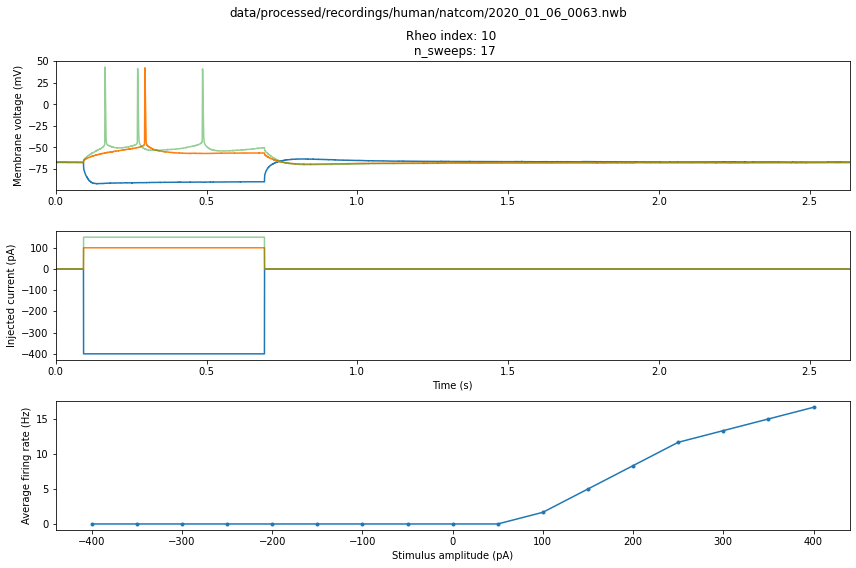

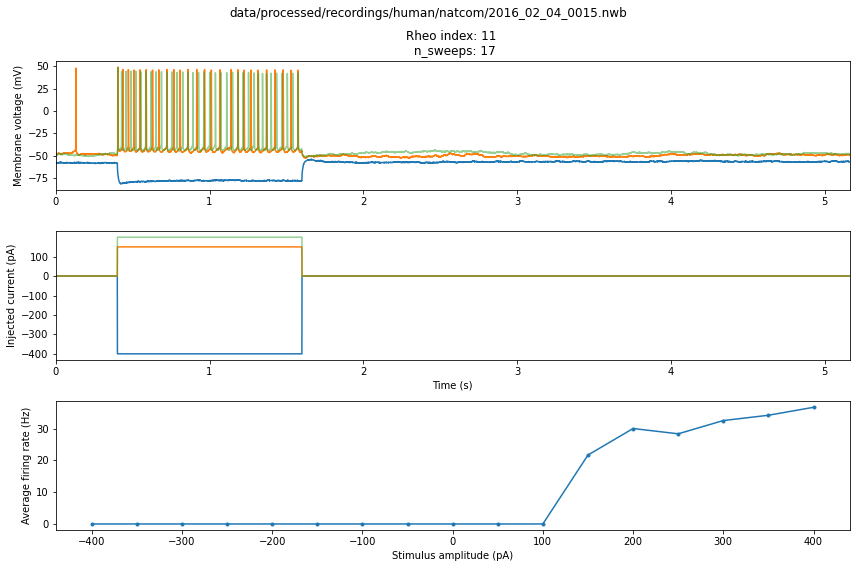

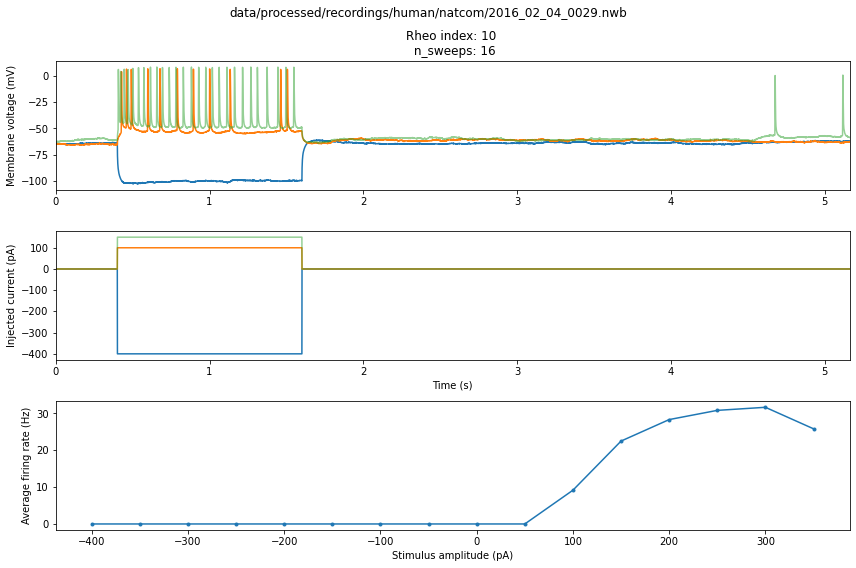

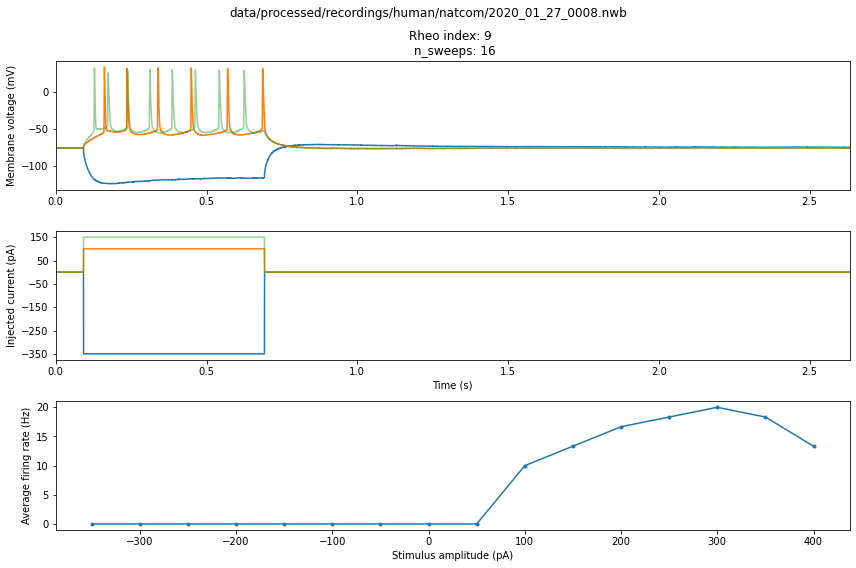

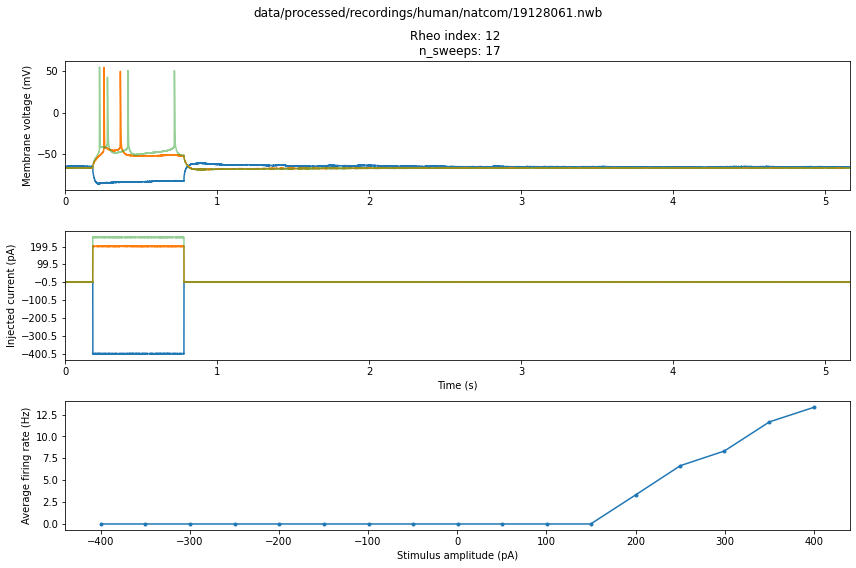

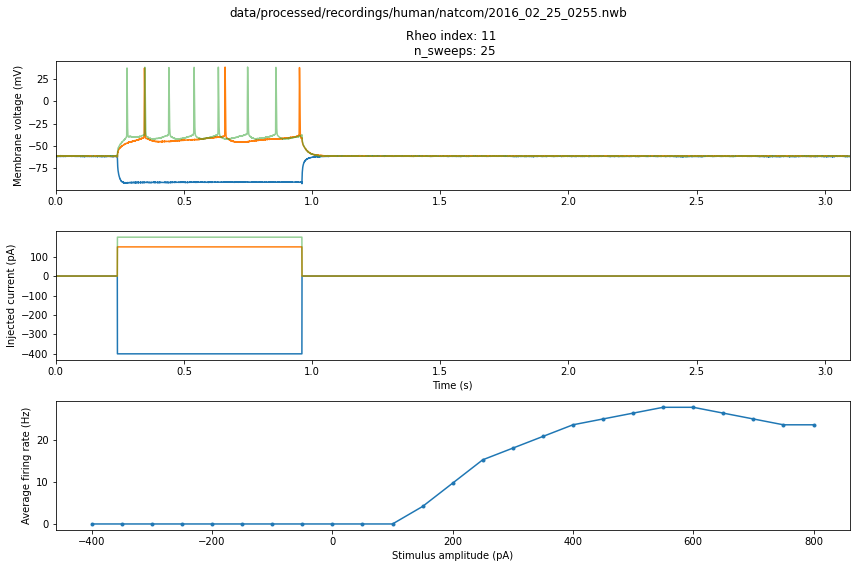

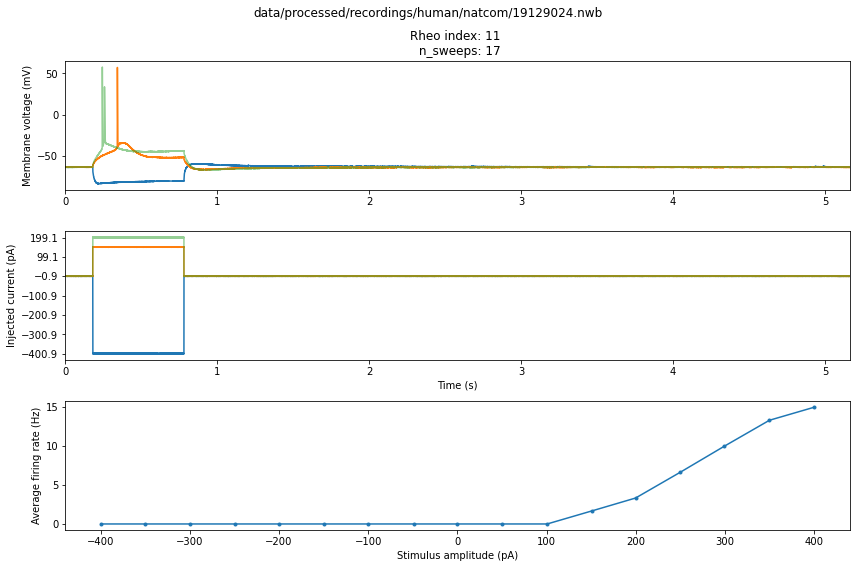

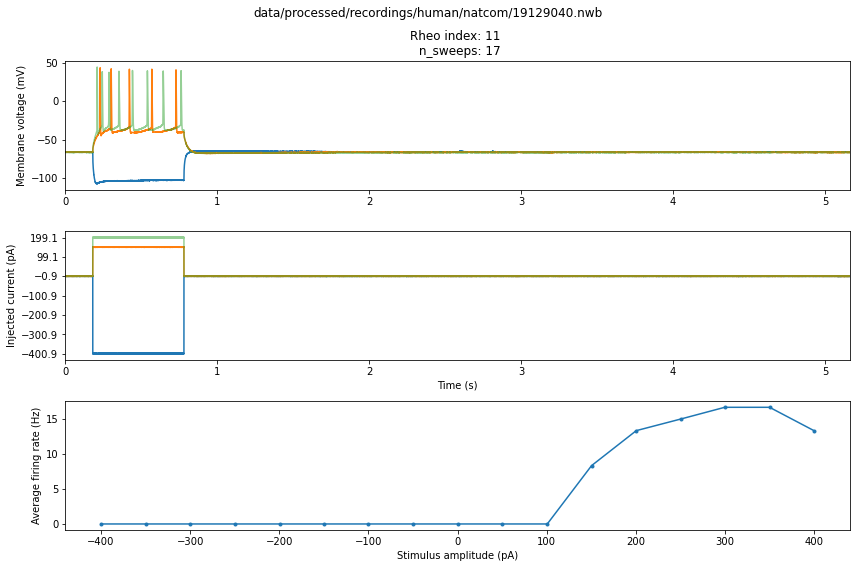

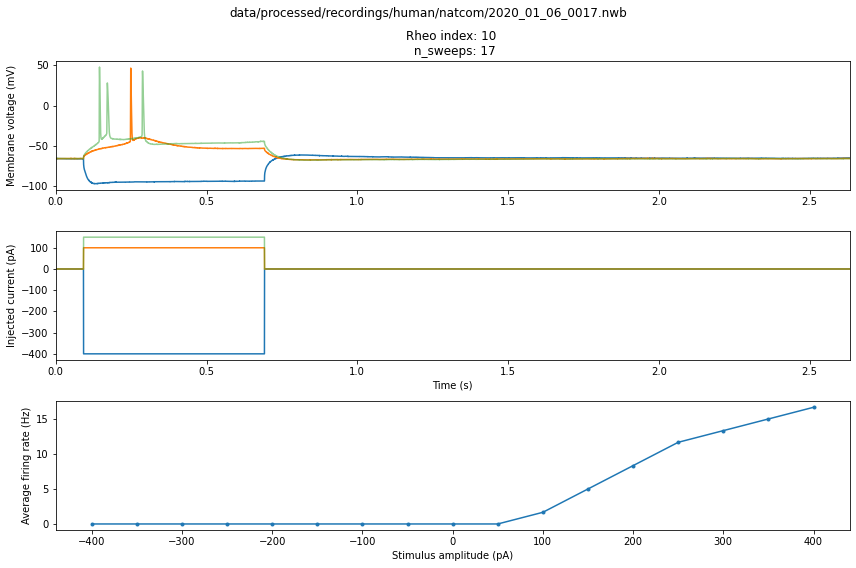

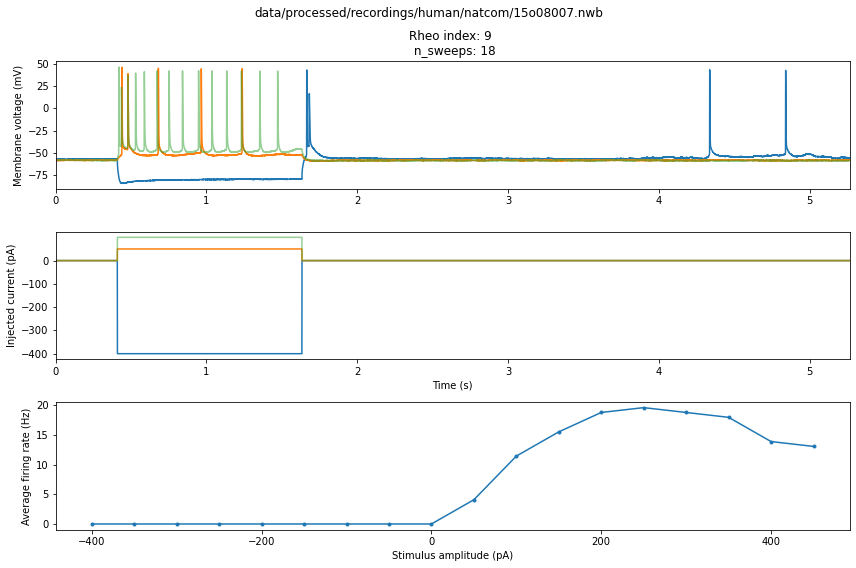

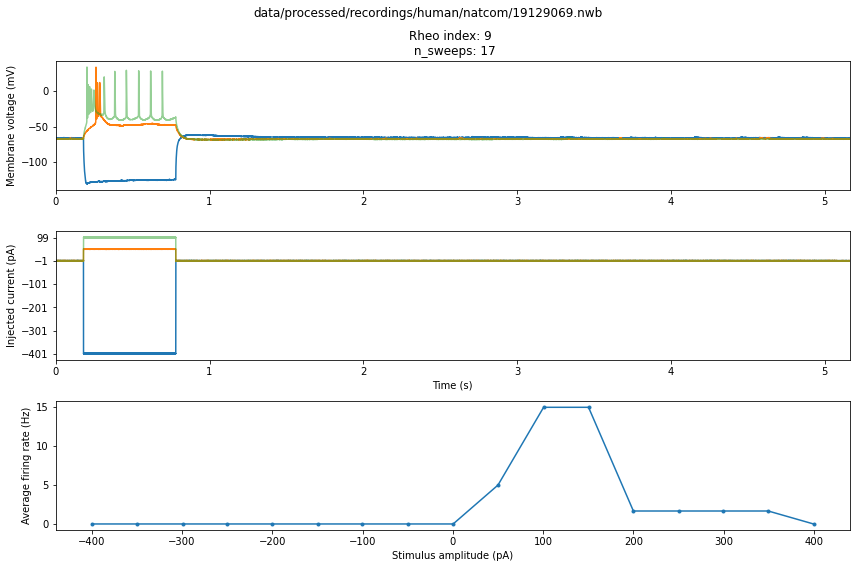

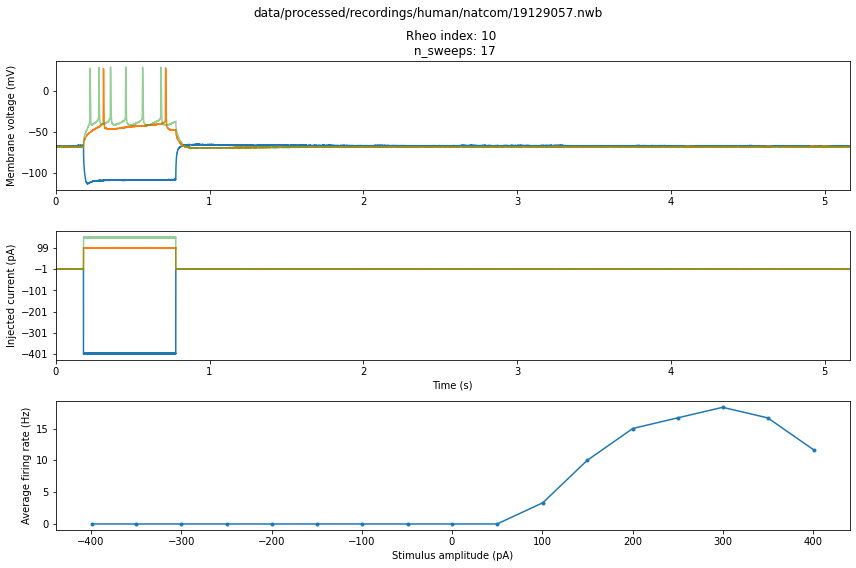

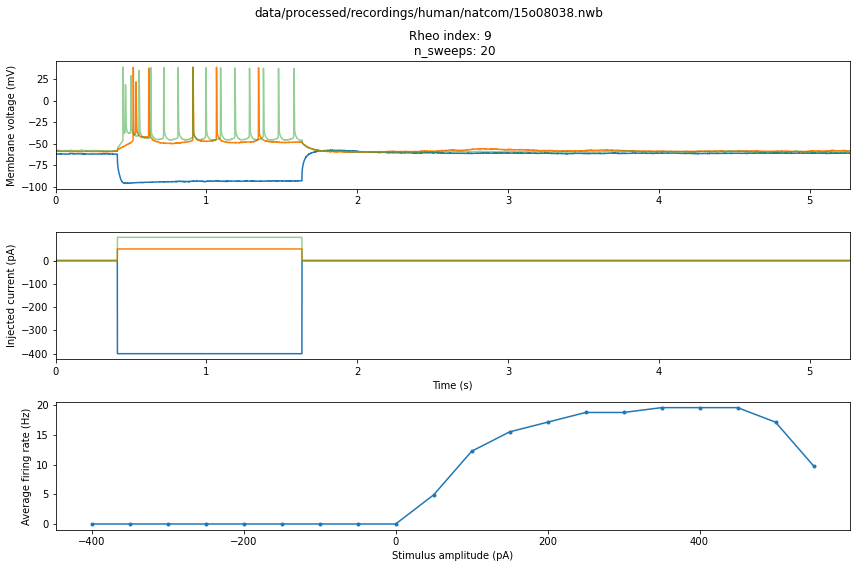

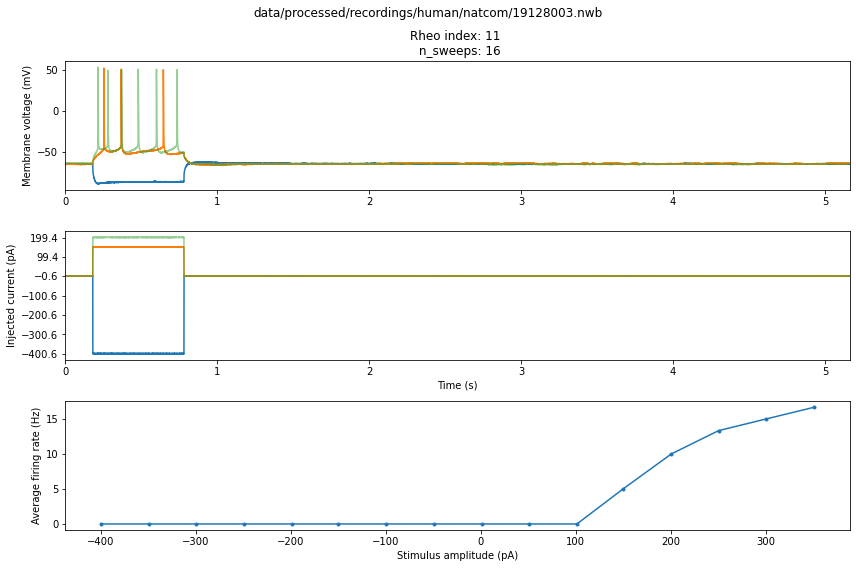

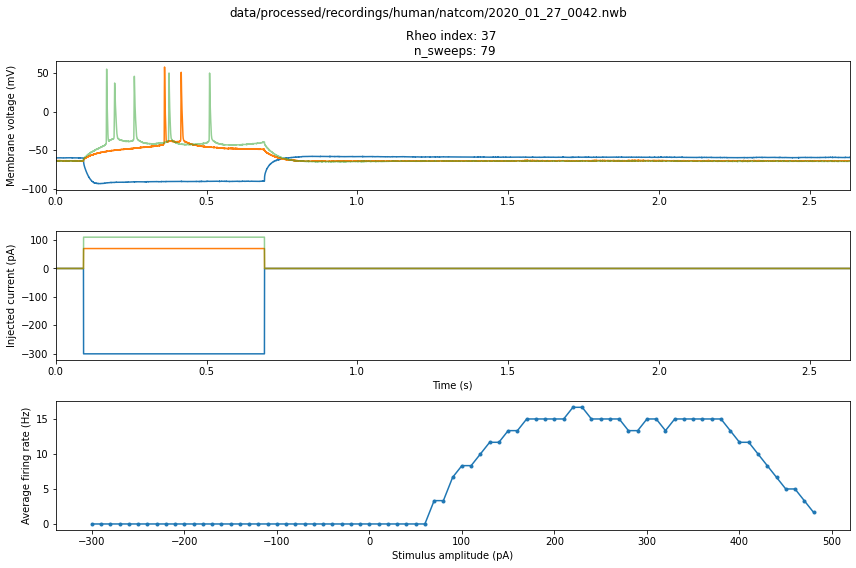

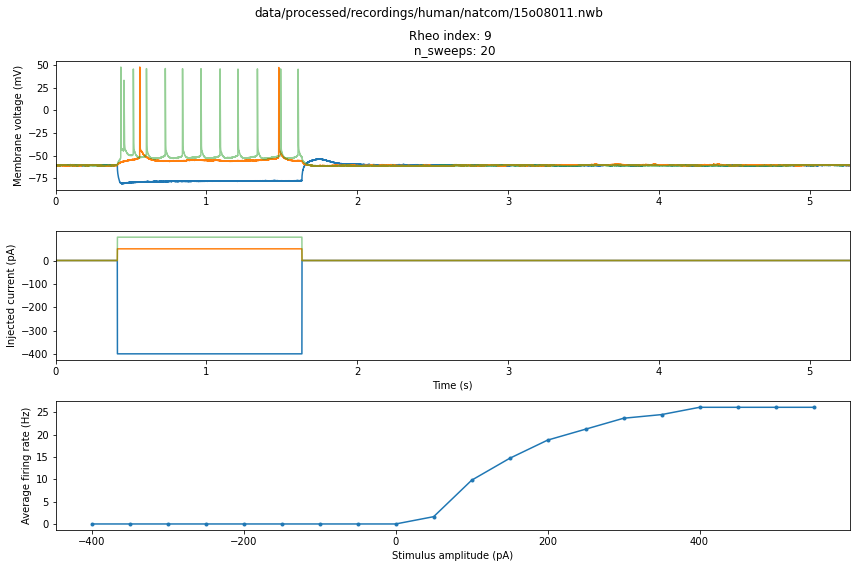

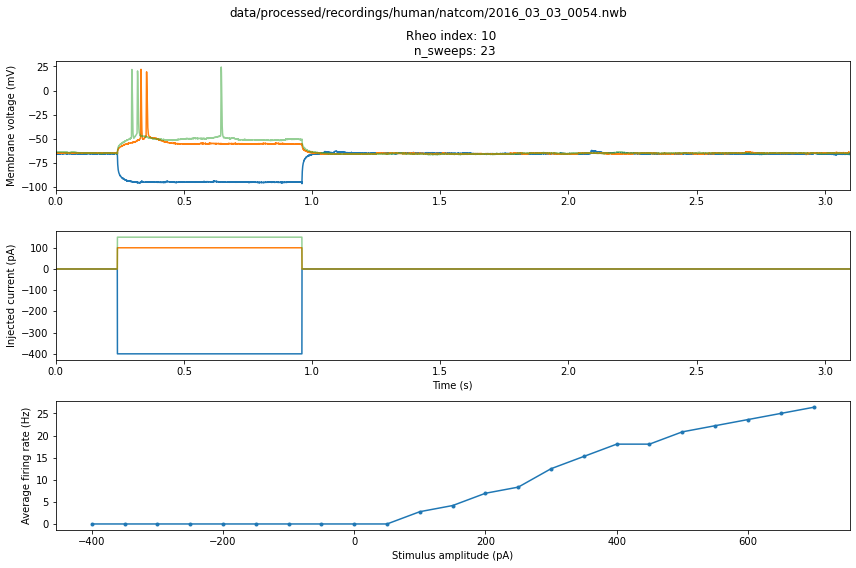

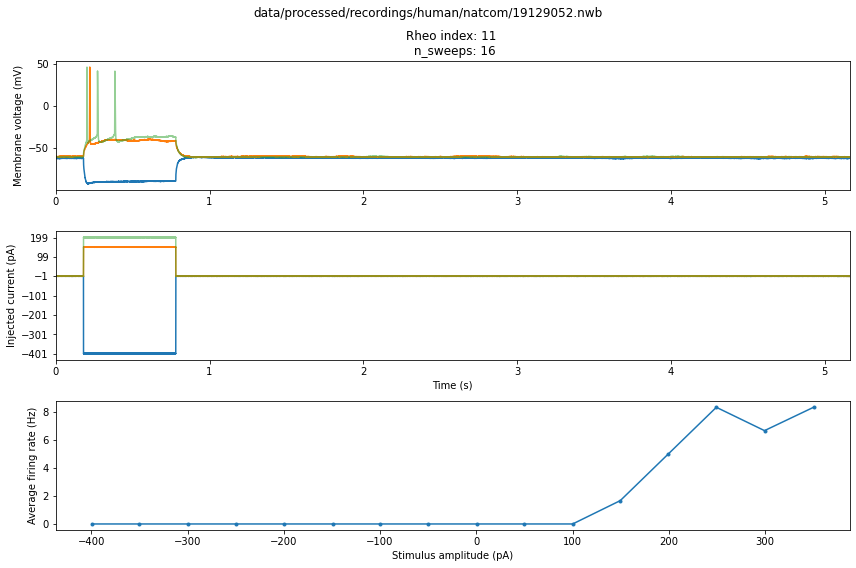

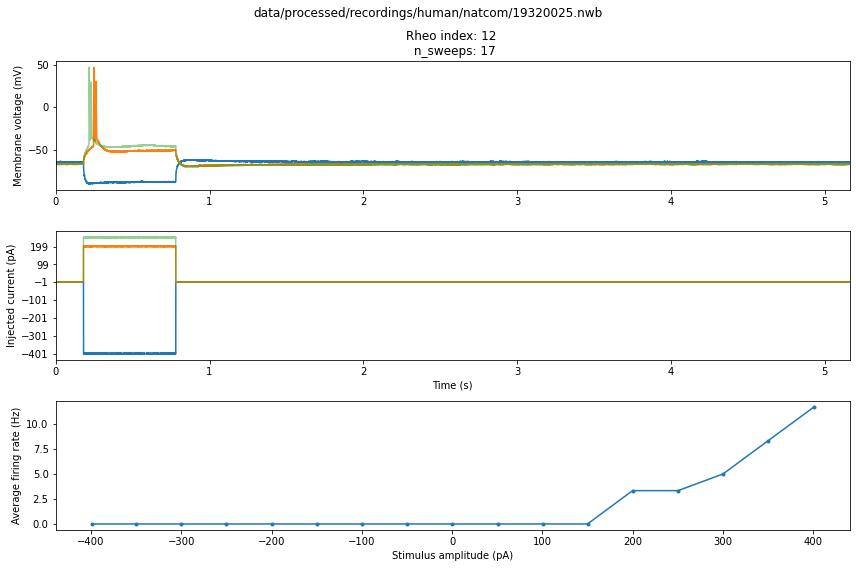

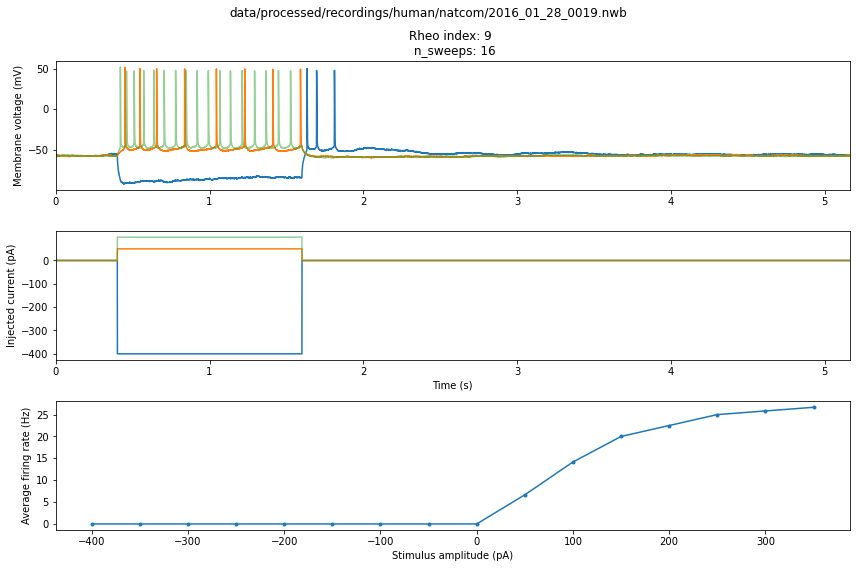

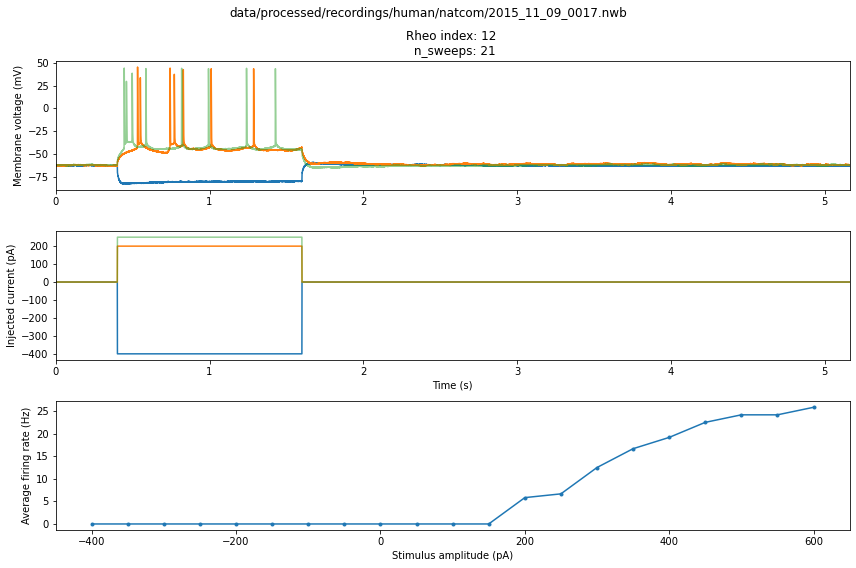

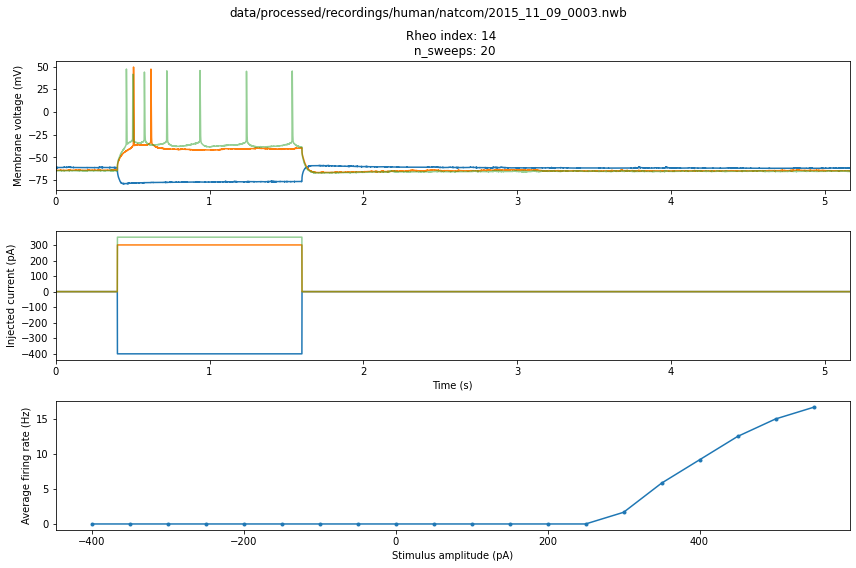

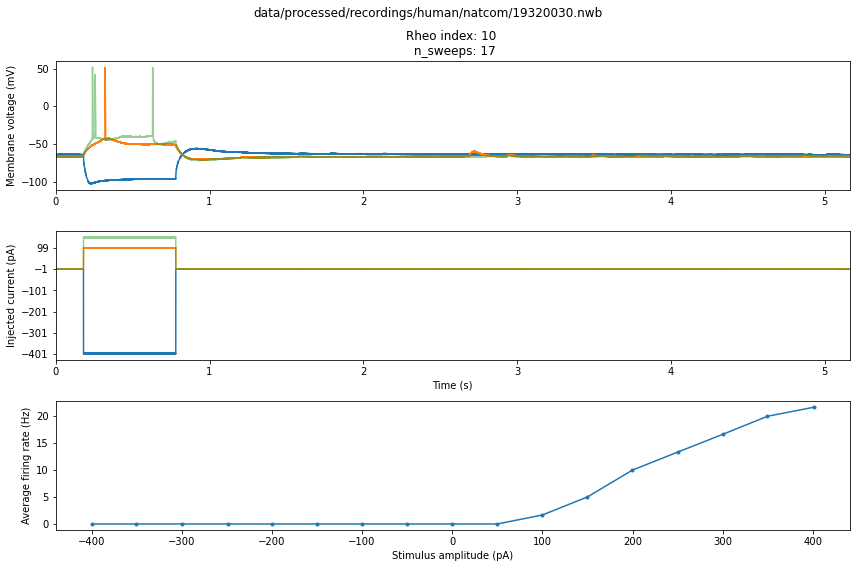

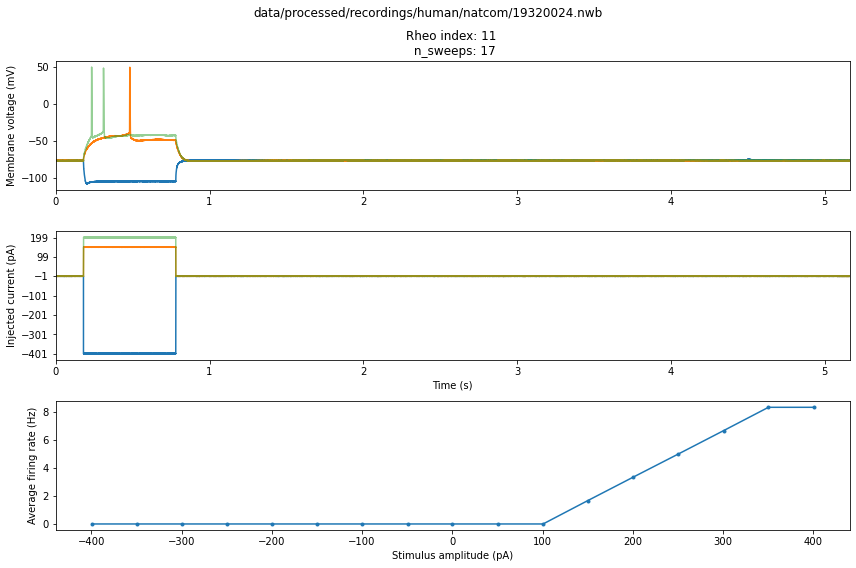

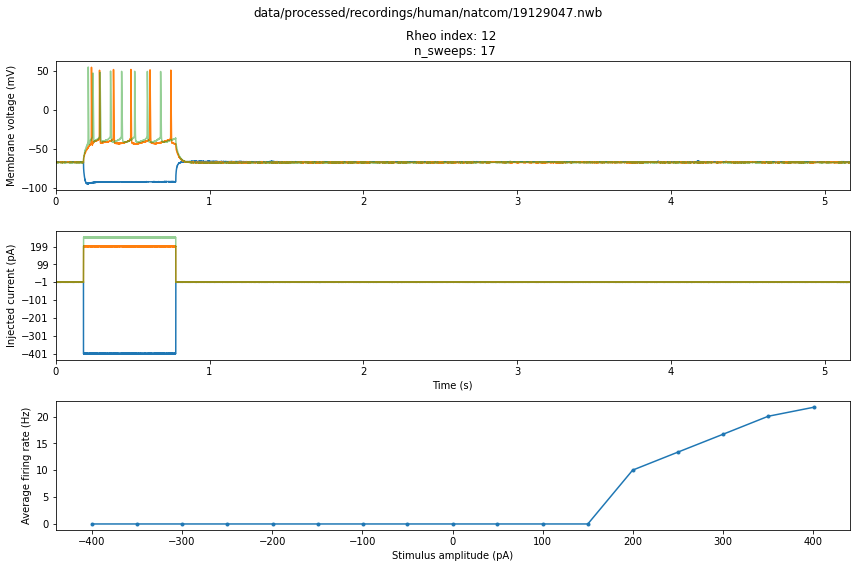

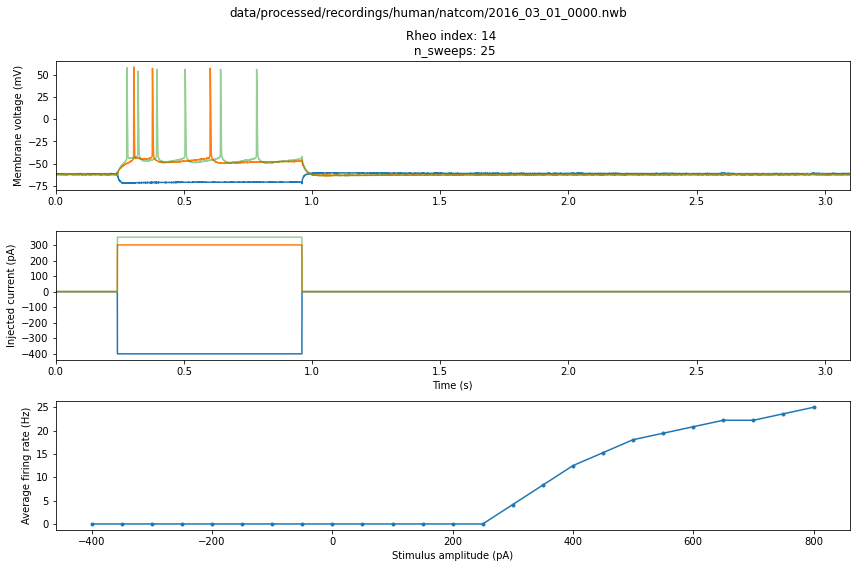

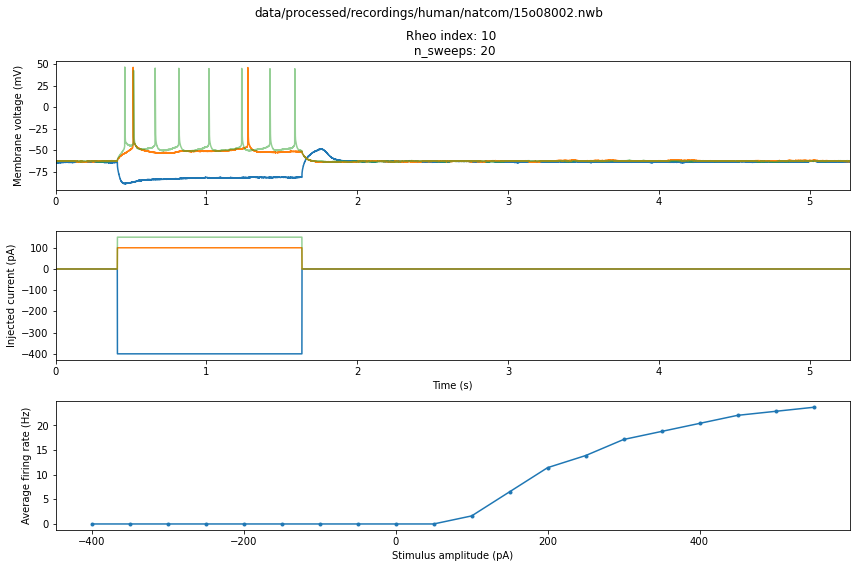

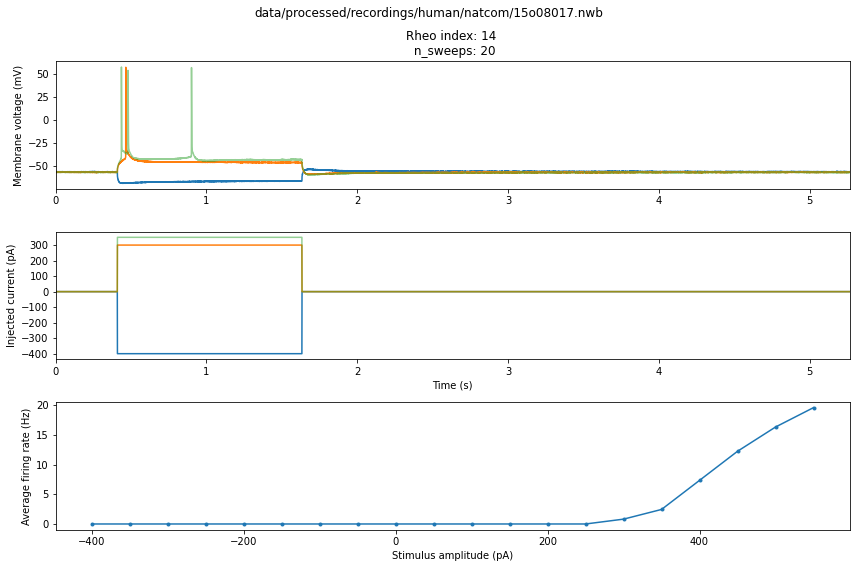

In [14]:
qc_results = []
for i, row in natcom.iterrows():
    try:
        plot_nwb_QC(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time, save_dir=natcom_figs)
        qc_info = QC_V_baseline(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time)
        qc_results.append((row.file_id, *qc_info))
    except (AssertionError, AttributeError, TypeError, FeatureError, ValueError) as e:
        print(f'Error: {e} \n') 
        
natcom_qc_results = pd.DataFrame(qc_results, columns=col_names).sort_values('max_diff_v_baseline', ascending=False)

In [15]:
h19_qc_results.sort_values('max_drift_Vm', ascending=False)

file_id  initial_v_baseline  last_v_baseline  \
6          19328039          -70.967361       -52.015945   
13         19228030          -71.219360       -56.937138   
22         19228044          -70.967873       -63.384258   
26         19228068          -66.866821       -60.259766   
19         19328046          -65.178566       -65.071754   
15         19328019          -65.643150       -69.274742   
7          19319025          -66.447220       -70.353470   
3          19228058          -66.439011       -67.644455   
0   2019_11_28_0010          -62.515255       -64.025879   
16         19328009          -62.206913       -61.138798   
9   2019_11_04_0083          -61.538696       -63.293453   
12         19328001          -66.333870       -68.134407   
17         19328034          -61.278862       -61.370415   
20         19320022          -75.188576       -76.439796   
8          19o10045          -69.076538       -70.358276   
21         19129043          -66.092972       -66.977982   
18  2019_11_26_0006          -69.091797       -69.290161   
24  2019_11_04_0001          -68.542480       -69.610596   
10         19128040          -68.295143       -67.394875   
11         19o10054          -69.610596       -70.495605   
23         19o10010          -70.510864       -70.785522   
5   2019_11_26_0037          -68.527222       -69.015503   
14         19o10065          -73.883057       -73.852539   
25         19128006          -65.151833       -65.777443   
4          19129058          -67.505783       -66.971725   
2   2019_11_26_0019          -74.691772       -74.142456   
1   2019_11_28_0038          -73.272705       -73.318481   

    first_last_baseline_diff  max_drift_Vm  max_diff_v_baseline  \
6                 -18.951416     18.951416           -52.015945   
13                -14.282223     14.282223           -56.937138   
22                 -7.583614      7.583614           -63.384258   
26                 -6.607056      6.607056           -60.259766   
19                 -0.106812      5.355831           -59.822735   
15                  3.631592      4.333496           -69.976646   
7                   3.906250      3.906250           -70.353470   
3                   1.205444      2.059937           -64.379074   
0                   1.510624      2.029423           -64.544678   
16                 -1.068115      1.998901           -60.208012   
9                   1.754757      1.846317           -63.385014   
12                  1.800537      1.800537           -68.134407   
17                  0.091553      1.663208           -59.615654   
20                  1.251221      1.525879           -76.714455   
8                   1.281738      1.464844           -70.541382   
21                  0.885010      1.144409           -67.237381   
18                  0.198364      1.113892           -67.977905   
24                  1.068115      1.068115           -69.610596   
10                 -0.900269      0.900269           -67.394875   
11                  0.885010      0.885010           -70.495605   
23                  0.274658      0.839233           -69.671631   
5                   0.488281      0.656128           -69.183350   
14                 -0.030518      0.656128           -74.539185   
25                  0.625610      0.625610           -65.777443   
4                  -0.534058      0.595093           -66.910690   
2                  -0.549316      0.549316           -74.142456   
1                   0.045776      0.442505           -72.830200   

    percent_diff_from_baseline  
6                    26.704411  
13                   20.053849  
22                   10.685982  
26                    9.880918  
19                    8.217166  
15                    6.601597  
7                     5.878726  
3                     3.100492  
0                     3.246284  
16                    3.213311  
9                     3.000254  
12                    2.714356  
17                    2.7

In [16]:
h18_qc_results.sort_values('max_drift_Vm', ascending=False)

file_id  initial_v_baseline  last_v_baseline  first_last_baseline_diff  \
3   18129004          -84.033493       -49.243462                -34.790031   
4   18426010          -77.250687       -60.466019                -16.784668   
17  18o22010          -81.085335       -65.155159                -15.930176   
15  18129009          -76.669533       -66.903908                 -9.765625   
14  18o22001          -81.755615       -73.454834                 -8.300781   
1   18329044          -75.762695       -70.269531                 -5.493164   
5   18320005          -73.100586       -68.217773                 -4.882812   
12  18320031          -59.871197       -63.228130                  3.356934   
13  18329014          -58.334965       -53.146976                 -5.187988   
10  18201004          -55.805569       -60.383205                  4.577637   
8   18220008          -71.328125       -67.360840                 -3.967285   
0   18329051          -71.086723       -68.950493                 -2.136230   
9   18320021          -79.795410       -77.964355                 -1.831055   
7   18201011          -67.769531       -67.769531                  0.000000   
6   18426017          -66.685059       -66.379883                 -0.305176   
16  18329062          -61.976368       -61.060841                 -0.915527   
11  18220019          -68.522949       -68.828125                  0.305176   
2   18o22020          -66.447754       -68.080444                  1.632690   

    max_drift_Vm  max_diff_v_baseline  percent_diff_from_baseline  
3      34.790031           -49.243462                   41.400197  
4      16.784668           -60.466019                   21.727532  
17     15.930176           -65.155159                   19.646186  
15     10.070801           -66.598732                   13.135336  
14      8.300781           -73.454834                   10.153163  
1       6.408691           -69.354004                    8.458901  
5       6.103516           -66.997070                    8.349476  
12      5.187992           -65.059189                    8.665255  
13      5.187988           -53.146976                    8.893445  
10      4.577637           -60.383205                    8.202831  
8       4.577637           -66.750488                    6.417716  
0       3.356934           -67.729790                    4.722307  
9       3.356934           -76.438477                    4.206926  
7       3.051758           -64.717773                    4.503141  
6       3.051758           -63.633301                    4.576374  
16      2.746582           -59.229786                    4.431660  
11      2.136230           -66.386719                    3.117540  
2       1.892090           -68.339844                    2.847485

In [17]:
m19_qc_results.sort_values('max_drift_Vm', ascending=False)

file_id  initial_v_baseline  last_v_baseline  first_last_baseline_diff  \
4  19o22018          -72.036743       -75.714111                  3.677368   
0  19o23003          -65.353394       -67.810059                  2.456665   
6  19o23046          -71.075439       -72.708130                  1.632690   
3  19o23039          -72.128296       -73.699951                  1.571655   
1  19o23001          -62.026978       -60.592648                 -1.434330   
5  19o22001          -62.774658       -62.271118                 -0.503540   
2  19o23010          -73.379517       -73.715210                  0.335693   

   max_drift_Vm  max_diff_v_baseline  percent_diff_from_baseline  
4      3.677368           -75.714111                    5.104851  
0      2.456665           -67.810059                    3.759047  
6      1.632690           -72.708130                    2.297123  
3      1.571655           -73.699951                    2.178972  
1      1.434330           -60.592648                    2.312429  
5      0.915527           -63.690186                    1.458435  
2      0.335693           -73.715210                    0.457476

In [18]:
m18_qc_results.sort_values('max_drift_Vm', ascending=False)

file_id  initial_v_baseline  last_v_baseline  \
1         18208014          -72.645065       -43.653374   
4         18130014          -99.546104      -108.091026   
2         18208024          -57.976761       -53.093948   
3  2018_02_08_0001          -87.487312       -85.045906   
0         18118024          -70.201805       -74.001244   

   first_last_baseline_diff  max_drift_Vm  max_diff_v_baseline  \
1                -28.991692     28.991692           -43.653374   
4                  8.544922      9.155273          -108.701378   
2                 -4.882812      5.493164           -52.483597   
3                 -2.441406      4.882812           -82.604500   
0                  3.799438      3.799438           -74.001244   

   percent_diff_from_baseline  
1                   39.908687  
4                    9.197018  
2                    9.474769  
3                    5.581166  
0                    5.412166

In [19]:
natcom_qc_results.sort_values('max_drift_Vm', ascending=False)

file_id  initial_v_baseline  last_v_baseline  \
13         19320007          -85.597809       -54.076199   
39         19129037          -74.364601       -55.092751   
80         19129047          -76.017731       -58.225979   
5          19128036          -72.447411       -57.646385   
57  2016_02_04_0015          -58.234135       -53.589359   
..              ...                 ...              ...   
33  2019_11_26_0094          -66.558838       -66.757202   
22         19129015          -62.861137       -62.540703   
47         19122003          -68.863815       -69.245285   
28         19128068          -62.490551       -62.368481   
46         19122017          -66.857834       -66.583176   

    first_last_baseline_diff  max_drift_Vm  max_diff_v_baseline  \
13                -31.521610     31.521610           -54.076199   
39                -19.271851     19.271851           -55.092751   
80                -17.791752     17.791752           -58.225979   
5                 -14.801025     14.801025           -57.646385   
57                 -4.644775     10.217289           -48.016846   
..                       ...           ...                  ...   
33                  0.198364      0.610352           -65.948486   
22                 -0.320435      0.549316           -63.410454   
47                  0.381470      0.457764           -69.321579   
28                 -0.122070      0.289917           -62.200634   
46                 -0.274658      0.274658           -66.583176   

    percent_diff_from_baseline  
13                   36.825254  
39                   25.915355  
80                   23.404740  
5                    20.430027  
57                   17.545189  
..                         ...  
33                    0.917011  
22                    0.873857  
47                    0.664738  
28                    0.463937  
46                    0.410809  

[84 rows x 7 columns]

In [20]:
qc_h19 = h19_qc_results[h19_qc_results.max_drift_Vm > 10]

In [21]:
qc_h18 = h18_qc_results[h18_qc_results.max_drift_Vm > 10]

In [22]:
qc_m19 = m19_qc_results[m19_qc_results.max_drift_Vm > 10]

In [23]:
qc_m18 = m18_qc_results[m18_qc_results.max_drift_Vm > 10]

In [24]:
qc_nat = natcom_qc_results[natcom_qc_results.max_drift_Vm > 10]

In [25]:
qc_measures = pd.concat([h19_qc_results, h18_qc_results, m19_qc_results, m18_qc_results, natcom_qc_results])

In [26]:
qc_fails = pd.concat([qc_h19, qc_h18, qc_m19, qc_m18, qc_nat])

In [27]:
qc_measures.sort_values('max_drift_Vm', ascending=False).reset_index(drop=True).head(25)

file_id  initial_v_baseline  last_v_baseline  \
0          18129004          -84.033493       -49.243462   
1          19320007          -85.597809       -54.076199   
2          18208014          -72.645065       -43.653374   
3          19129037          -74.364601       -55.092751   
4          19328039          -70.967361       -52.015945   
5          19129047          -76.017731       -58.225979   
6          18426010          -77.250687       -60.466019   
7          18o22010          -81.085335       -65.155159   
8          19128036          -72.447411       -57.646385   
9          19228030          -71.219360       -56.937138   
10  2016_02_04_0015          -58.234135       -53.589359   
11         18129009          -76.669533       -66.903908   
12  2016_02_04_0029          -63.788429       -57.654400   
13         19129069          -72.085861       -62.411797   
14         18130014          -99.546104      -108.091026   
15  2016_02_04_0018          -54.753372       -47.526806   
16         18o22001          -81.755615       -73.454834   
17         19228044          -70.967873       -63.384258   
18  2016_02_04_0009          -71.322754       -69.516113   
19         19228068          -66.866821       -60.259766   
20         18329044          -75.762695       -70.269531   
21         18320005          -73.100586       -68.217773   
22  2020_01_27_0042          -59.783936       -65.093994   
23         18208024          -57.976761       -53.093948   
24         19328046          -65.178566       -65.071754   

    first_last_baseline_diff  max_drift_Vm  max_diff_v_baseline  \
0                 -34.790031     34.790031           -49.243462   
1                 -31.521610     31.521610           -54.076199   
2                 -28.991692     28.991692           -43.653374   
3                 -19.271851     19.271851           -55.092751   
4                 -18.951416     18.951416           -52.015945   
5                 -17.791752     17.791752           -58.225979   
6                 -16.784668     16.784668           -60.466019   
7                 -15.930176     15.930176           -65.155159   
8                 -14.801025     14.801025           -57.646385   
9                 -14.282223     14.282223           -56.937138   
10                 -4.644775     10.217289           -48.016846   
11                 -9.765625     10.070801           -66.598732   
12                 -6.134029      9.680176           -54.108253   
13                 -9.674065      9.674065           -62.411797   
14                  8.544922      9.155273          -108.701378   
15                 -7.226566      8.862309           -45.891064   
16                 -8.300781      8.300781           -73.454834   
17                 -7.583614      7.583614           -63.384258   
18                 -1.806641      7.336422           -63.986332   
19                 -6.607056      6.607056           -60.259766   
20                 -5.493164      6.408691           -69.354004   
21                 -4.882812      6.103516           -66.997070   
22                  5.310059      5.584717           -65.368652   
23                 -4.882812      5.493164           -52.483597   
24                 -0.106812      5.355831           -59.822735   

    percent_diff_from_baseline  
0                    41.400197  
1                    36.825254  
2                    39.908687  
3                    25.915355  
4                    26.704411  
5                    23.404740  
6                    21.727532  
7                    19.646186  
8                    20.430027  
9                    20.053849  
10                   17.545189  
11                   13.135336  
12                   15.175442  
13                   13.420197  
14                    9.197018  
15                   16.185868  
16                   10.153163  
17                   10.685982  
18                   10.286229  
19                    9.880918  
20             

In [28]:
qc_measures['QC_pass'] = qc_measures.max_drift_Vm < 10

In [29]:
qc_measures.loc[:, ['file_id', 'initial_v_baseline', 'max_drift_Vm', 'QC_pass']].to_csv('./data/processed/qc_measures.csv', index=None)

In [30]:
qc_fails.loc[:, ['file_id', 'initial_v_baseline', 'max_drift_Vm']].to_csv('./data/processed/qc_fails.csv', index=None)